In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
BIDS_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\f_band_features_concatenated\LM_100ms'

In [2]:
sys.path.append(r"C:\Users\ICN_admin\Documents\icn\icn_stats")
import icn_stats

In [3]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

# fs is 10 Hz; estimate the mean +-1 s around the movements
def calc_epochs_f_bands(dat_filtered, y_tr, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    filtered_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2), dat_filtered.shape[0]])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    #print(ind_mov)
    for idx, i in enumerate(ind_mov):
        filtered_epoch[idx,:,:] = dat_filtered[:,i-epoch_lim:i+epoch_lim].T
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]

    return filtered_epoch, y_arr

def get_dat(Con = True, ECOG_=True):
    dat_filtered = []
    for subject_id_ in subject_id:
        with open(out_path+'\\sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        for ch in list(dict_ch.keys()):
            if (ECOG_ is True and 'ECOG' in ch) or (ECOG_ is False and 'STN' in ch):
                dat_ = np.array(dict_ch[ch]['data'])
                mov_dat = np.array(dict_ch[ch]['true_movements'][get_movement_idx(ch, dict_ch[ch]['mov_ch'], Con=Con)])
                X_epoch, y_epoch = calc_epochs_f_bands(dat_, mov_dat, threshold=0, epoch_lim=20)
                dat_filtered.append(np.mean(X_epoch, axis=0))
    return np.array(dat_filtered)


def get_burst_length(
    beta_averp_norm,
    beta_thr,
    sfreq=250,
    return_burst_amplitude=False,
    return_burst_indexes=True
):
    """
    Characterization of beta bursts: Analysing the duration of beta burst 
    """
    deriv = np.diff (beta_averp_norm >= beta_thr)
    isburst = False
    burst_length = []
    burst_start = 0
    burst_amplitude = []
    burst_indexes = []

    for index, i in enumerate(deriv):
        if i == True:
            if isburst == True:
                burst_length.append(index - burst_start)
                burst_amplitude.append(beta_averp_norm[burst_start:index].mean())
                isburst = False
            else:
                burst_start = index
                isburst = True
    burst_length = np.array(burst_length)/sfreq
    
    if return_burst_amplitude:
        return burst_length, np.array(burst_amplitude)
    if return_burst_indexes:
        return burst_length, burst_indexes
    return burst_length



In [4]:
df = pd.read_csv(r"C:\Users\ICN_admin\Documents\icn\ECOG_vs_STN\Results_Analysis\df_all.csv")

In [5]:
def get_time_spend_in_burst(ECOG_=False, THR_REST=False, beta_names=["low_beta", "high_beta", "all_beta"]):
    dict_out = {}
    for subject_id_ in subject_id:

        with open(out_path+'\\sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        for ch in list(dict_ch.keys()):
            dat_ch = np.array(dict_ch[ch]['data'])
            if (ECOG_ is True and 'ECOG' in ch) or (ECOG_ is False and 'STN' in ch):

                label_ = np.stack(dict_ch[ch]["true_movements"])

                mov_ = np.logical_or(
                        label_[0,:]>0.1,
                        label_[1,:]>0.1
                )

                rest_ = np.logical_and(
                        label_[0,:]<0.1,
                        label_[1,:]<0.1
                )

                mov_start = np.where(
                    np.array(
                        np.array(mov_[1:], dtype=int)-np.array(mov_[:-1],dtype=int)
                    ) > 0
                )[0]

                mov_end = np.where(
                    np.array(
                        np.array(mov_[1:], dtype=int)-np.array(mov_[:-1],dtype=int)
                    ) < 0
                )[0]

                for beta_idx, beta_name in zip([2,3,4,], beta_names):

                    dat_burst_calc = dat_ch[beta_idx, :]

                    if THR_REST is True:
                        thr = np.percentile(dat_ch[beta_idx, rest_], q=75)
                    else:
                        thr = np.percentile(dat_burst_calc, q=75)

                    time_in_burst_minus_3_1 = []
                    time_in_burst_minus_1_0 = []
                    time_in_burst_0_1 = []

                    for idx_mov, mov_seg in enumerate(mov_start[:-1]):
                        time_in_burst_minus_3_1.append(
                            np.array(np.array(dat_burst_calc[mov_seg-30:mov_seg-10])>thr).sum()
                        )

                        time_in_burst_minus_1_0.append(
                            np.array(np.array(dat_burst_calc[mov_seg-10:mov_seg])>thr).sum()
                        )

                        time_in_burst_0_1.append(
                            np.array(np.array(dat_burst_calc[mov_seg:mov_seg+10])>thr).sum()
                        )

                    # get burst times during movement

                    try:
                        per = df.query(f'ch == @ch and sub == {int(subject_id_)}')["r2_con"].iloc[0]
                    except:
                        continue

                    if subject_id_ not in dict_out:
                        dict_out[subject_id_] = {}
                    if ch not in dict_out[subject_id_]:
                        dict_out[subject_id_][ch] = {}
                    if beta_name not in dict_out[subject_id_][ch]:
                        dict_out[subject_id_][ch][beta_name] = {}

                    dict_out[subject_id_][ch][beta_name]["r2_con"] = per

                    per = df.query(f'ch == @ch and sub == {int(subject_id_)}')["r2_ips"].iloc[0]

                    dict_out[subject_id_][ch][beta_name]["r2_ips"] = per

                    dict_out[subject_id_][ch][beta_name]["time_in_burst_minus_3_1"] = np.array(
                        time_in_burst_minus_3_1
                    ).mean()

                    dict_out[subject_id_][ch][beta_name]["time_in_burst_minus_1_0"] = np.array(
                        time_in_burst_minus_1_0
                    ).mean()

                    dict_out[subject_id_][ch][beta_name]["time_in_burst_0_1"] = np.array(
                        time_in_burst_0_1
                    ).mean()
    return dict_out

In [6]:
def transform_to_df(df_out, dict_out , loc="STN", thr="rest"):
    for sub in dict_out.keys():
        for ch in dict_out[sub].keys():
            for beta in dict_out[sub][ch].keys():
                df_out = df_out.append({
                    "sub" : sub,
                    "ch" : ch,
                    "thr" : thr,
                    "loc" : loc,
                    "beta" : beta,
                    "r2_con" : dict_out[sub][ch][beta]["r2_con"],
                    "r2_ips" : dict_out[sub][ch][beta]["r2_ips"],
                    "time_in_burst_0_1" : dict_out[sub][ch][beta]["time_in_burst_0_1"],
                    "time_in_burst_-1_0" : dict_out[sub][ch][beta]["time_in_burst_minus_1_0"],
                    "time_in_burst_-3_-1" : dict_out[sub][ch][beta]["time_in_burst_minus_3_1"]
                }, ignore_index=True)
    return df_out

### plot also distribution of beta bursts of good and bad performer

In [7]:
dict_out_STN_rest = get_time_spend_in_burst(ECOG_=False, THR_REST=True)
df_out = transform_to_df(df_out, dict_out_STN_rest, loc="STN",thr="rest")

NameError: name 'df_out' is not defined

In [7]:
df_out = pd.DataFrame()

dict_out_STN = get_time_spend_in_burst(ECOG_=False, THR_REST=False)
df_out = transform_to_df(df_out, dict_out_STN, loc="STN",thr="whole segment")

dict_out_ECOG = get_time_spend_in_burst(ECOG_=True, THR_REST=False)
df_out = transform_to_df(df_out, dict_out_ECOG, loc="ECOG",thr="whole segment")

dict_out_STN_rest = get_time_spend_in_burst(ECOG_=False, THR_REST=True)
df_out = transform_to_df(df_out, dict_out_STN_rest, loc="STN",thr="rest")

dict_out_ECOG_rest = get_time_spend_in_burst(ECOG_=True, THR_REST=True)
df_out = transform_to_df(df_out, dict_out_ECOG_rest, loc="ECOG",thr="rest")

In [8]:
df_pre = df_out.copy()

In [9]:
df_pre = df_pre.rename({'time_in_burst_0_1':'time in burst 0 to 1s',  #'time in burst 0 to 1s
           'time_in_burst_-1_0':'time in burst -1 to 0s',
           'time_in_burst_-3_-1':'time in burst minus -3 to -1'}, axis='columns')

In [10]:
df_out = df_pre

In [11]:
df_out

sub            ch            thr   loc       beta    r2_con    r2_ips  \
0     000   STN_RIGHT_0  whole segment   STN   low_beta  0.506261  0.007865   
1     000   STN_RIGHT_0  whole segment   STN  high_beta  0.506261  0.007865   
2     000   STN_RIGHT_0  whole segment   STN   all_beta  0.506261  0.007865   
3     000   STN_RIGHT_1  whole segment   STN   low_beta  0.681787  0.109036   
4     000   STN_RIGHT_1  whole segment   STN  high_beta  0.681787  0.109036   
...   ...           ...            ...   ...        ...       ...       ...   
1465  014  ECOG_RIGHT_4           rest  ECOG  high_beta  0.005658  0.043383   
1466  014  ECOG_RIGHT_4           rest  ECOG   all_beta  0.005658  0.043383   
1467  014  ECOG_RIGHT_5           rest  ECOG   low_beta  0.000000  0.000000   
1468  014  ECOG_RIGHT_5           rest  ECOG  high_beta  0.000000  0.000000   
1469  014  ECOG_RIGHT_5           rest  ECOG   all_beta  0.000000  0.000000   

      time in burst 0 to 1s  time in burst -1 to 0s  \
0                  0.170732                1.243902   
1                  1.219512                1.341463   
2                  0.195122                1.097561   
3                  0.121951                1.756098   
4                  0.682927                1.707317   
...                     ...                     ...   
1465               0.247788                1.159292   
1466               0.247788                1.070796   
1467               1.504425                2.469027   
1468               1.778761                2.345133   
1469               1.398230                2.336283   

      time in burst minus -3 to -1  
0                         8.219512  
1                         6.707317  
2                         8.121951  
3                         7.975610  
4                         6.804878  
...                            ...  
1465                      7.221239  
1466                      6.725664  
1467                      5.929204  
1468                      6.000000  
1469                      6.035398  

[1470 rows x 10 columns]

In [12]:
# mean STN burst length correlating to mean ECoG performance

In [13]:
df_per = df.query('loc == "ECOG"').groupby(["sub"]).max().reset_index()

In [14]:
df_per

sub  Unnamed: 0            ch    dist_con    dist_ips   loc    r2_con  \
0     0           5  ECOG_RIGHT_5   29.512884   29.512884  ECOG  0.711734   
1     1          61  ECOG_RIGHT_9   59.653449   59.653449  ECOG  0.644271   
2     4          77  ECOG_RIGHT_7   38.113035   38.113035  ECOG  0.163217   
3     5          93  ECOG_RIGHT_7   44.196929   44.196929  ECOG  0.372053   
4     6         157  ECOG_RIGHT_9  114.077525  114.077525  ECOG  0.365936   
5     7         163   ECOG_LEFT_5   38.551400   38.551400  ECOG  0.041650   
6     8         169   ECOG_LEFT_5   31.758615   31.758615  ECOG  0.442235   
7     9         175   ECOG_LEFT_5   41.316837   41.316837  ECOG  0.061540   
8    10         187  ECOG_RIGHT_5   54.010937   54.010937  ECOG  0.392282   
9    13         193   ECOG_LEFT_5   27.914209   27.914209  ECOG  0.111206   
10   14         199  ECOG_RIGHT_5   35.628620   35.628620  ECOG  0.062358   

      r2_ips  sess_          x          y          z    b_peak  \
0   0.418974  right  40.943036   4.304913  64.311716  4.356077   
1   0.219775  right  43.366907   7.436321  75.164335  3.090093   
2   0.400103  right  51.194213  10.412059  78.087175  4.503539   
3   0.195019  right  61.693783  -0.237705  65.632422  3.617876   
4   0.115481  right  44.646503  54.628119  71.799387  4.420366   
5   0.012181   left -34.191065   7.561037  69.695638  3.814597   
6   0.011047   left -31.711255   4.596436  67.212055  3.360246   
7   0.010651   left -25.068922  12.660584  74.608645  1.526505   
8   0.044819  right  47.055829  26.674019  63.710039  2.760967   
9   0.003040   left -24.311753  -2.737176  71.623717  1.733863   
10  0.050032  right  43.420959   6.349383  70.678244  2.542724   

    UPDRS_rigidity_upper_extrimity_contralateral  \
0                                              1   
1                                              2   
2                                              2   
3                                              2   
4                                              3   
5                                              3   
6                                              2   
7                                              3   
8                                              3   
9                                              3   
10                                             1   

    UPDRS_rigidity_upper_extrimity_ipsilateral  \
0                                            1   
1                                            2   
2                                            2   
3                                            2   
4                                            3   
5                                            2   
6                                            3   
7                                            2   
8                                            3   
9                                            2   
10                                           2   

    UPDRS_combined_akinesia_rigidty_contalateral  \
0                                            6.0   
1                                            7.0   
2                                           13.0   
3                                            8.0   
4                                           15.0   
5                                           16.0   
6                                           16.0   
7                                           17.5   
8                                           16.0   
9                                           17.0   
10                                           6.0   

    UPDRS_combined_akinesia_rigidty_ipsilateral  UPDRS_total  
0                                             7           28  
1                                             7           27  
2                                            13           33  
3                                             8           31  
4                                            13           32  
5                                            12          

In [15]:
df_burst = df_out.groupby(["sub", "beta", "loc", "thr"]).mean().reset_index()

In [16]:
df_burst["sub_str"] = df_burst["sub"]
df_burst["sub"] = df_burst["sub"].apply(lambda x: int(x))

In [18]:
cols_time_burst_spend = ["time in burst 0 to 1s", "time in burst -1 to 0s"]#, "time_in_burst_-3_-1"]

In [19]:
df_merged = pd.merge(
    df_burst[["sub", "beta", "loc", "thr"] + cols_time_burst_spend],
    df_per[["sub", "r2_con", "r2_ips"]],
    left_on='sub',
    right_on='sub',
    how='left'
)

In [19]:
df_merged.to_csv('burst_rate_STN_comp.csv')

In [7]:
df_merged = pd.read_csv('burst_rate_STN_comp.csv')

In [10]:
df_merged[cols_time_burst_spend] = \
    df_merged[cols_time_burst_spend].apply(lambda x: x*100)

In [11]:
df_melt = pd.melt(df_merged.query('loc == "ECOG" and beta == "low_beta" and thr == "rest"'),
        id_vars=['r2_con', 'r2_ips'],
        value_vars=cols_time_burst_spend # , "time_in_burst_minus_3_1"
)

In [12]:
df_melt = pd.melt(df_merged,
                id_vars=['r2_con', 'r2_ips', 'loc', 'beta', 'thr'],
                value_vars=cols_time_burst_spend # , "time_in_burst_minus_3_1"
        )

In [13]:
df_melt

r2_con    r2_ips   loc       beta            thr  \
0    0.711734  0.418974  ECOG   all_beta           rest   
1    0.711734  0.418974  ECOG   all_beta  whole segment   
2    0.711734  0.418974   STN   all_beta           rest   
3    0.711734  0.418974   STN   all_beta  whole segment   
4    0.711734  0.418974  ECOG  high_beta           rest   
..        ...       ...   ...        ...            ...   
259  0.062358  0.050032   STN  high_beta  whole segment   
260  0.062358  0.050032  ECOG   low_beta           rest   
261  0.062358  0.050032  ECOG   low_beta  whole segment   
262  0.062358  0.050032   STN   low_beta           rest   
263  0.062358  0.050032   STN   low_beta  whole segment   

                   variable       value  
0     time in burst 0 to 1s    9.913793  
1     time in burst 0 to 1s   13.505747  
2     time in burst 0 to 1s    9.756098  
3     time in burst 0 to 1s   13.008130  
4     time in burst 0 to 1s   44.252874  
..                      ...         ...  
259  time in burst -1 to 0s  297.101449  
260  time in burst -1 to 0s  203.834808  
261  time in burst -1 to 0s  247.197640  
262  time in burst -1 to 0s  235.507246  
263  time in burst -1 to 0s  218.840580  

[264 rows x 7 columns]

In [14]:
y="r2_con"
thr_="rest"
df_ = df_melt.query('thr == @thr_')

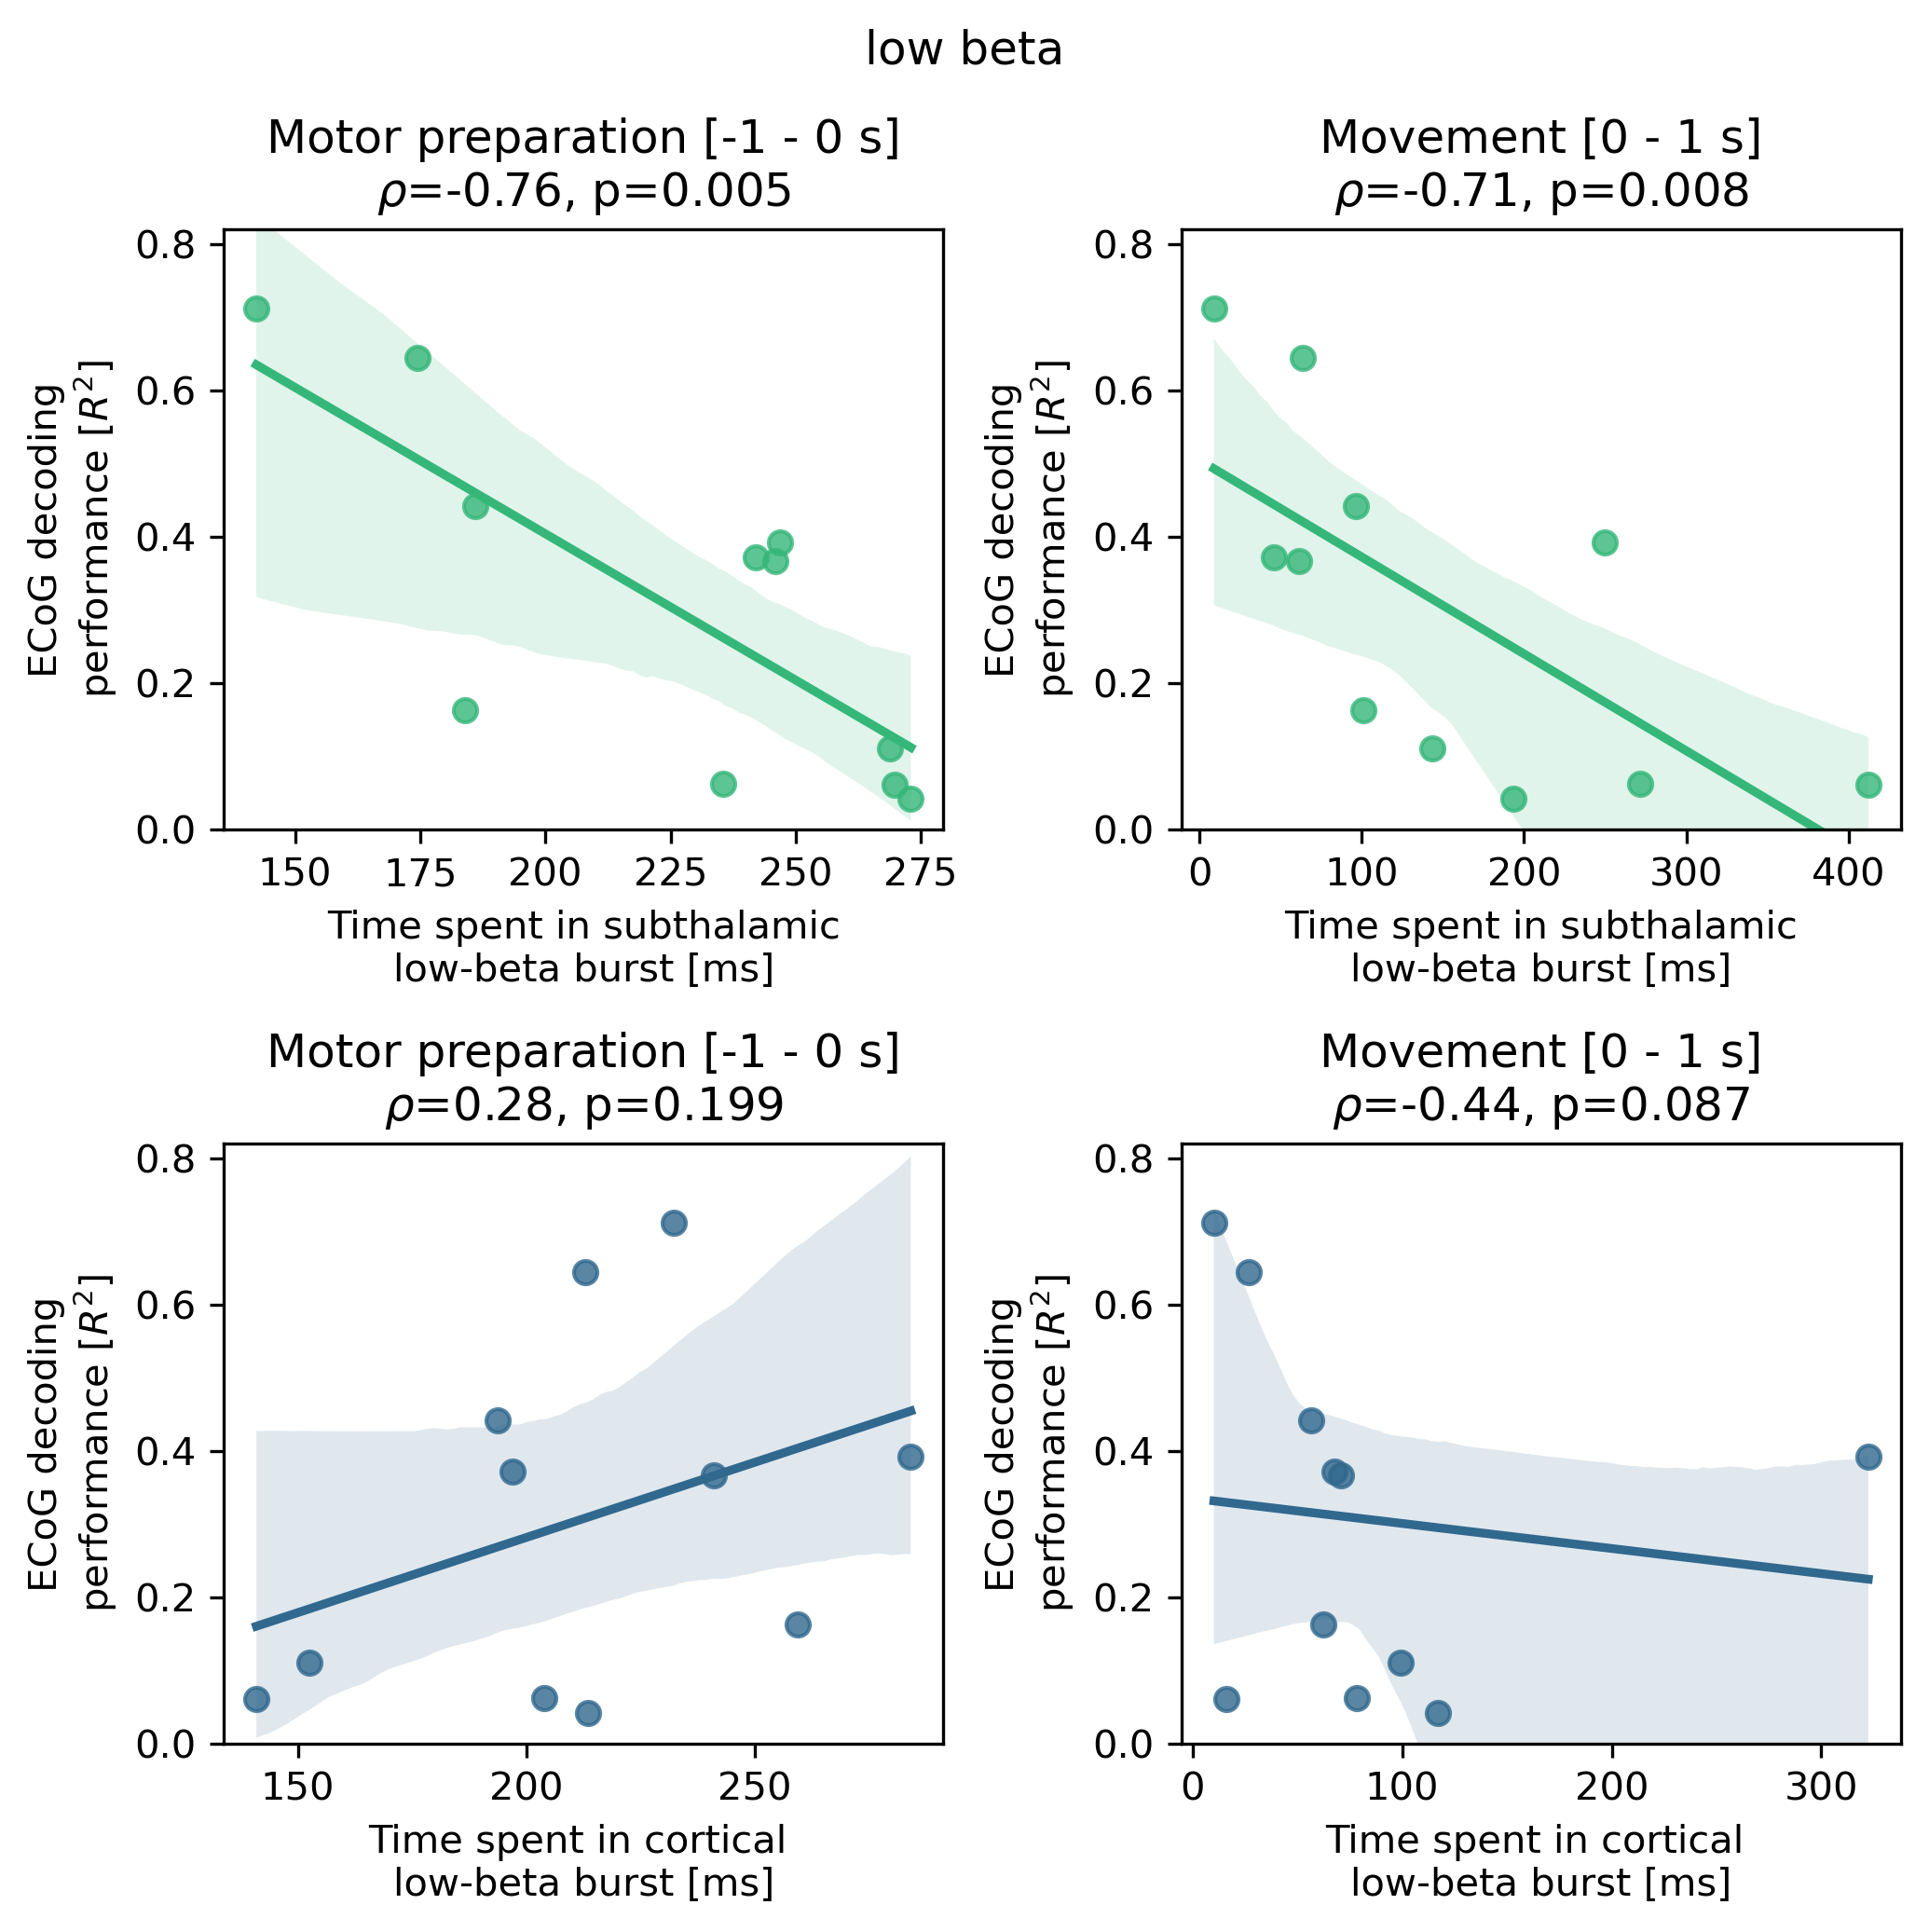

In [16]:
beta_ = "low_beta"
idx_ = 0
fig = plt.figure(figsize=(7,7), dpi=300)
burst_len = ["Motor preparation [-1 - 0 s]", "Movement [0 - 1 s]"]
colors_ = [(53/255,183/255,121/255), (49/255,104/255,142/255), ]
label_burst = ["Time spent in subthalamic\nlow-beta burst [ms]",
               "Time spent in cortical \nlow-beta burst [ms]"]

for loc_idx, loc in enumerate(["STN", "ECOG"]):
    for b_idx, burst_time in enumerate(["time in burst -1 to 0s", "time in burst 0 to 1s"]):
        idx_ += 1
        plt.subplot(2,2,idx_)
        
        df_plt = df_.query('loc == @loc and beta == @beta_ and variable == @burst_time')
        
        sns.regplot(x="value", y="r2_con", data=df_plt, color=colors_[loc_idx])
        plt.xlabel(label_burst[loc_idx])
        
        plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")
        
        rho, p = icn_stats.permutationTestSpearmansRho(
            df_plt["value"],
            df_plt["r2_con"],
            False,
            "R^2",
            5000
        )
        
        plt.title(burst_len[b_idx]+"\n"+r"$\rho$="+f"{np.round(rho, 2)}, p={np.round(p, 3)}")
        
        #if loc == "ECOG":
        plt.ylim(0, 0.82)
        
fig.suptitle("low beta")
plt.tight_layout()
plt.savefig("Point 2 - time spend in burst ECoG and STN low beta.pdf", bbox_inches='tight', dpi=300)


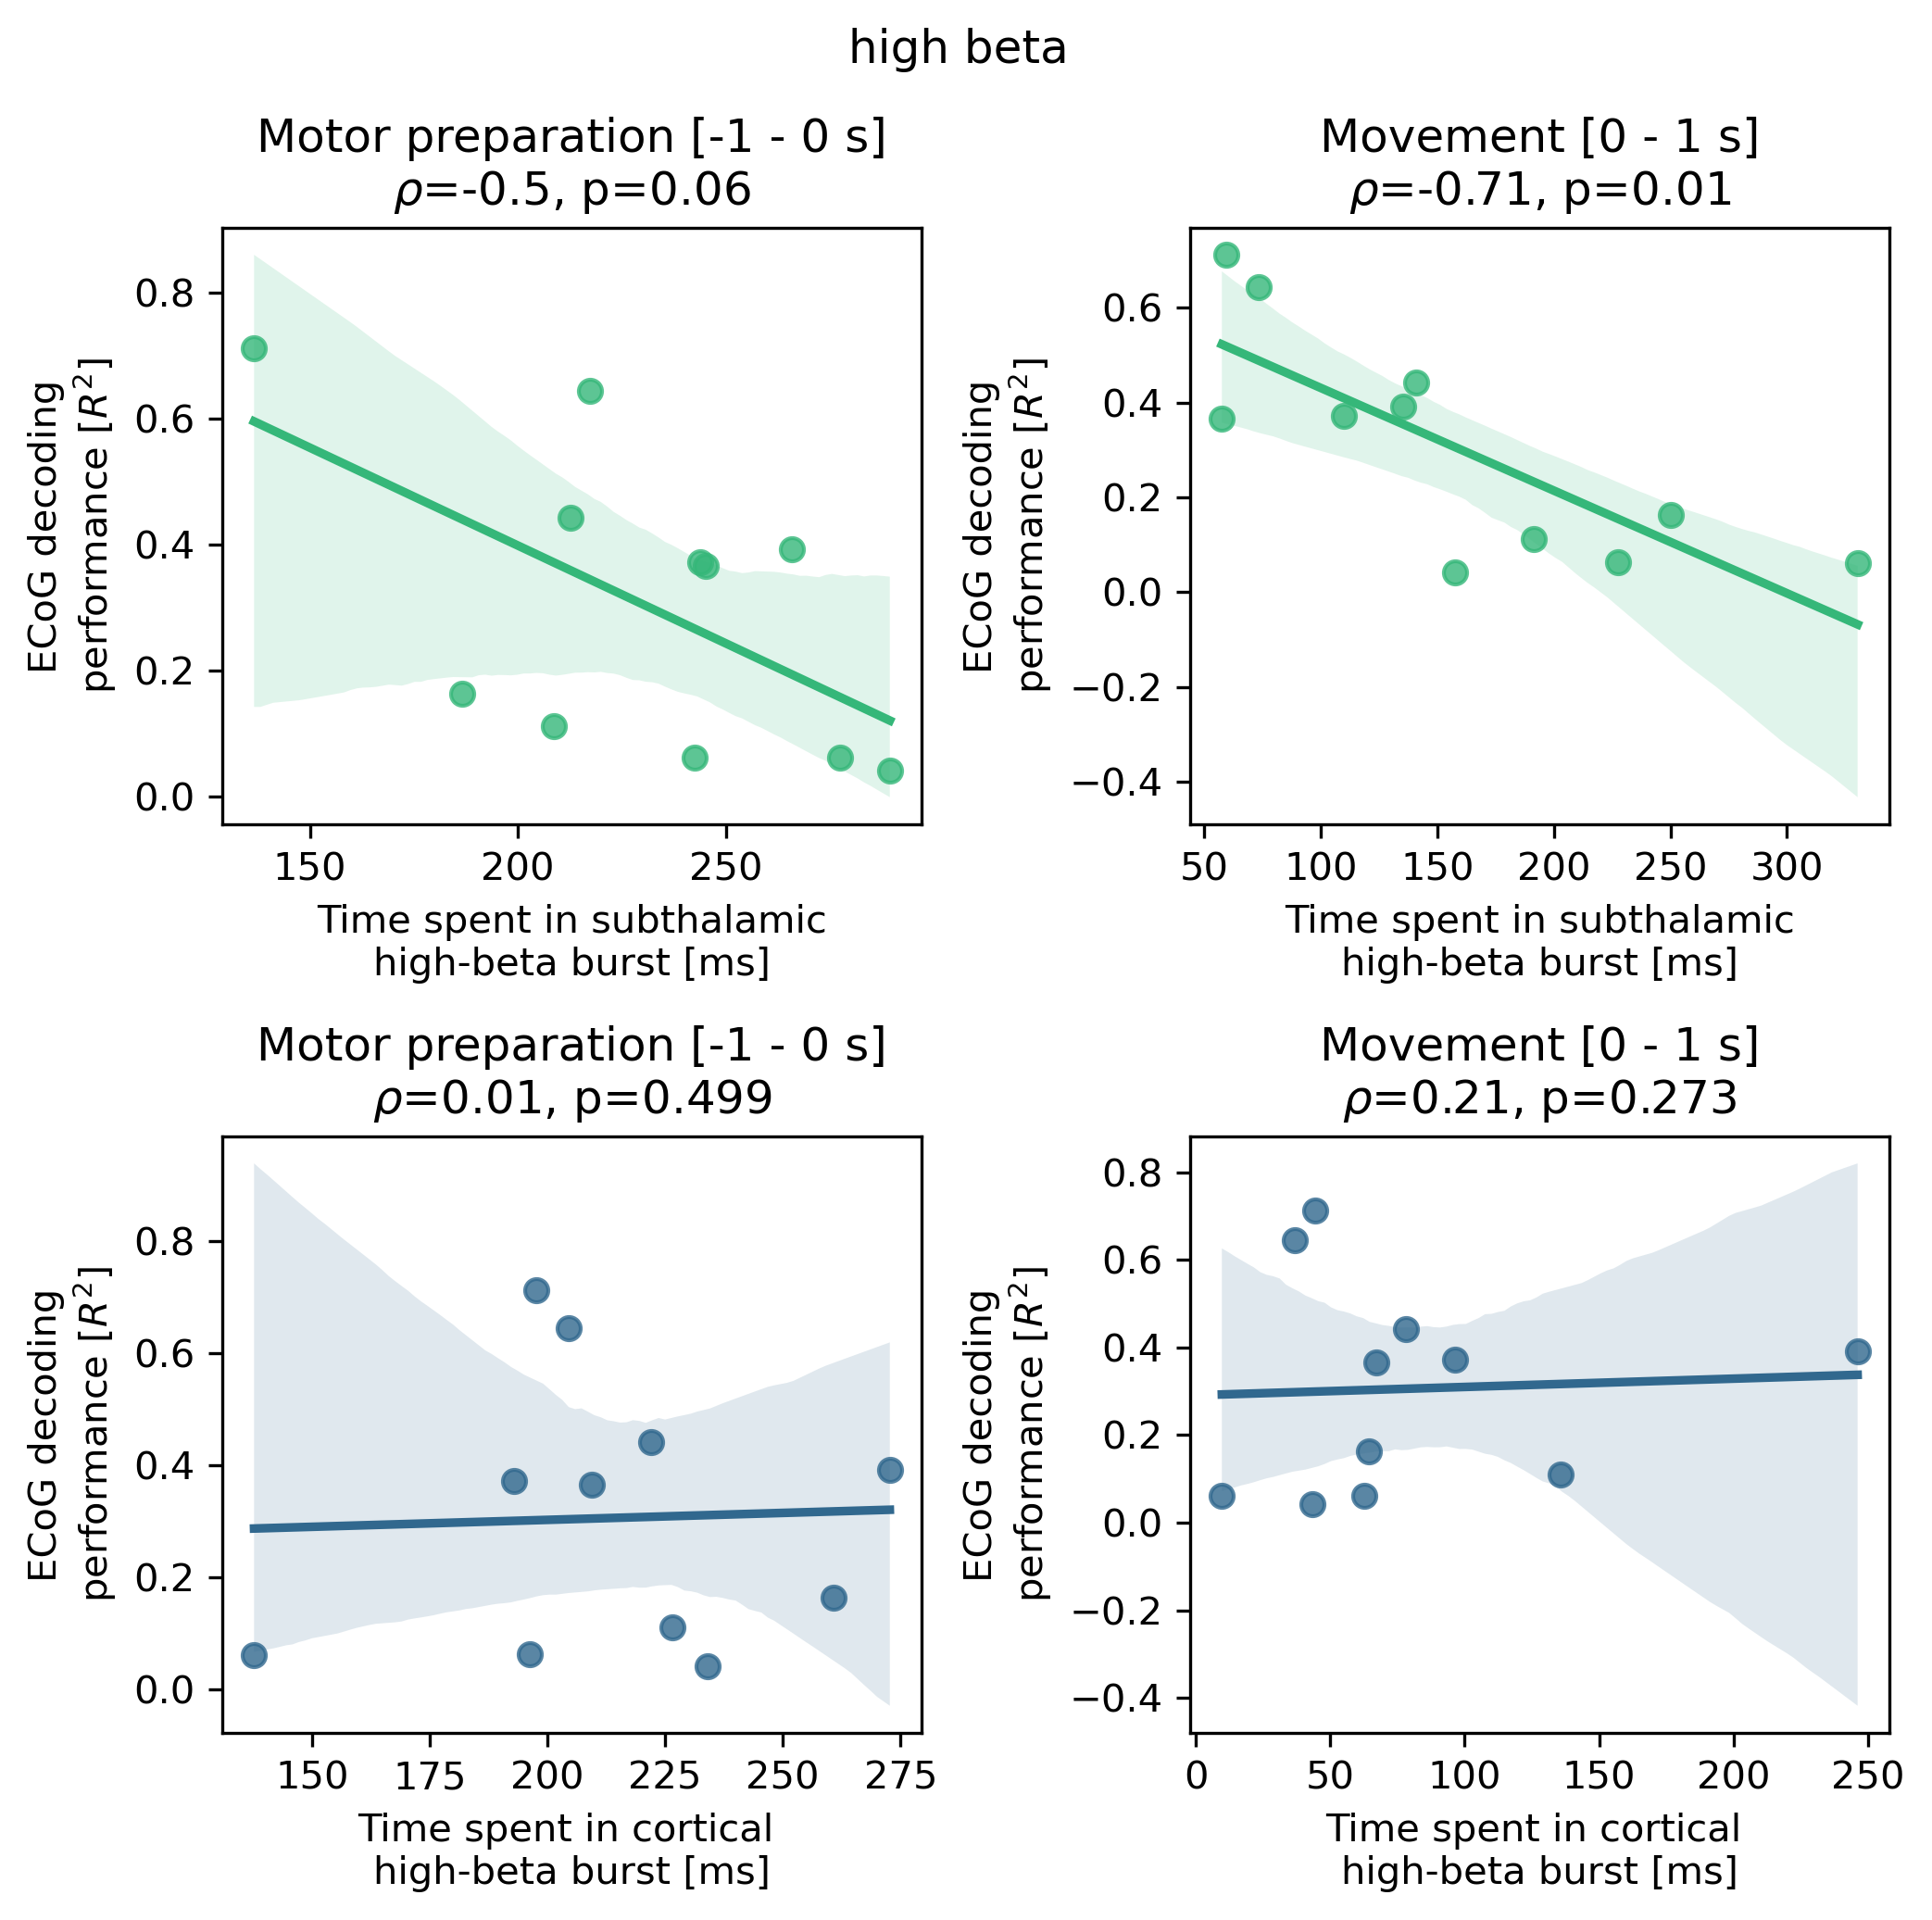

In [17]:
beta_ = "high_beta"
idx_ = 0
fig = plt.figure(figsize=(7,7), dpi=300)
burst_len = ["Motor preparation [-1 - 0 s]", "Movement [0 - 1 s]"]
colors_ = [(53/255,183/255,121/255), (49/255,104/255,142/255), ]
label_burst = ["Time spent in subthalamic\nhigh-beta burst [ms]",
               "Time spent in cortical \nhigh-beta burst [ms]"]

for loc_idx, loc in enumerate(["STN", "ECOG"]):
    for b_idx, burst_time in enumerate(["time in burst -1 to 0s", "time in burst 0 to 1s"]):
        idx_ += 1
        plt.subplot(2,2,idx_)
        
        df_plt = df_.query('loc == @loc and beta == @beta_ and variable == @burst_time')
        
        sns.regplot(x="value", y="r2_con", data=df_plt, color=colors_[loc_idx])
        plt.xlabel(label_burst[loc_idx])
        
        plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")
        
        rho, p = icn_stats.permutationTestSpearmansRho(
            df_plt["value"],
            df_plt["r2_con"],
            False,
            "R^2",
            5000
        )
        
        plt.title(burst_len[b_idx]+"\n"+r"$\rho$="+f"{np.round(rho, 2)}, p={np.round(p, 3)}")

fig.suptitle("high beta")
plt.tight_layout()
plt.savefig("Point 2 - time spend in burst ECoG and STN high beta.pdf", bbox_inches='tight', dpi=300)


In [29]:
### paired t test ecog vs stn time spent in burst

In [58]:
for beta_ in ["low_beta", "high_beta"]:
    print("_________________________")
    print(beta_)
    for t in ["time in burst -1 to 0s", "time in burst 0 to 1s"]:
        print(t)

        x = np.array(df_.query('loc == "ECOG" and beta == @beta_ and variable == @t')["value"])
        y = np.array(df_.query('loc == "STN" and beta == @beta_ and variable == @t')["value"])
        
        print(f"ECOG: {np.round(np.mean(x),2)} pm {np.round(np.std(x),2)}")
        print(f"STN: {np.round(np.mean(y),2)} pm {np.round(np.std(y),2)}")
        print(f"p={icn_stats.permutationTest_relative(x, y, False, 'R^2', 5000)[1]}")
        

_________________________
low_beta
time in burst -1 to 0s
ECOG: 211.92 pm 40.37
STN: 224.42 pm 42.8
p=0.5626
time in burst 0 to 1s
ECOG: 84.37 pm 81.55
STN: 149.83 pm 115.47
p=0.083
_________________________
high_beta
time in burst -1 to 0s
ECOG: 214.06 pm 34.67
STN: 229.68 pm 41.77
p=0.3694
time in burst 0 to 1s
ECOG: 80.49 pm 61.13
STN: 157.59 pm 82.15
p=0.044


In [69]:
beta_ = "low_beta"
t = "time in burst 0 to 1s"
df_ECoG_UDRS = df_.query('loc == "ECOG" and beta == @beta_ and variable == @t').copy()

UPRDRS_scores = [28.0, 27.0, 33.0, 31.0, 32.0, 52.0, 55.0, 50.0, 62.0, 48.0, 31.0]



In [70]:
df_ECoG_UDRS["UPDRS_total"] = UPRDRS_scores

Text(0.5, 1.0, 'rho=0.483 p=0.062')

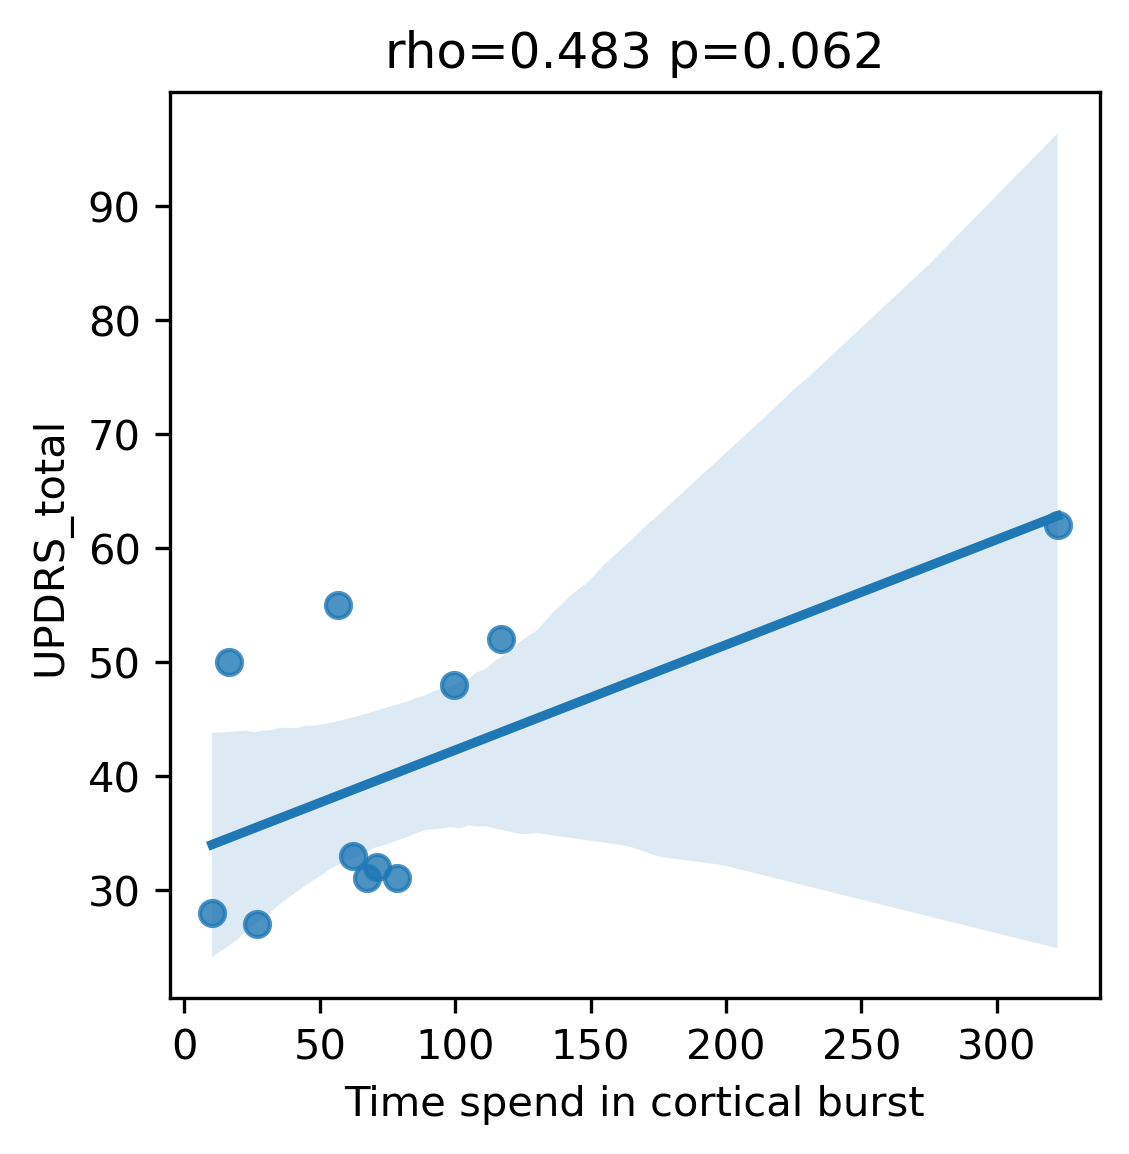

In [71]:
plt.figure(figsize=(4,4), dpi=300)
rho, p = icn_stats.permutationTestSpearmansRho(
            df_ECoG_UDRS["value"],
            df_ECoG_UDRS["UPDRS_total"],
            False,
            "R^2",
            1000
        )

sns.regplot(x="value", y="UPDRS_total", data=df_ECoG_UDRS)
plt.xlabel("Time spend in cortical burst")
plt.title(f"rho={np.round(rho, 3)} p={np.round(p, 3)}")

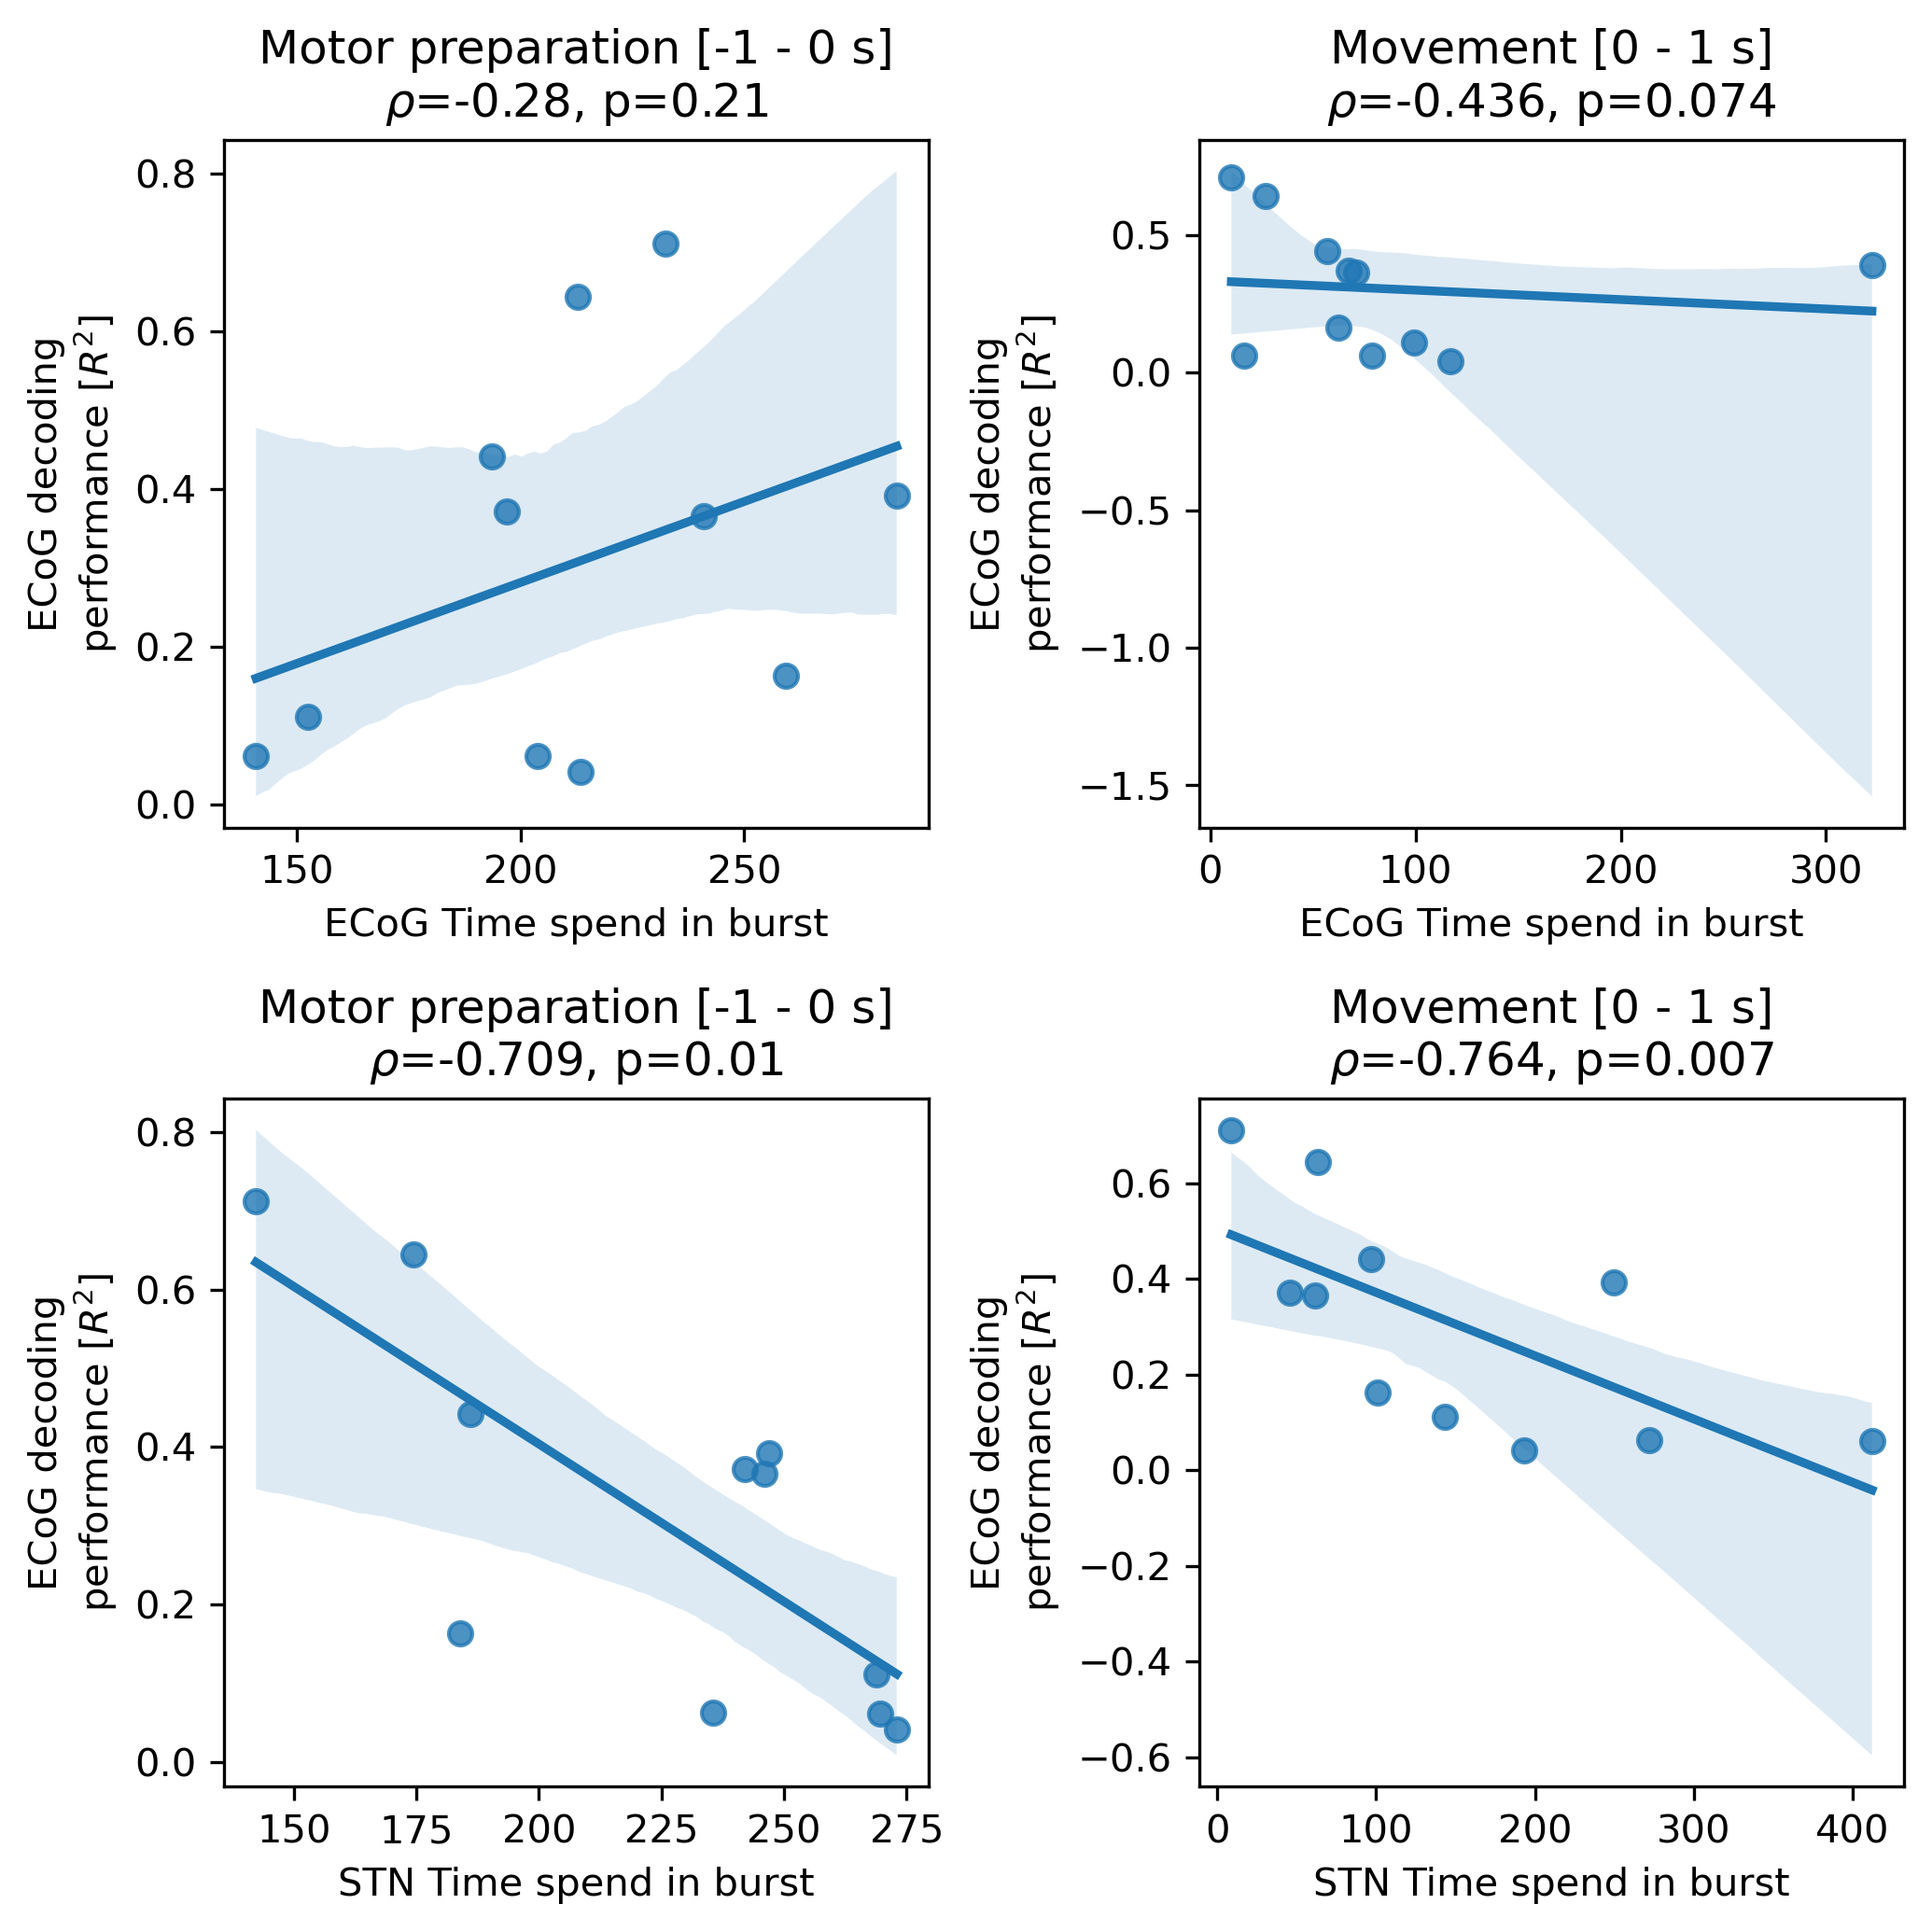

In [27]:
plt.figure(figsize=(7,7), dpi=300)
plt.subplot(221)
sns.regplot(x="value", y="r2_con",
            data=df_.query('loc == "ECOG" and beta == "low_beta" and variable == "time in burst -1 to 0s"'))
plt.xlabel("ECoG Time spend in burst")
plt.title("Motor preparation [-1 - 0 s]\n"+r"$\rho$"+"=-0.28, p=0.21")
plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")

plt.subplot(222)
sns.regplot(x="value", y="r2_con",
            data=df_.query('loc == "ECOG" and beta == "low_beta" and variable == "time in burst 0 to 1s"'))
plt.xlabel("ECoG Time spend in burst")
plt.title("Movement [0 - 1 s]\n"+r"$\rho$"+"=-0.436, p=0.074")
plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")

plt.subplot(223)
sns.regplot(x="value", y="r2_con",
            data=df_.query('loc == "STN" and beta == "low_beta" and variable == "time in burst -1 to 0s"'))
plt.xlabel("STN Time spend in burst")
plt.title("Motor preparation [-1 - 0 s]\n"+r"$\rho$"+"=-0.709, p=0.01")
plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")

plt.subplot(224)
sns.regplot(x="value", y="r2_con",
            data=df_.query('loc == "STN" and beta == "low_beta" and variable == "time in burst 0 to 1s"'))
plt.xlabel("STN Time spend in burst")
plt.title("Movement [0 - 1 s]\n"+r"$\rho$"+"=-0.764, p=0.007")
plt.ylabel("ECoG decoding\nperformance ["+r"$R^2$"+"]")

plt.tight_layout()

plt.savefig("Point 2 - time spend in burst ECoG and STN.pdf", bbox_inches='tight', dpi=300)


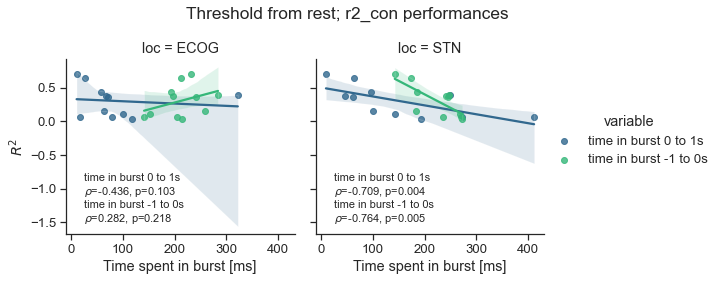

In [26]:


sns.set(style="whitegrid", font_scale=1.2)#, font="Times New Roman")
sns.set_style("ticks",{'axes.grid' : False})


g = sns.lmplot(x="value", y=y, hue="variable", palette="viridis",
                data=df_.query('beta == "low_beta"'), col="loc", height=4, aspect=1) # col="beta", 

g.set_axis_labels("Time spent in burst [ms]", r"$R^2$")


for ax in g.axes.flat:

    str_ = ax.get_title()
    loc = str_[str_.find("loc = ") + 6:]
    beta = "low_beta"
    
    text_stats = ""
    for var_ in cols_time_burst_spend:
        rho, p = icn_stats.permutationTestSpearmansRho(
            df_.query('loc == @loc and beta == "low_beta" and variable == @var_')[y],
            df_.query('loc == @loc and beta == "low_beta" and variable == @var_')["value"],
            False,
            "R^2",
            1000
        )
        text_stats += "\n" + var_ + "\n" + f"$\\rho$={np.round(rho,3)}, p={np.round(p, 3)}"

    ax.text(25, -1.5, text_stats, fontsize=11)

g.fig.subplots_adjust(top=0.8)

g.fig.suptitle(f"Threshold from {thr_}; {y} performances")
g.savefig("point_2_burst_duration_analysis.pdf", dpi=300)


In [56]:
def lm_plot_wrapper(y="r2_con", thr_="rest"):

    sns.set(style="whitegrid", font_scale=1.2)
    df_ = df_melt.query('thr == @thr_')
    g = sns.lmplot(x="value", y=y, hue="variable",
                        data=df_.query('beta == "low_beta"'), col="loc", height=4, aspect=1) # col="beta", 

    g.set_axis_labels("Time spend in burst", y)

    for ax in g.axes.flat:

        str_ = ax.get_title()
        loc = str_[str_.find("loc = ") + 6: str_.find("|")-1]
        beta = str_[str_.find("beta = ") + 7:]

        text_stats = ""
        for var_ in ["time_in_burst_0_1", "time_in_burst_minus_1_0"]:#, "time_in_burst_minus_3_1"]:
            rho, p = icn_stats.permutationTestSpearmansRho(
                df_.query('loc == @loc and beta == "low_beta" and variable == @var_')[y],
                df_.query('loc == @loc and beta == "low_beta" and variable == @var_')["value"],
                False,
                "R^2",
                1000
            )
            text_stats += "\n" + var_ + "\n" + f"$\\rho$={np.round(rho,3)}, p={np.round(p, 3)}"

        ax.text(350, -0.65, text_stats, fontsize=11)
        ax.set_xlabel("Time spent in burts [ms]")
    g.fig.subplots_adjust(top=0.9)

    g.fig.suptitle(f"Threshold from {thr_}; {y} performances")
    g.savefig(f'{y}_{thr_}.png', dpi=300)

TypeError: '>=' not supported between instances of 'list' and 'float'

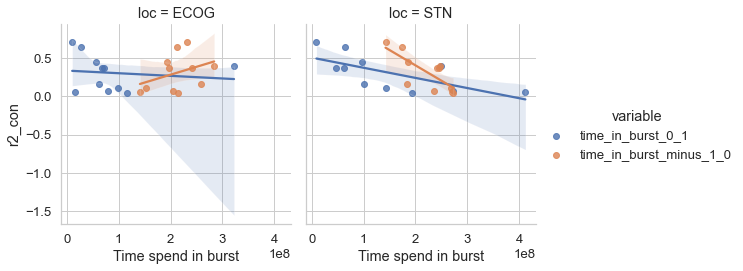

In [42]:
lm_plot_wrapper(y="r2_con", thr_="rest")

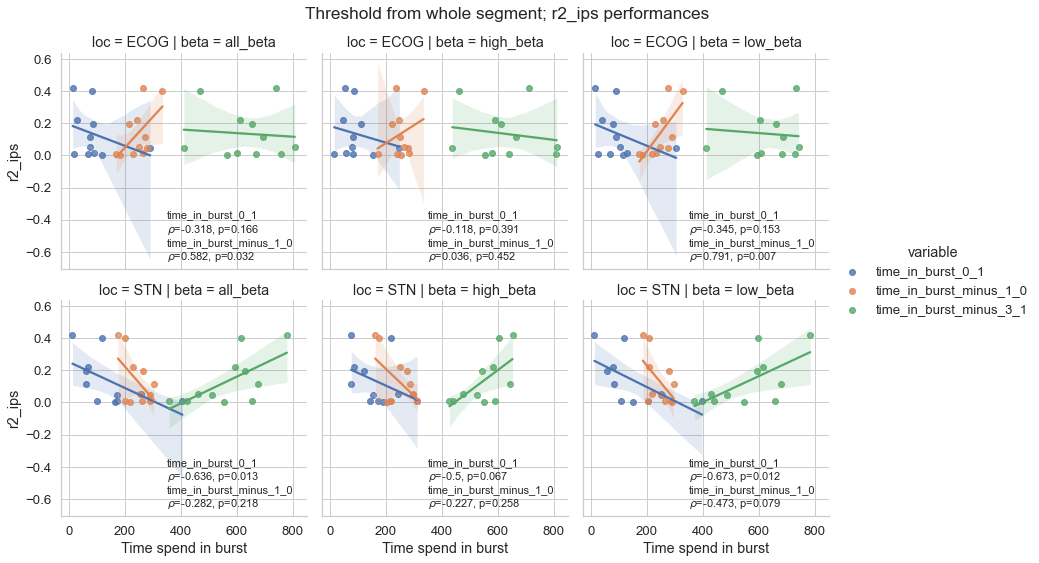

In [18]:
lm_plot_wrapper(y="r2_ips", thr_="whole segment")

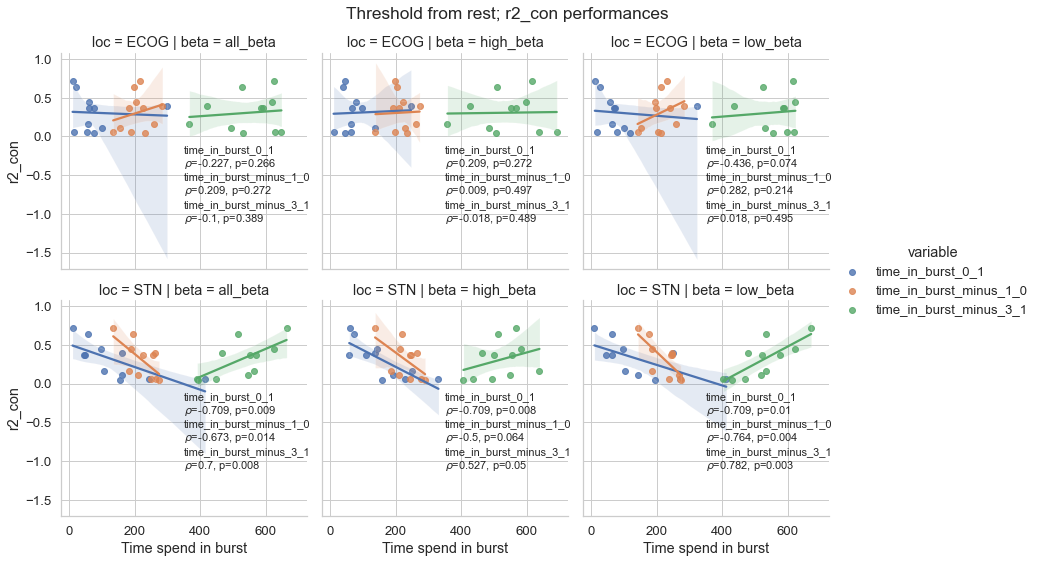

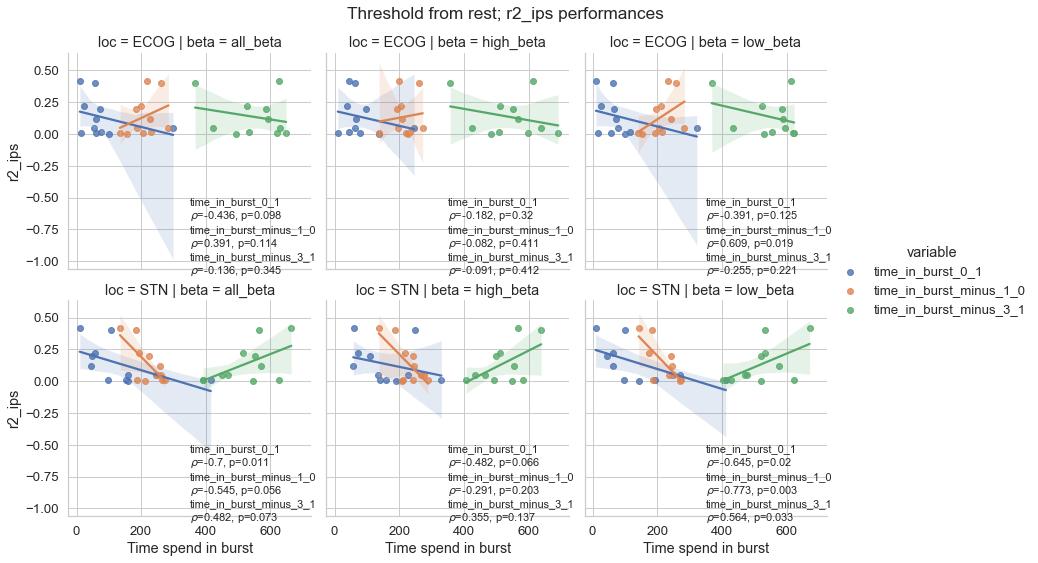

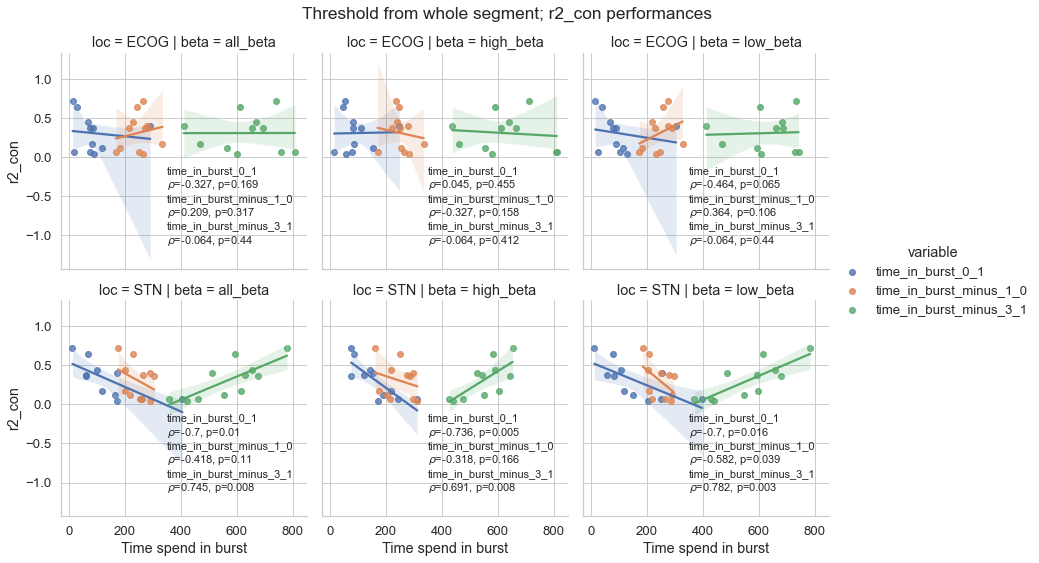

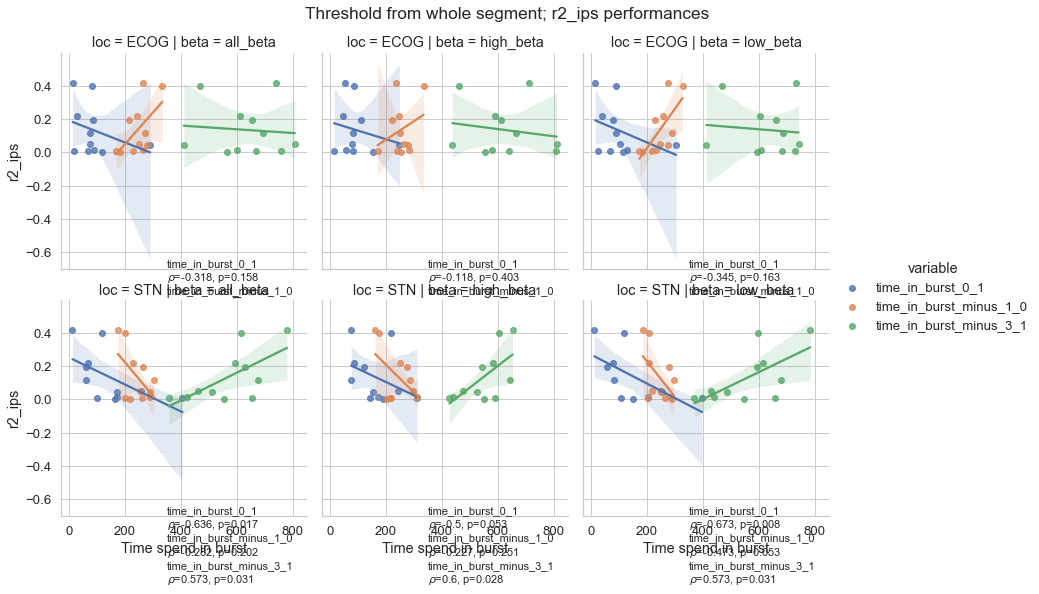

In [197]:
lm_plot_wrapper(y="r2_con", thr_="rest")
lm_plot_wrapper(y="r2_ips", thr_="rest")
lm_plot_wrapper(y="r2_con", thr_="whole segment")
lm_plot_wrapper(y="r2_ips", thr_="whole segment")

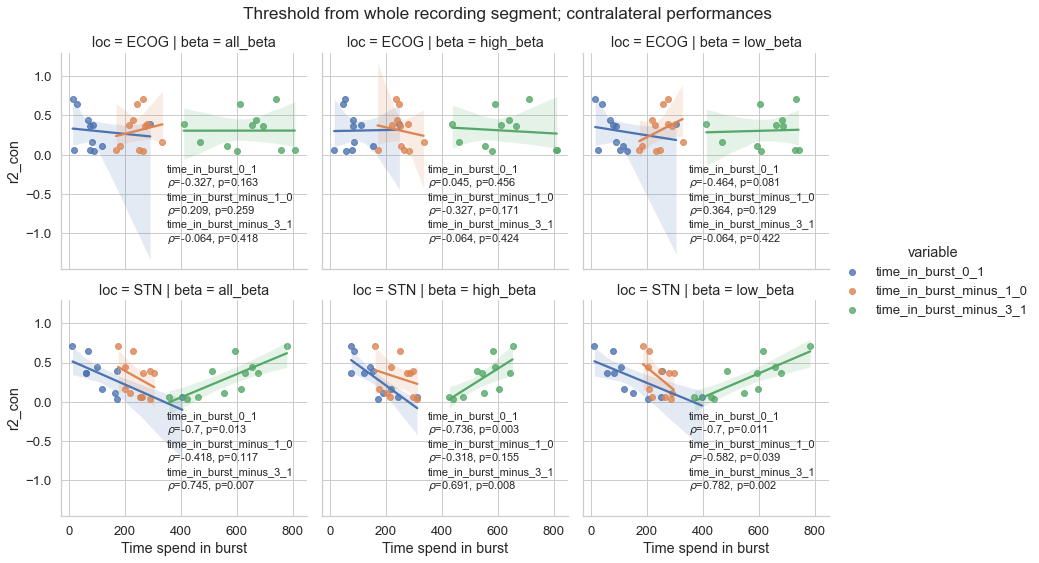

In [194]:
y = "r2_con"
sns.set(style="whitegrid", font_scale=1.2)
df_ = df_melt.query('thr == "whole segment"')
g = sns.lmplot(x="value", y=y, hue="variable",
                    data=df_, row="loc", col="beta", height=4, aspect=1)

g.set_axis_labels("Time spend in burst", y)

for ax in g.axes.flat:

    str_ = ax.get_title()
    loc = str_[str_.find("loc = ") + 6: str_.find("|")-1]
    beta = str_[str_.find("beta = ") + 7:]
    
    text_stats = ""
    for var_ in ["time_in_burst_0_1", "time_in_burst_minus_1_0", "time_in_burst_minus_3_1"]:
        rho, p = icn_stats.permutationTestSpearmansRho(
            df_.query('loc == @loc and beta == @beta and variable == @var_')[y],
            df_.query('loc == @loc and beta == @beta and variable == @var_')["value"],
            False,
            "R^2",
            1000
        )
        text_stats += "\n" + var_ + "\n" + f"$\\rho$={np.round(rho,3)}, p={np.round(p, 3)}"

    ax.text(350, -1.1, text_stats, fontsize=11)

g.fig.subplots_adjust(top=0.9)

g.fig.suptitle("Threshold from whole recording segment; contralateral performances")
g.savefig('con_all.png', dpi=300)

In [144]:
loc

'STN'

In [147]:
beta

'low_beta'

In [103]:
df_melt

r2_con    r2_ips   loc       beta            thr  \
0    0.711734  0.418974  ECOG   all_beta           rest   
1    0.711734  0.418974  ECOG   all_beta  whole segment   
2    0.711734  0.418974   STN   all_beta           rest   
3    0.711734  0.418974   STN   all_beta  whole segment   
4    0.711734  0.418974  ECOG  high_beta           rest   
..        ...       ...   ...        ...            ...   
391  0.062358  0.050032   STN  high_beta  whole segment   
392  0.062358  0.050032  ECOG   low_beta           rest   
393  0.062358  0.050032  ECOG   low_beta  whole segment   
394  0.062358  0.050032   STN   low_beta           rest   
395  0.062358  0.050032   STN   low_beta  whole segment   

                    variable       value  
0          time_in_burst_0_1    9.913793  
1          time_in_burst_0_1   13.505747  
2          time_in_burst_0_1    9.756098  
3          time_in_burst_0_1   13.008130  
4          time_in_burst_0_1   44.252874  
..                       ...         ...  
391  time_in_burst_minus_3_1  477.536232  
392  time_in_burst_minus_3_1  596.607670  
393  time_in_burst_minus_3_1  742.035398  
394  time_in_burst_minus_3_1  470.289855  
395  time_in_burst_minus_3_1  430.434783  

[396 rows x 7 columns]

Text(0.5, 0.98, 'loc: ECOG thr: rest')

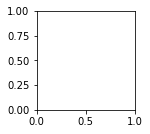

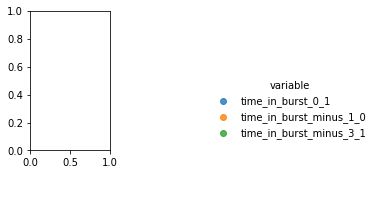

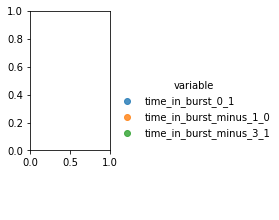

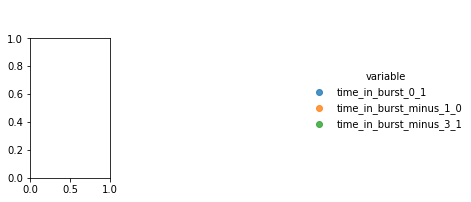

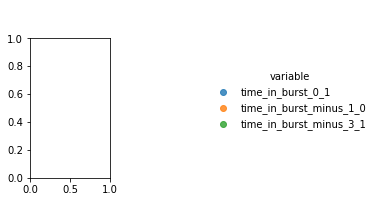

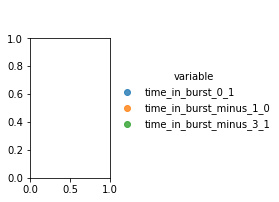

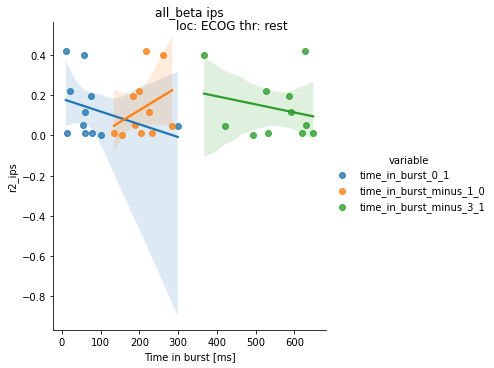

In [99]:
loc = "ECOG"
thr = "rest"
idx = 1

for lat in ["con", "ips"]:
    for beta in beta_names:
    
        plt.subplot(2,3,idx)
        idx+=1
        
        df_melt = pd.melt(df_merged.query('loc == @loc and beta == @beta and thr == @thr'),
                id_vars=['r2_con', 'r2_ips'],
                value_vars=["time_in_burst_0_1", "time_in_burst_minus_1_0", "time_in_burst_minus_3_1"]
        )
        
        sns.lmplot(x="value", y="r2_"+lat, hue="variable",
                    data=df_melt)
        plt.title(f"{beta} {lat}")# rho={np.round(rho,2)} p={np.round(p,4)}")
        plt.xlabel("Time in burst [ms]")
plt.suptitle(f"loc: {loc} thr: {thr}")

In [76]:
s = df_merged.query('loc == "ECOG" and beta == "low_beta" and thr == "rest"')[[
    "time_in_burst_0_1", "time_in_burst_minus_1_0", "time_in_burst_minus_3_1"
]].stack()
s.name='values'
df_tidy=s.reset_index()

In [77]:
df_tidy

level_0                  level_1      values
0         8        time_in_burst_0_1   10.201149
1         8  time_in_burst_minus_1_0  232.327586
2         8  time_in_burst_minus_3_1  614.942529
3        20        time_in_burst_0_1   26.731440
4        20  time_in_burst_minus_1_0  212.884194
5        20  time_in_burst_minus_3_1  524.401012
6        32        time_in_burst_0_1   62.351718
7        32  time_in_burst_minus_1_0  259.394401
8        32  time_in_burst_minus_3_1  368.463137
9        44        time_in_burst_0_1   67.565036
10       44  time_in_burst_minus_1_0  196.950114
11       44  time_in_burst_minus_3_1  586.761224
12       56        time_in_burst_0_1   70.917714
13       56  time_in_burst_minus_1_0  241.038372
14       56  time_in_burst_minus_3_1  588.055748
15       68        time_in_burst_0_1  116.877637
16       68  time_in_burst_minus_1_0  213.502110
17       68  time_in_burst_minus_3_1  553.586498
18       80        time_in_burst_0_1   56.756757
19       80  time_in_burst_minus_1_0  193.693694
20       80  time_in_burst_minus_3_1  623.423423
21       92        time_in_burst_0_1   16.293532
22       92  time_in_burst_minus_1_0  140.920398
23       92  time_in_burst_minus_3_1  620.024876
24      104        time_in_burst_0_1  322.419290
25      104  time_in_burst_minus_1_0  284.100176
26      104  time_in_burst_minus_3_1  434.310062
27      116        time_in_burst_0_1   99.346405
28      116  time_in_burst_minus_1_0  152.450980
29      116  time_in_burst_minus_3_1  531.372549
30      128        time_in_burst_0_1   78.613569
31      128  time_in_burst_minus_1_0  203.834808
32      128  time_in_burst_minus_3_1  596.607670

In [66]:
s=df_merged.query('"loc" == "ECOG" and "beta" == "low_beta" and "thr" == "rest"')'.stack()
s.name='values'
df_tidy=s.reset_index()

SyntaxError: invalid syntax (Temp/ipykernel_18156/3023797777.py, line 2)

In [55]:
s=df_merged.stack()
s.name='values'
df_tidy=s.reset_index()

In [56]:
df_tidy

level_0                  level_1      values
0           0                      sub           0
1           0                     beta    all_beta
2           0                      loc        ECOG
3           0                      thr        rest
4           0        time_in_burst_0_1    9.913793
...       ...                      ...         ...
1183      131        time_in_burst_0_1  249.275362
1184      131  time_in_burst_minus_1_0   218.84058
1185      131  time_in_burst_minus_3_1  430.434783
1186      131                   r2_con    0.062358
1187      131                   r2_ips    0.050032

[1188 rows x 3 columns]

In [52]:
def plot_beta_con_ips_corr(x_, loc, thr):
    plt.figure(figsize=(12,6), dpi=300)
    idx = 1
    print(loc)
    for lat in ["con", "ips"]:
        for beta in beta_names:

            rho, p = icn_stats.permutationTestSpearmansRho(
                df_merged.query('beta==@beta and loc==@loc and thr==@thr')["r2_"+lat],
                df_merged.query('beta==@beta and loc==@loc and thr==@thr')[x_],
                False,
                "R^2",
                1000
            )
            plt.subplot(2,3,idx)
            idx+=1
            sns.regplot(x=x_, y="r2_"+lat,
                        data=df_merged.query('beta==@beta and loc==@loc and thr==@thr'))
            plt.title(f"{beta} {lat} rho={np.round(rho,2)} p={np.round(p,4)}")
            plt.xlabel(f"{x_} [ms]")
    plt.suptitle(f"{x_} loc: {loc} thr: {thr}")
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,6), dpi=300)
idx = 1
print(loc)
for lat in ["con", "ips"]:
    for beta in beta_names:

        rho, p = icn_stats.permutationTestSpearmansRho(
            df_merged.query('beta==@beta and loc==@loc and thr==@thr')["r2_"+lat],
            df_merged.query('beta==@beta and loc==@loc and thr==@thr')[x_],
            False,
            "R^2",
            1000
        )
        plt.subplot(2,3,idx)
        idx+=1
        sns.regplot(x=x_, y="r2_"+lat,
                    data=df_merged.query('beta==@beta and loc==@loc and thr==@thr'))
        plt.title(f"{beta} {lat} rho={np.round(rho,2)} p={np.round(p,4)}")
        plt.xlabel(f"{x_} [ms]")
plt.suptitle(f"{x_} loc: {loc} thr: {thr}")

ECOG
ECOG
STN
STN
ECOG
ECOG
STN
STN
ECOG
ECOG
STN
STN


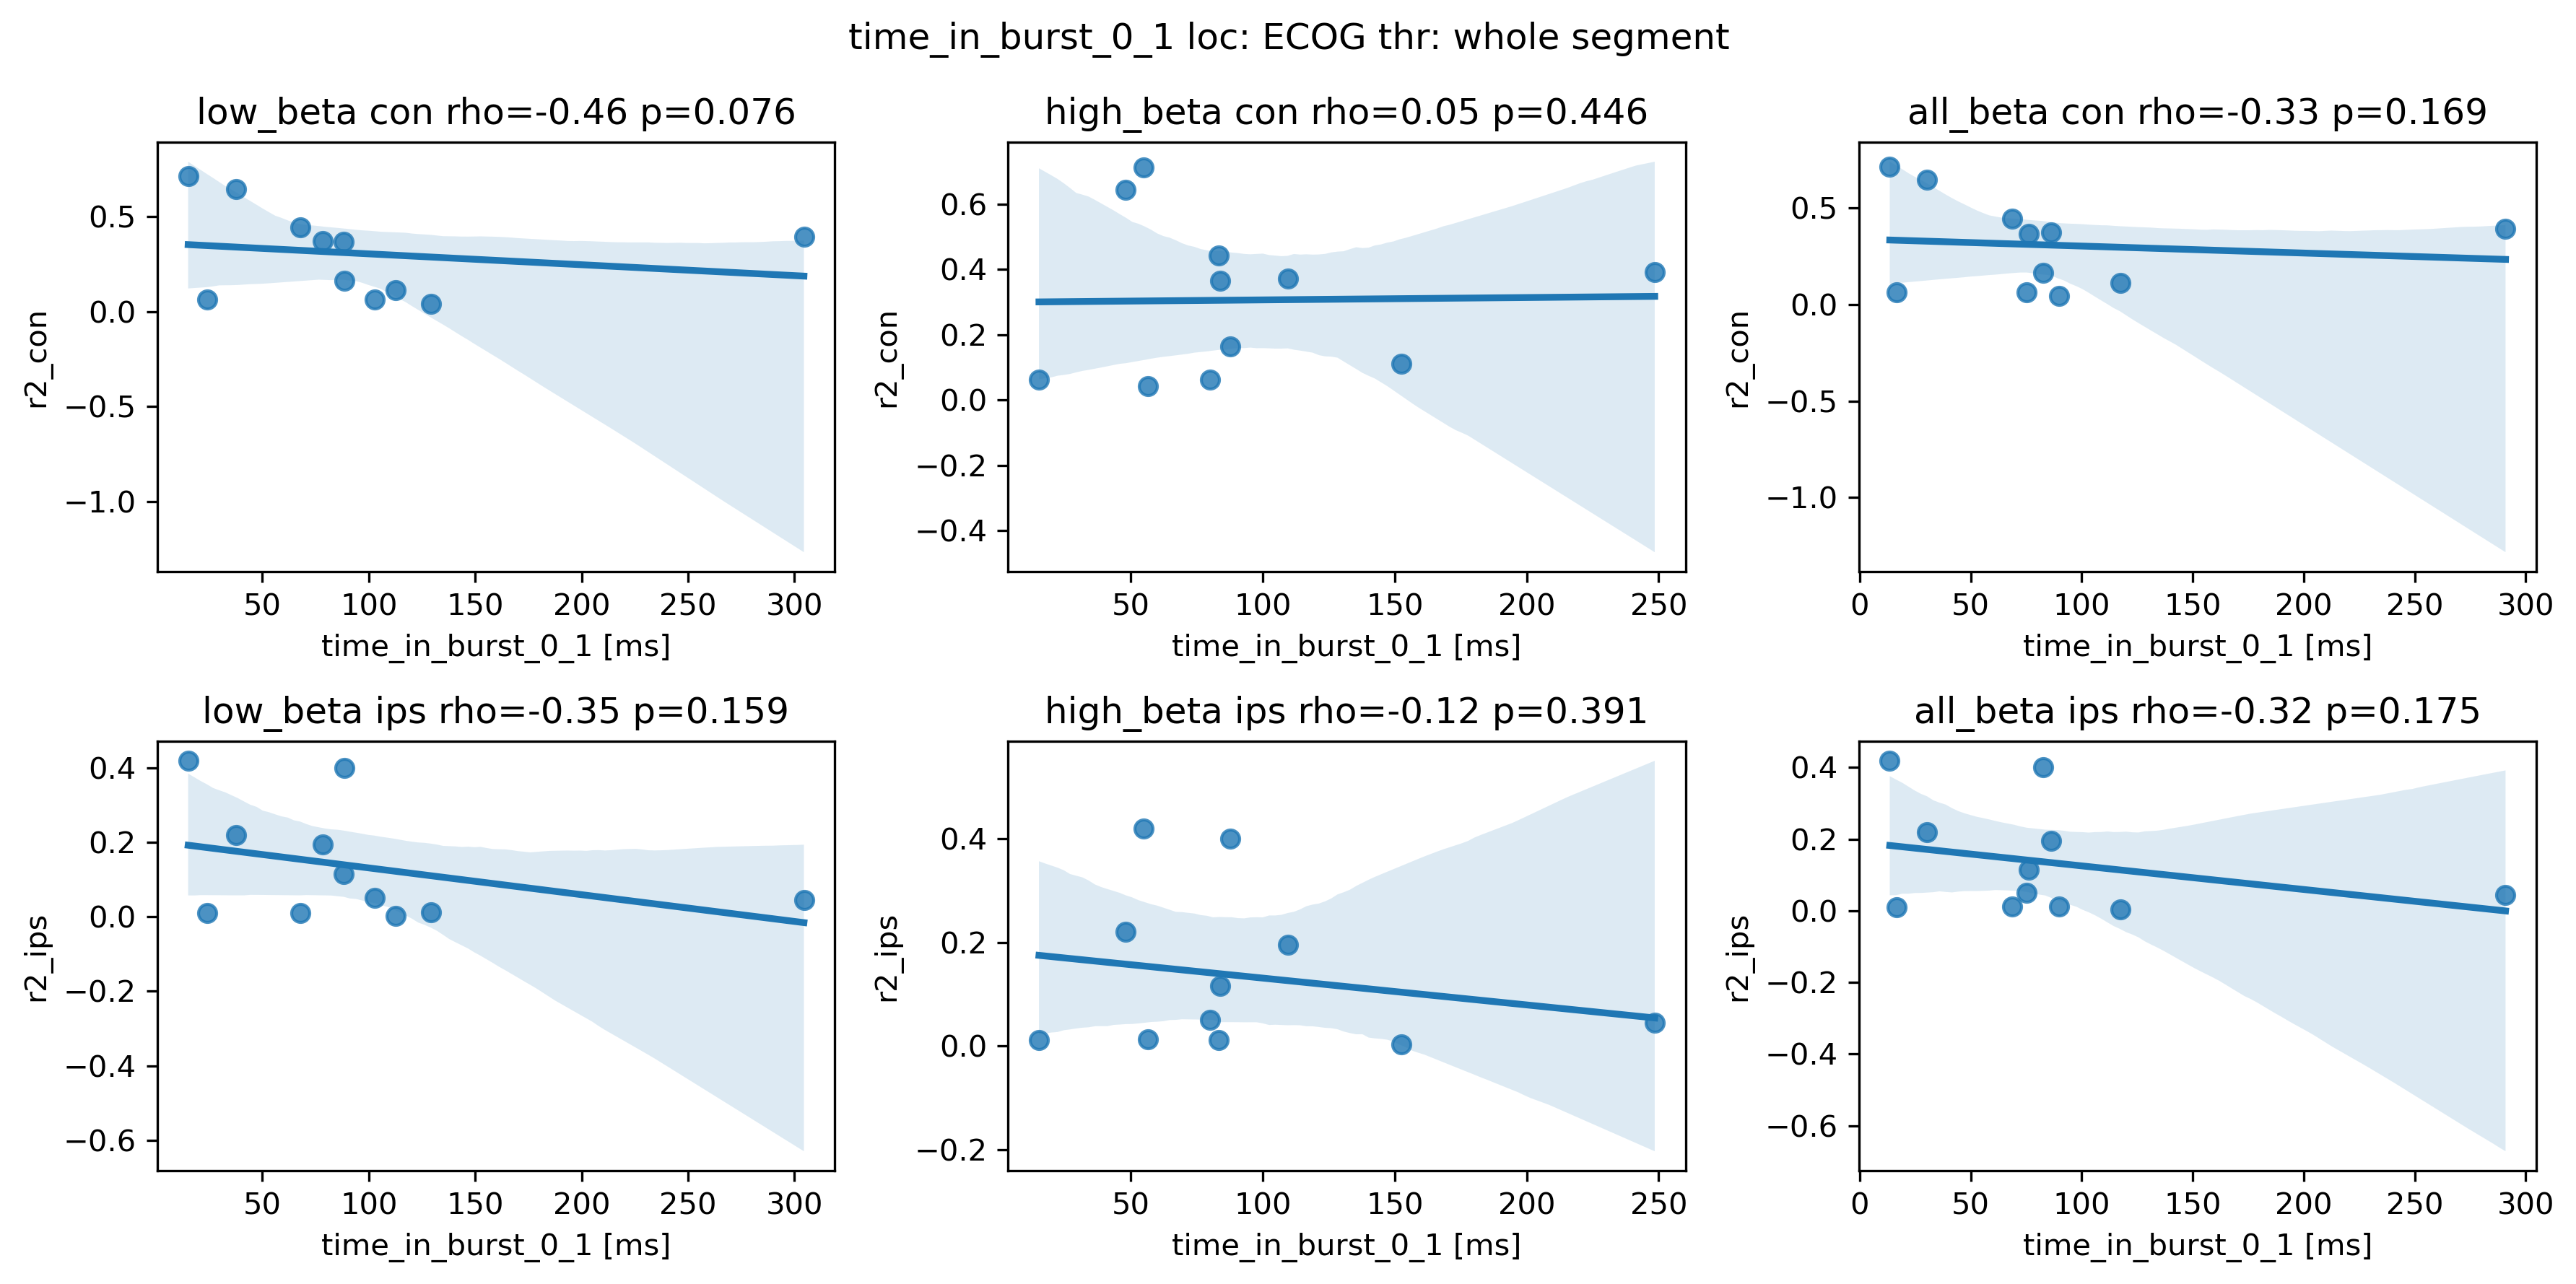

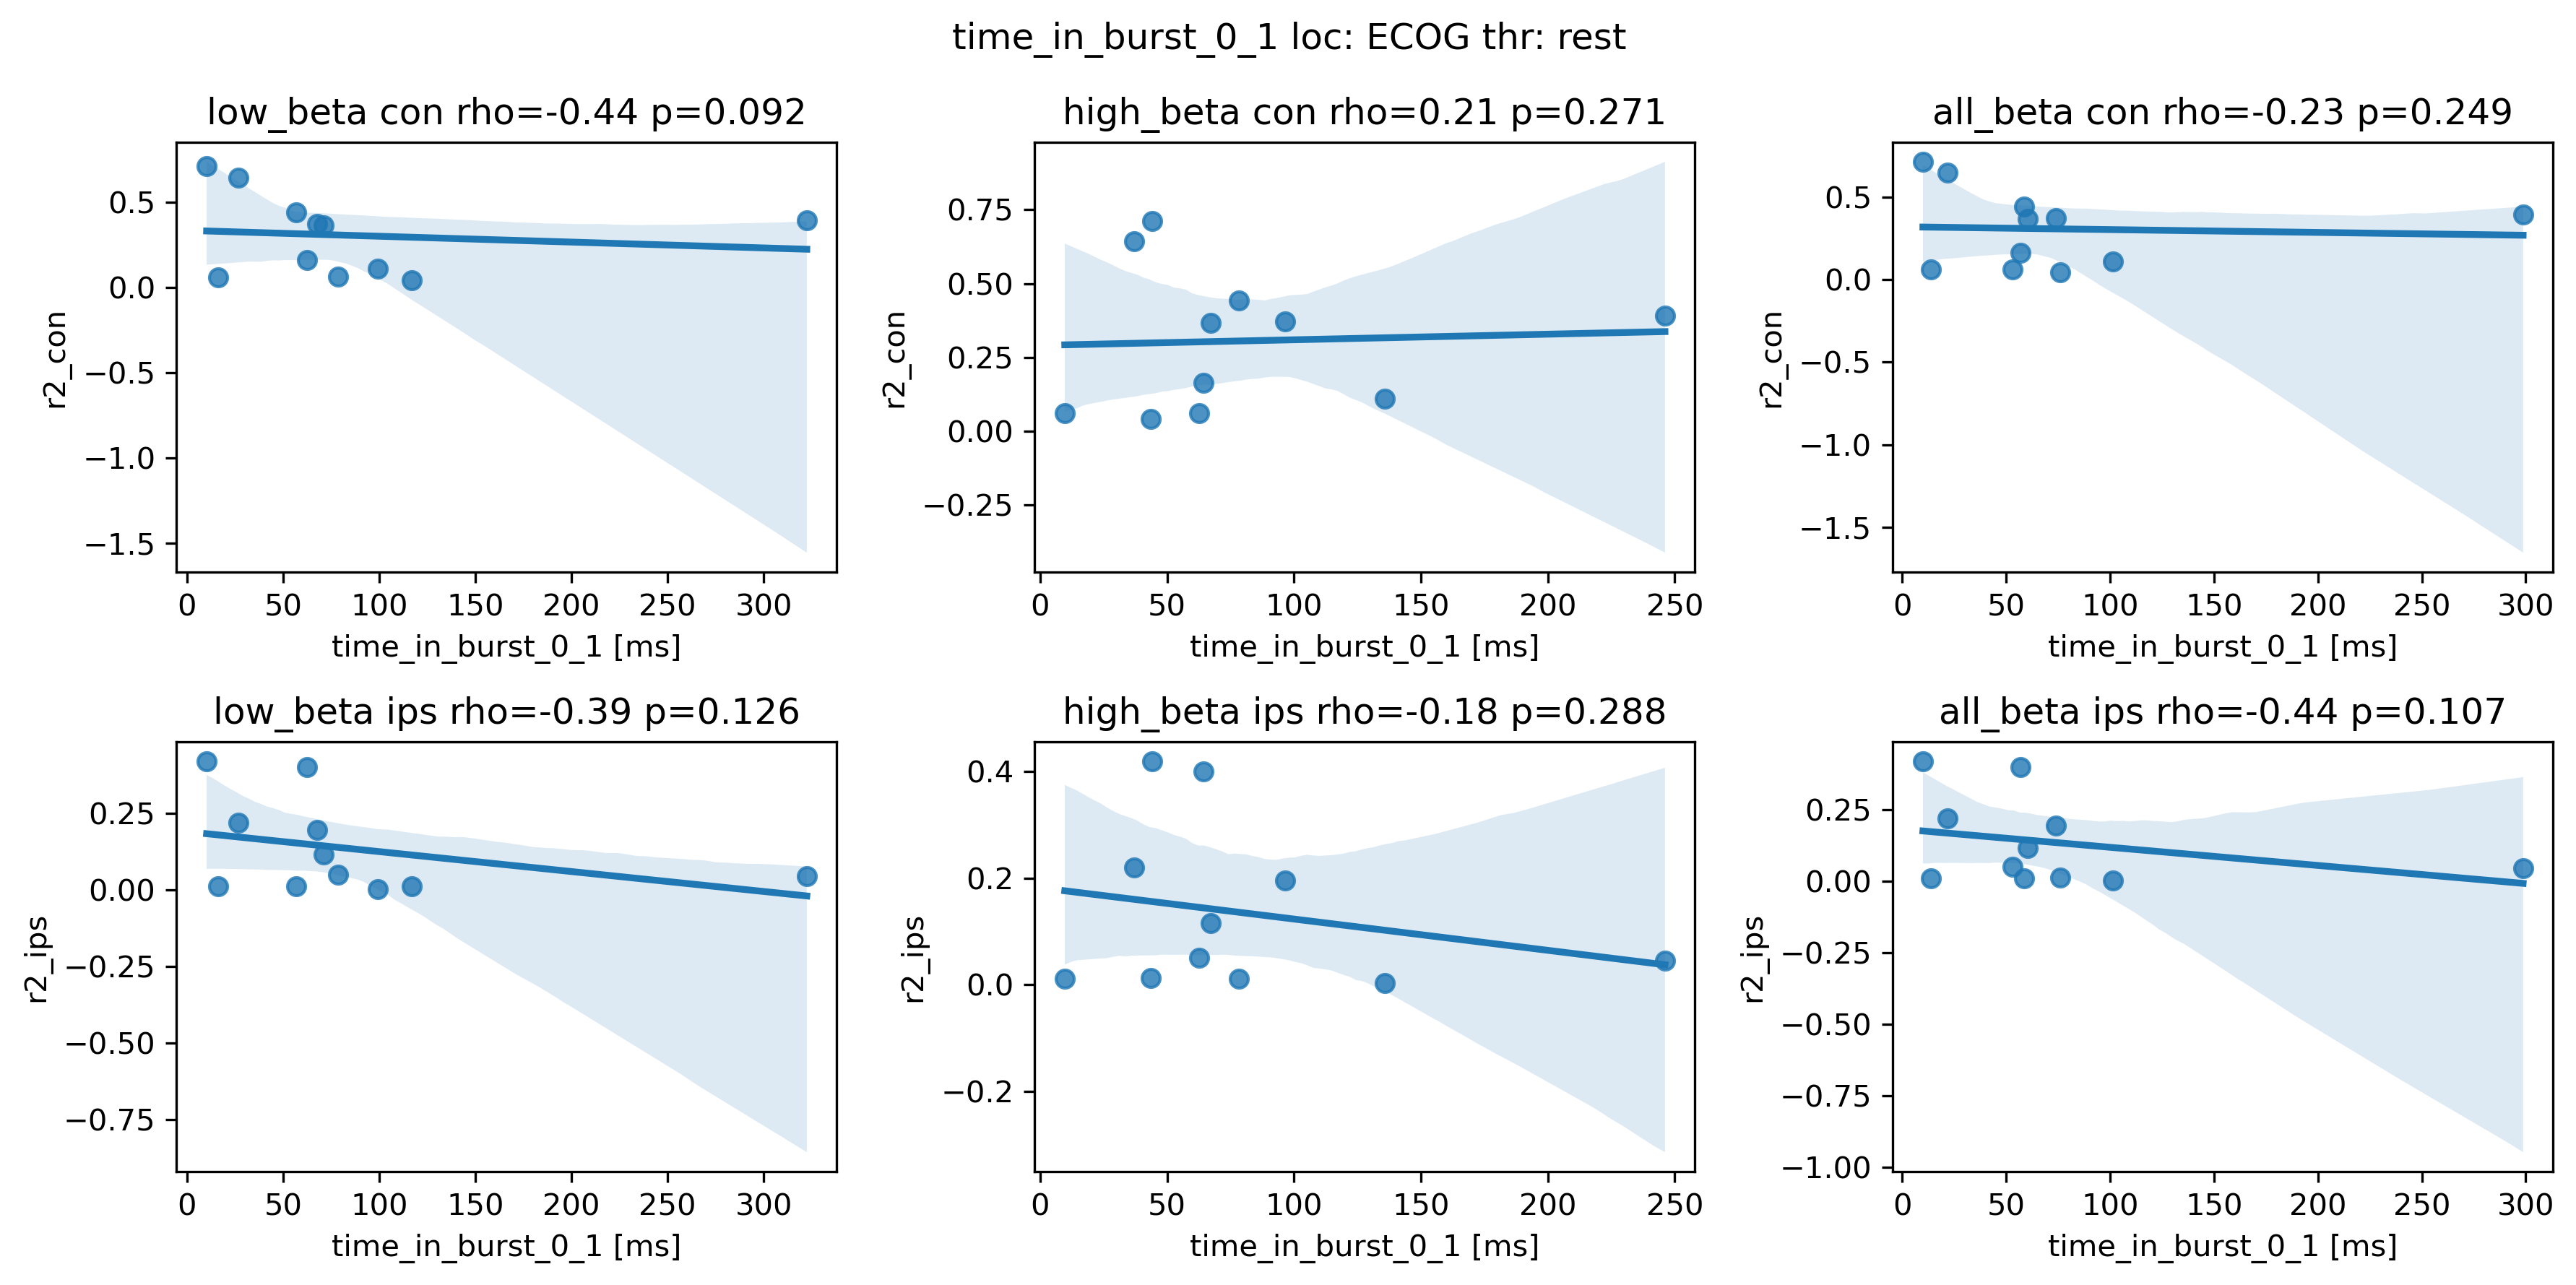

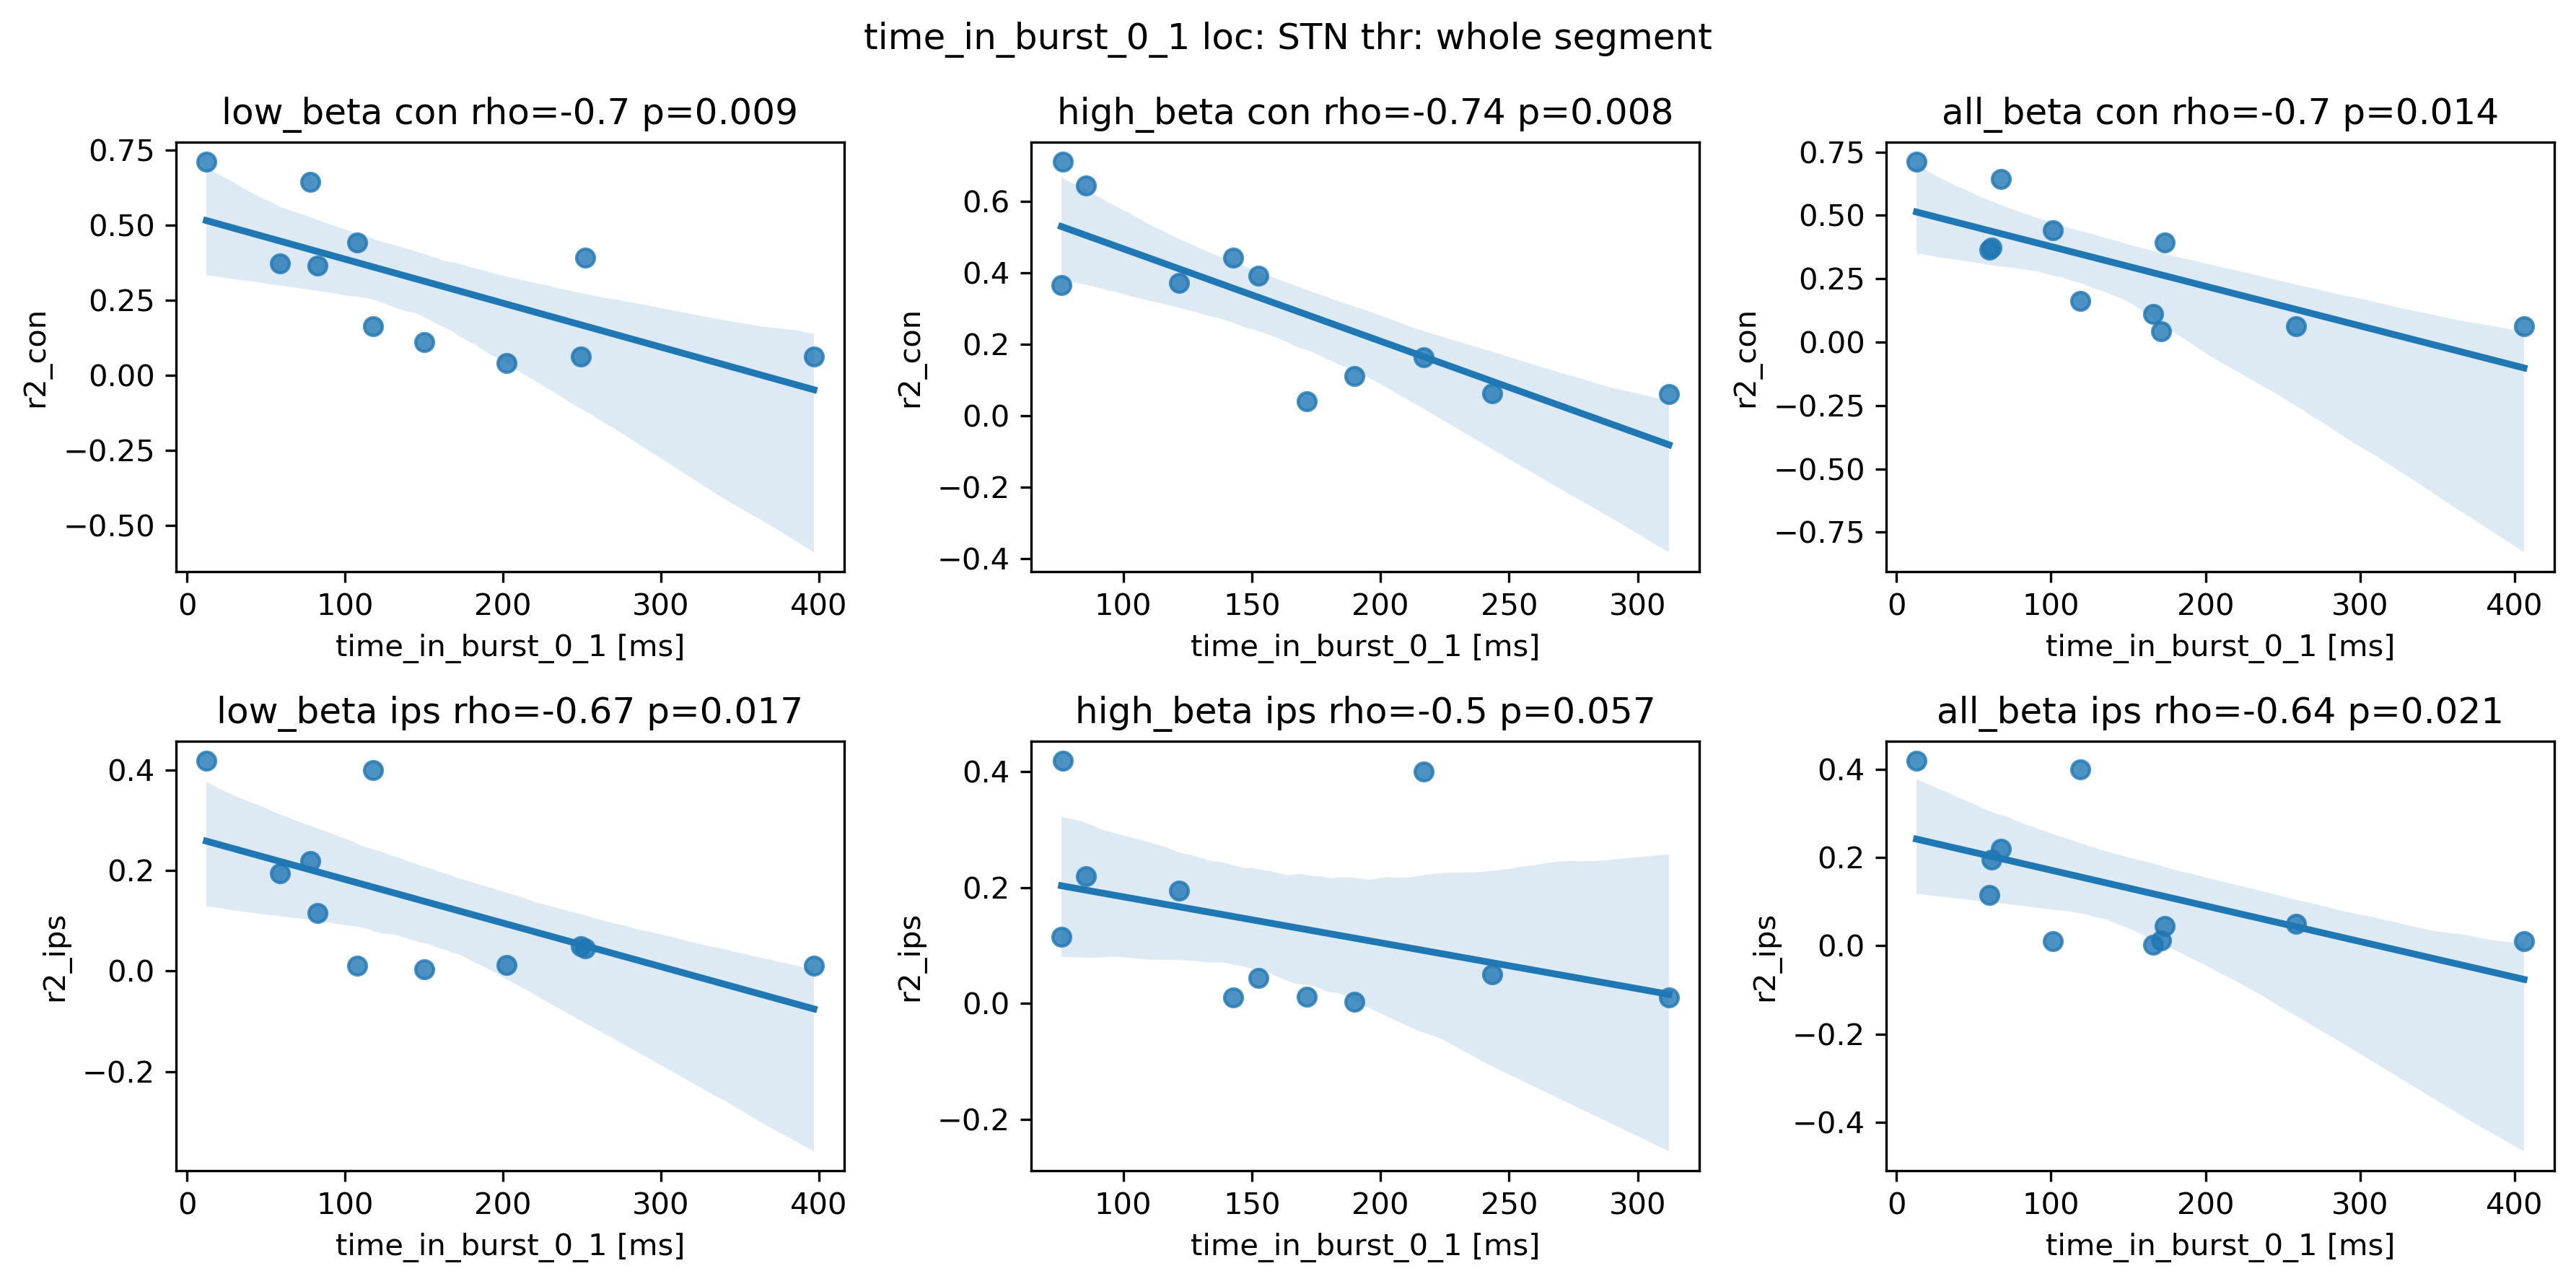

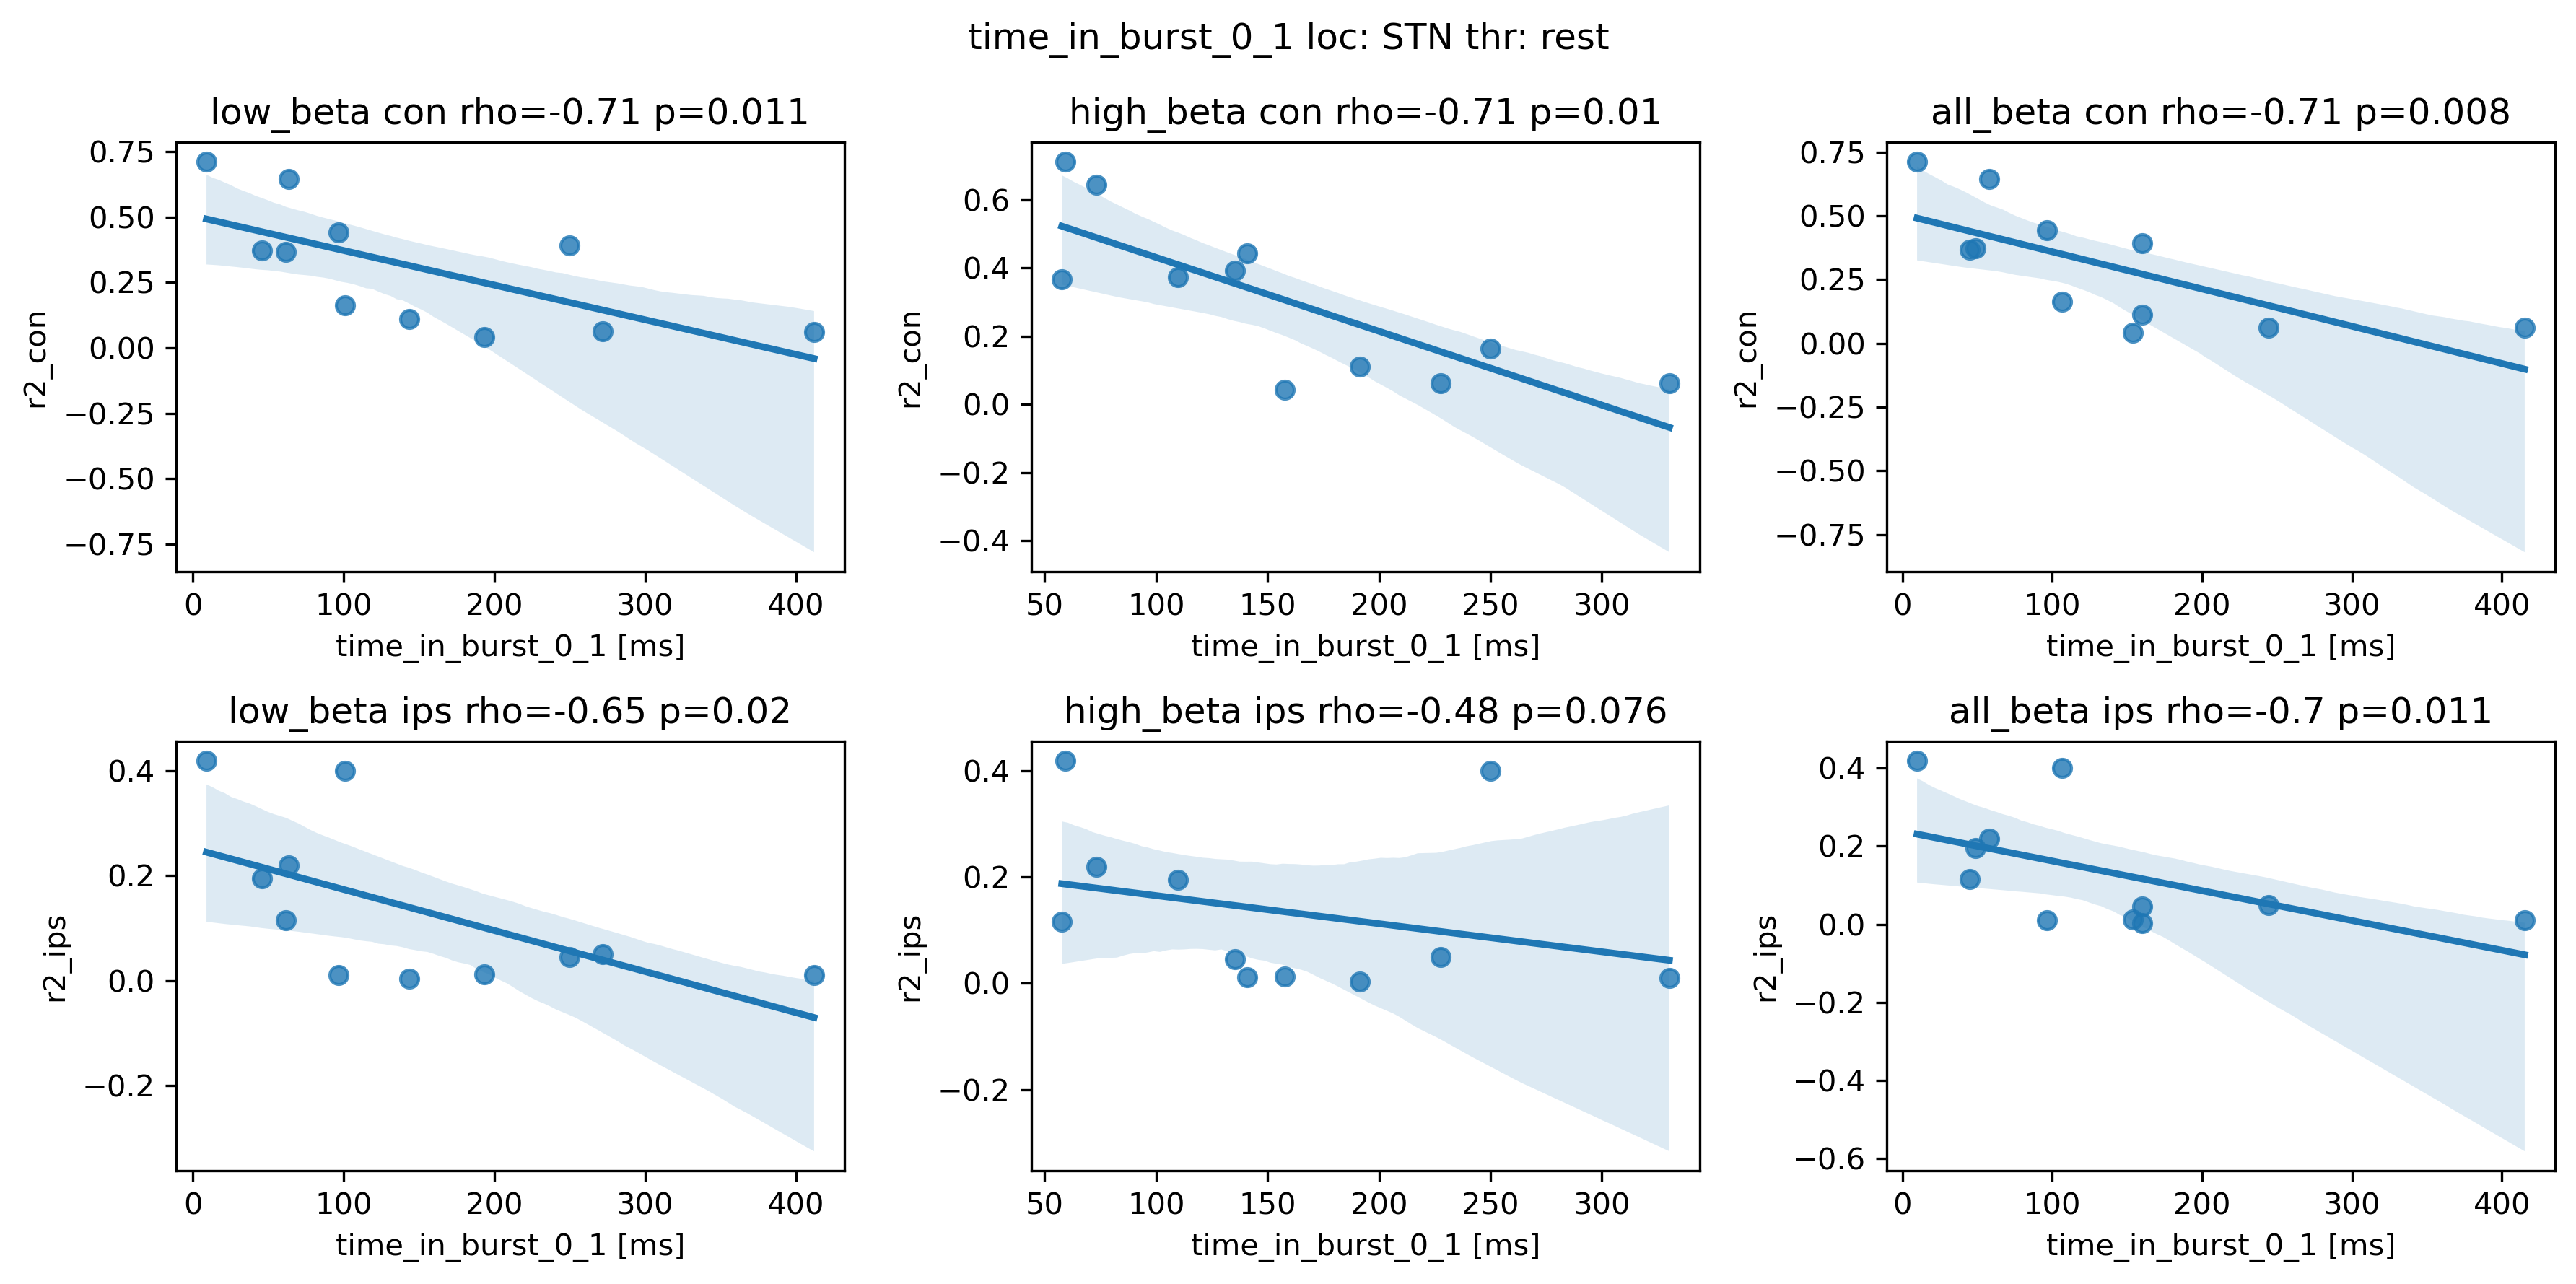

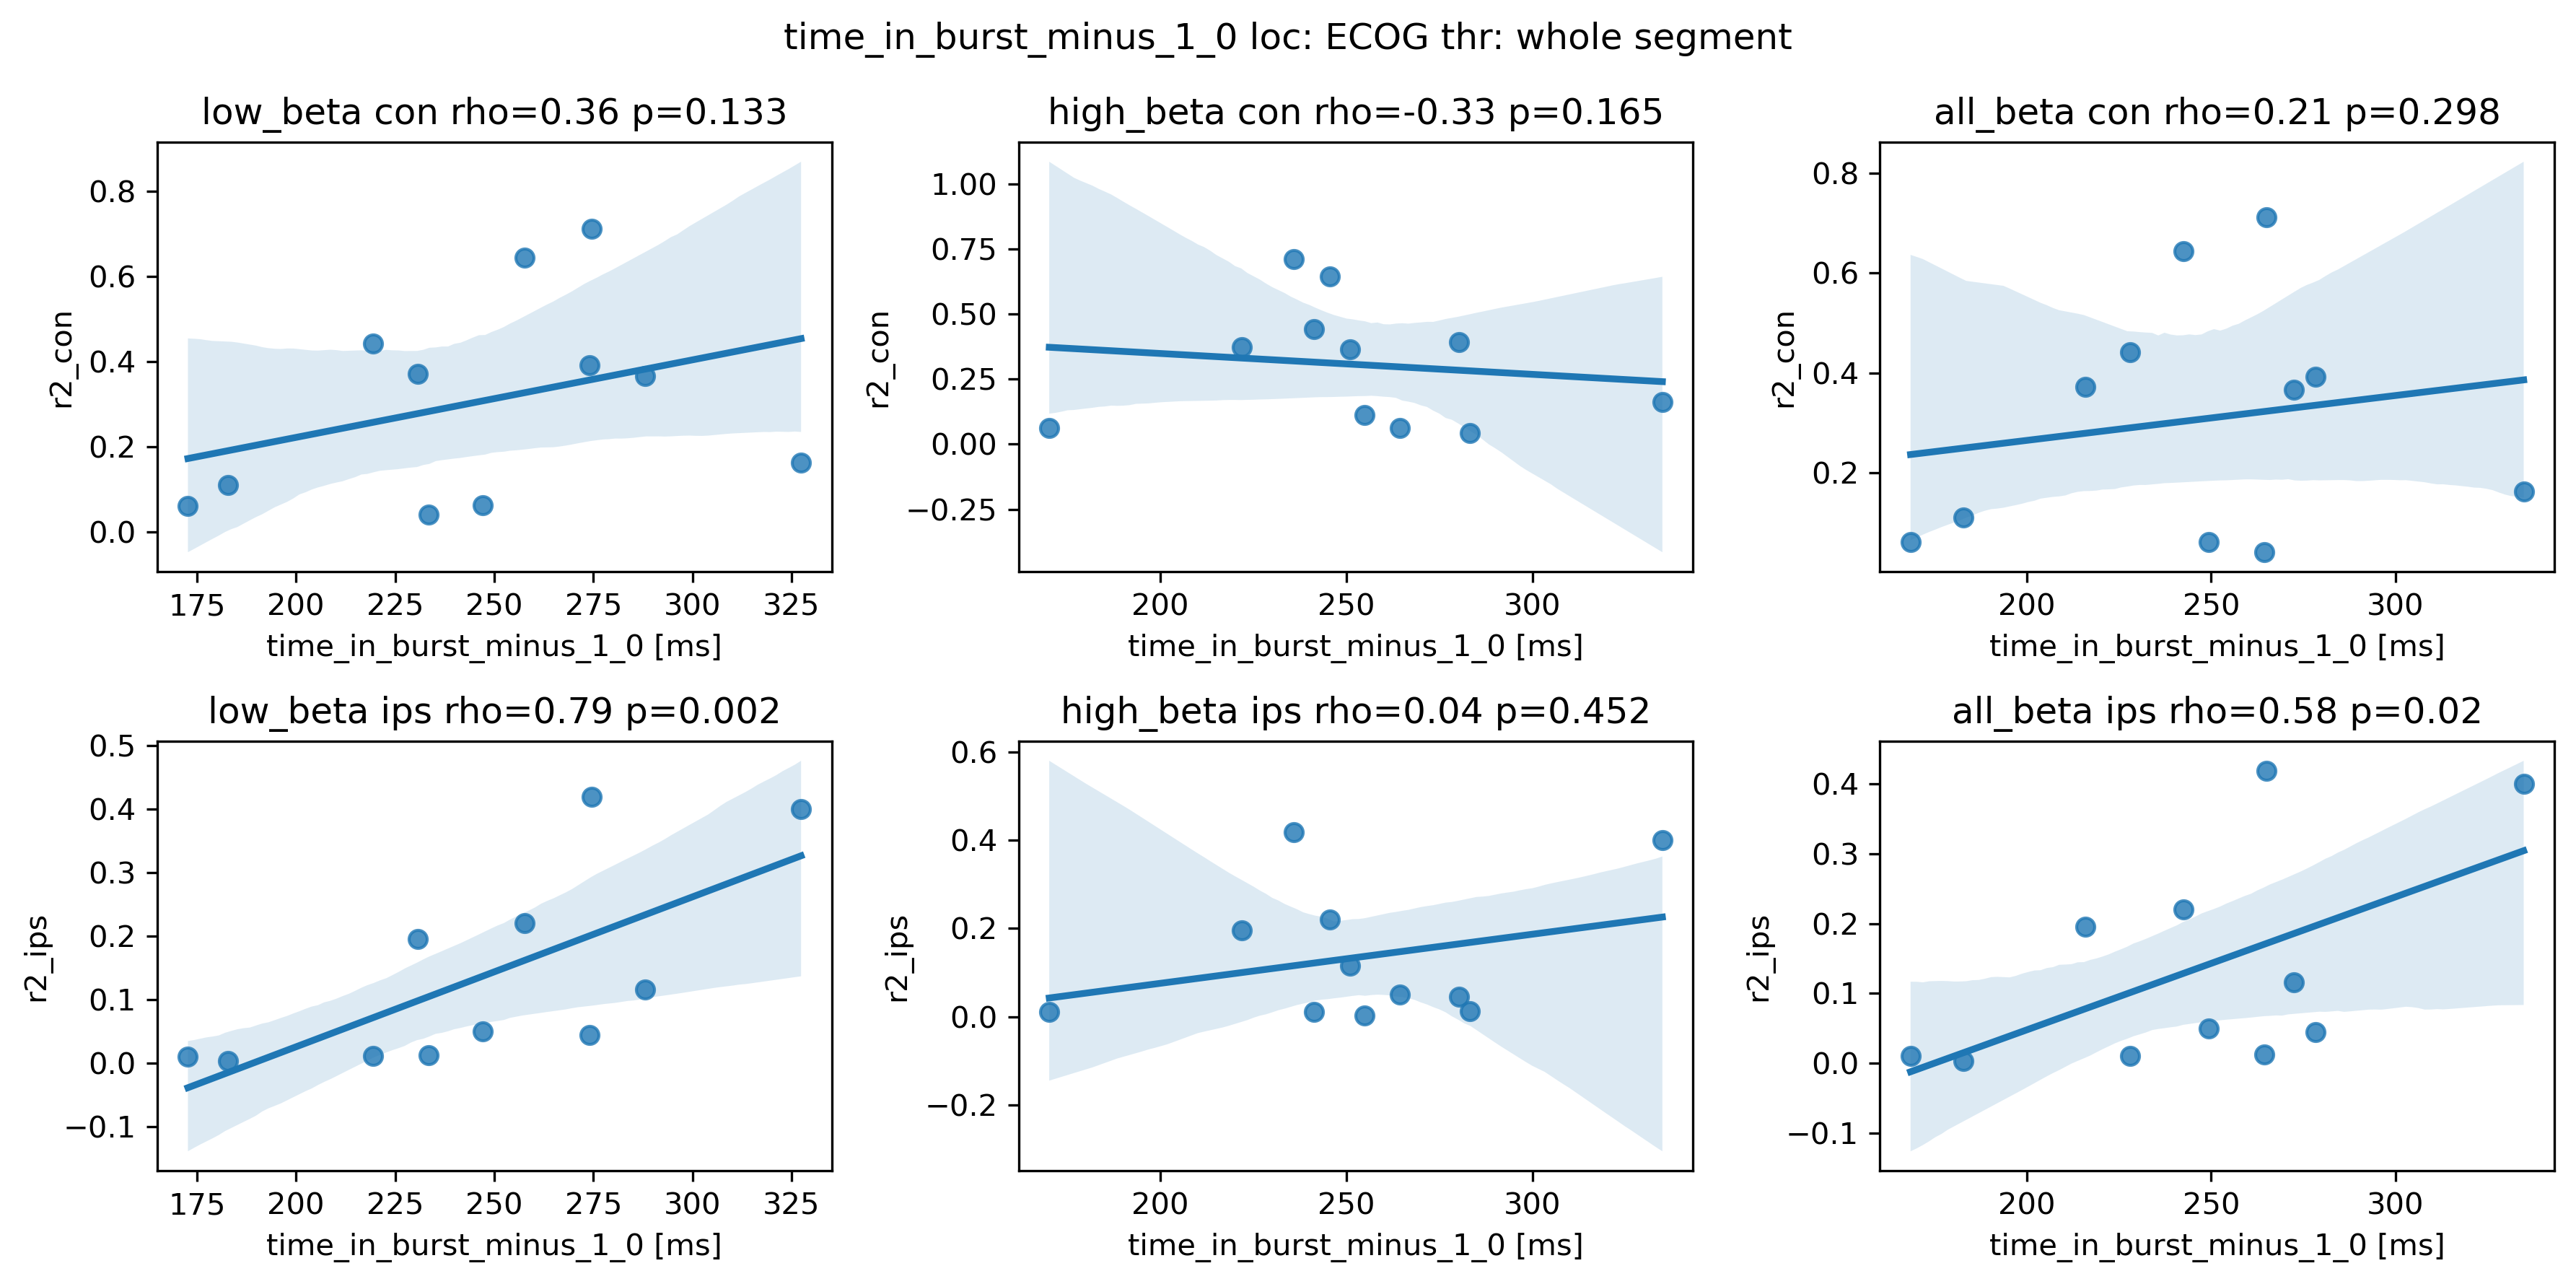

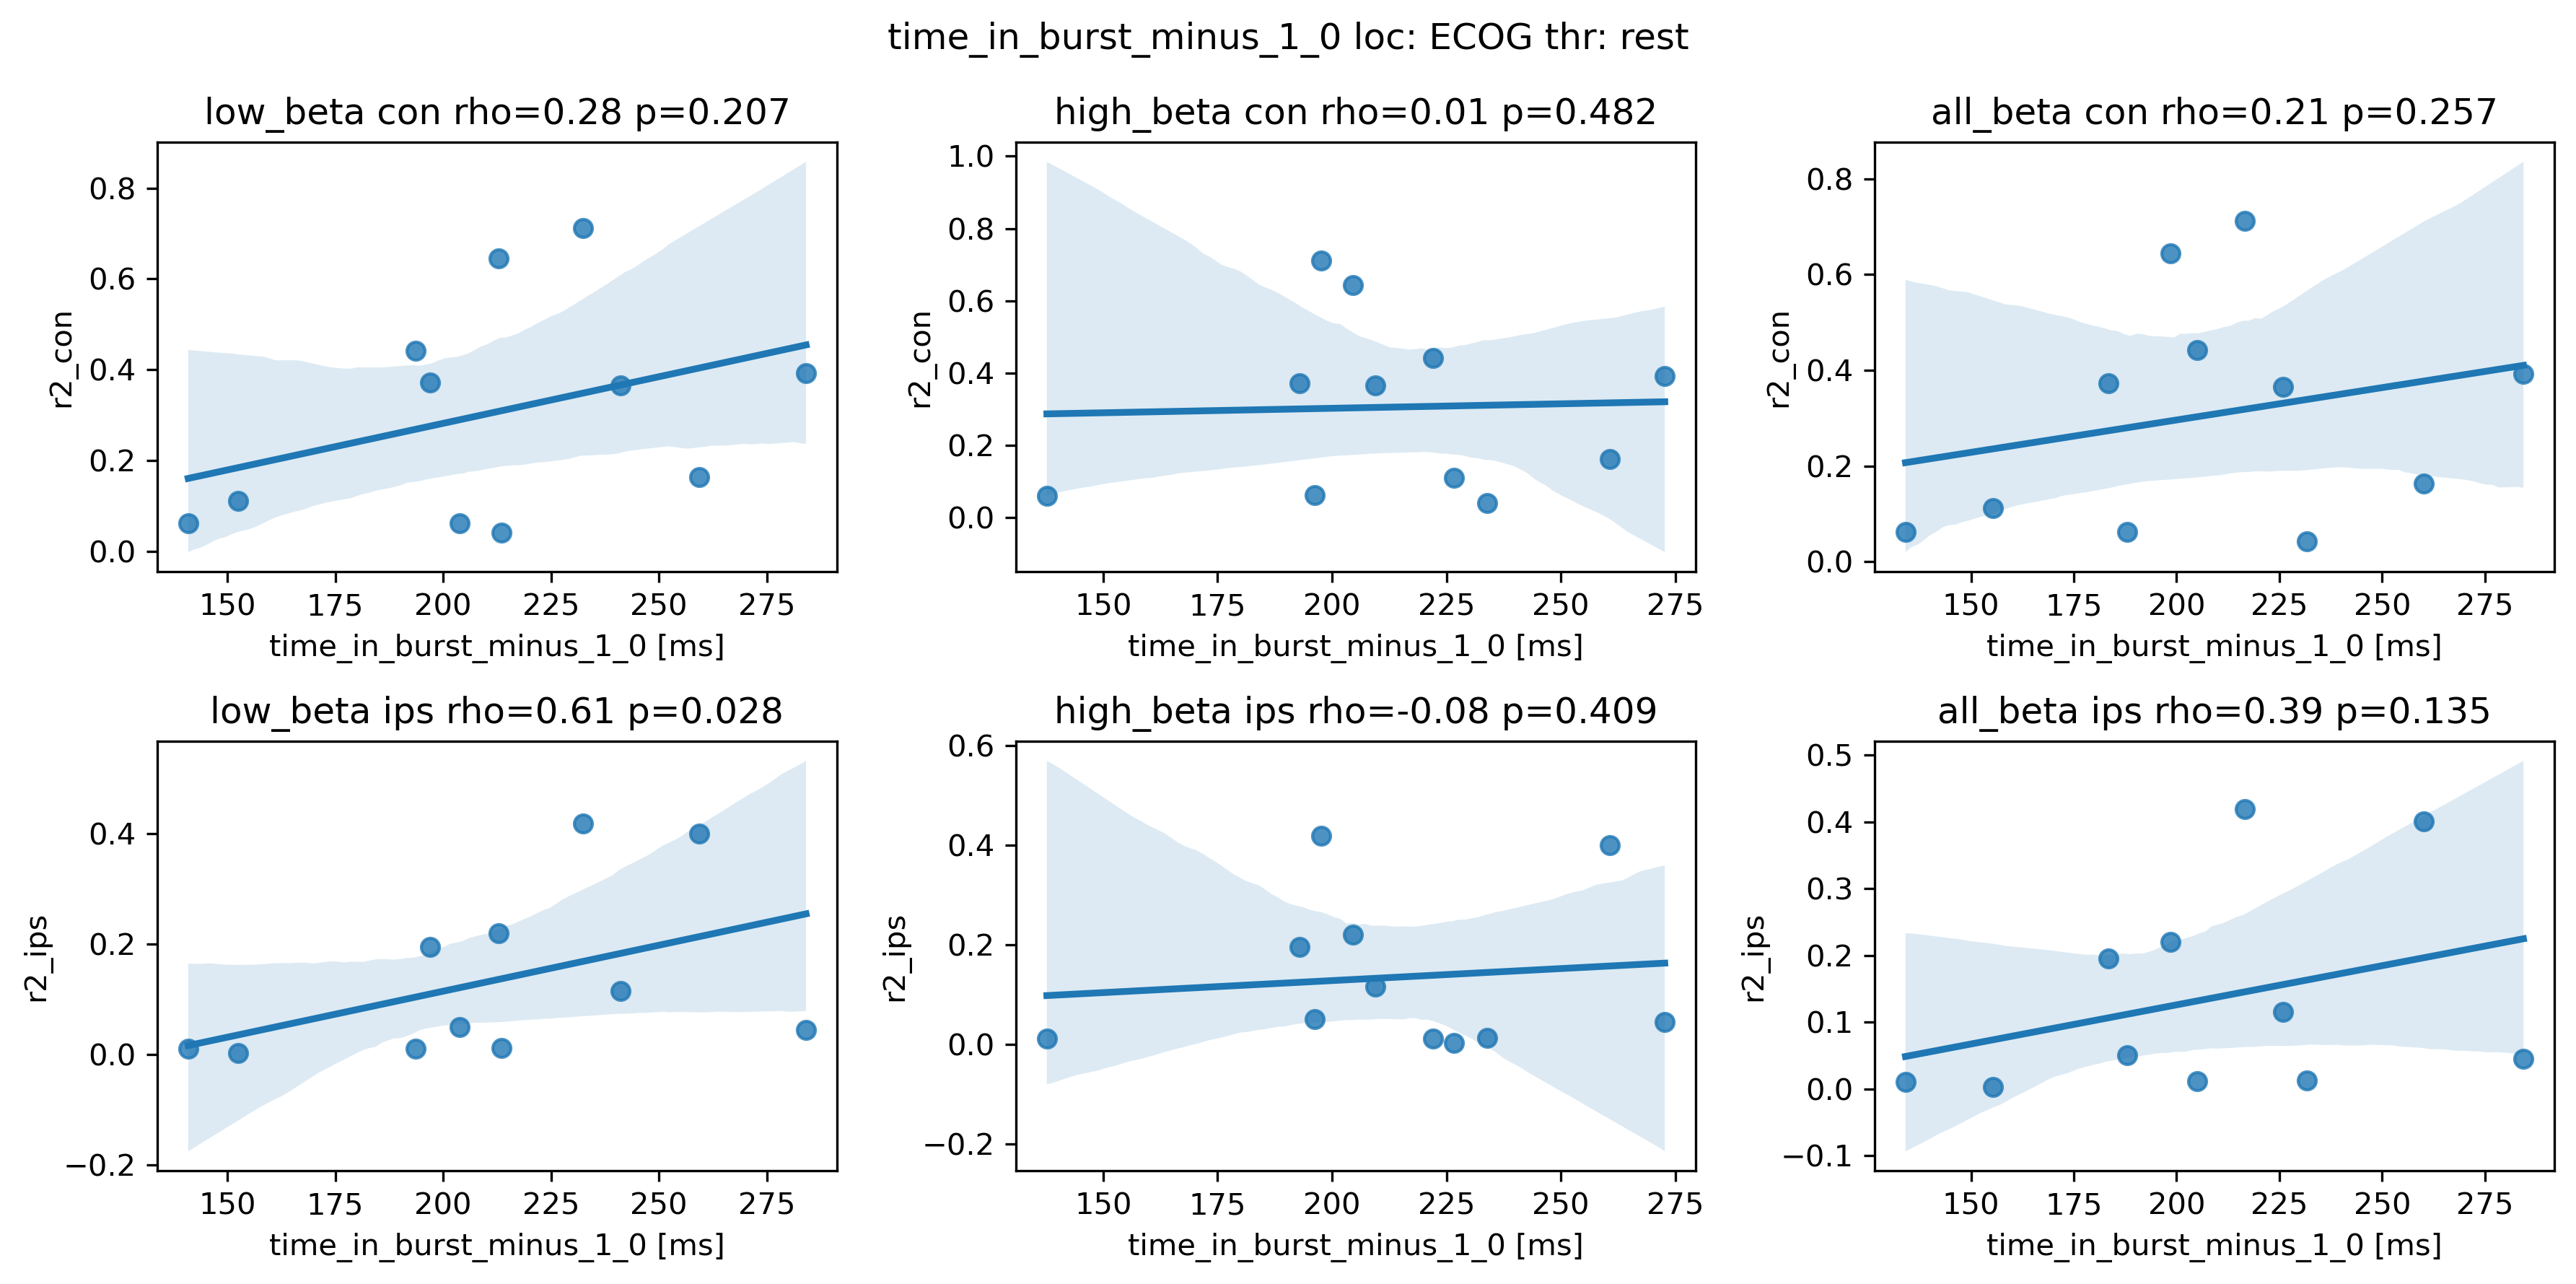

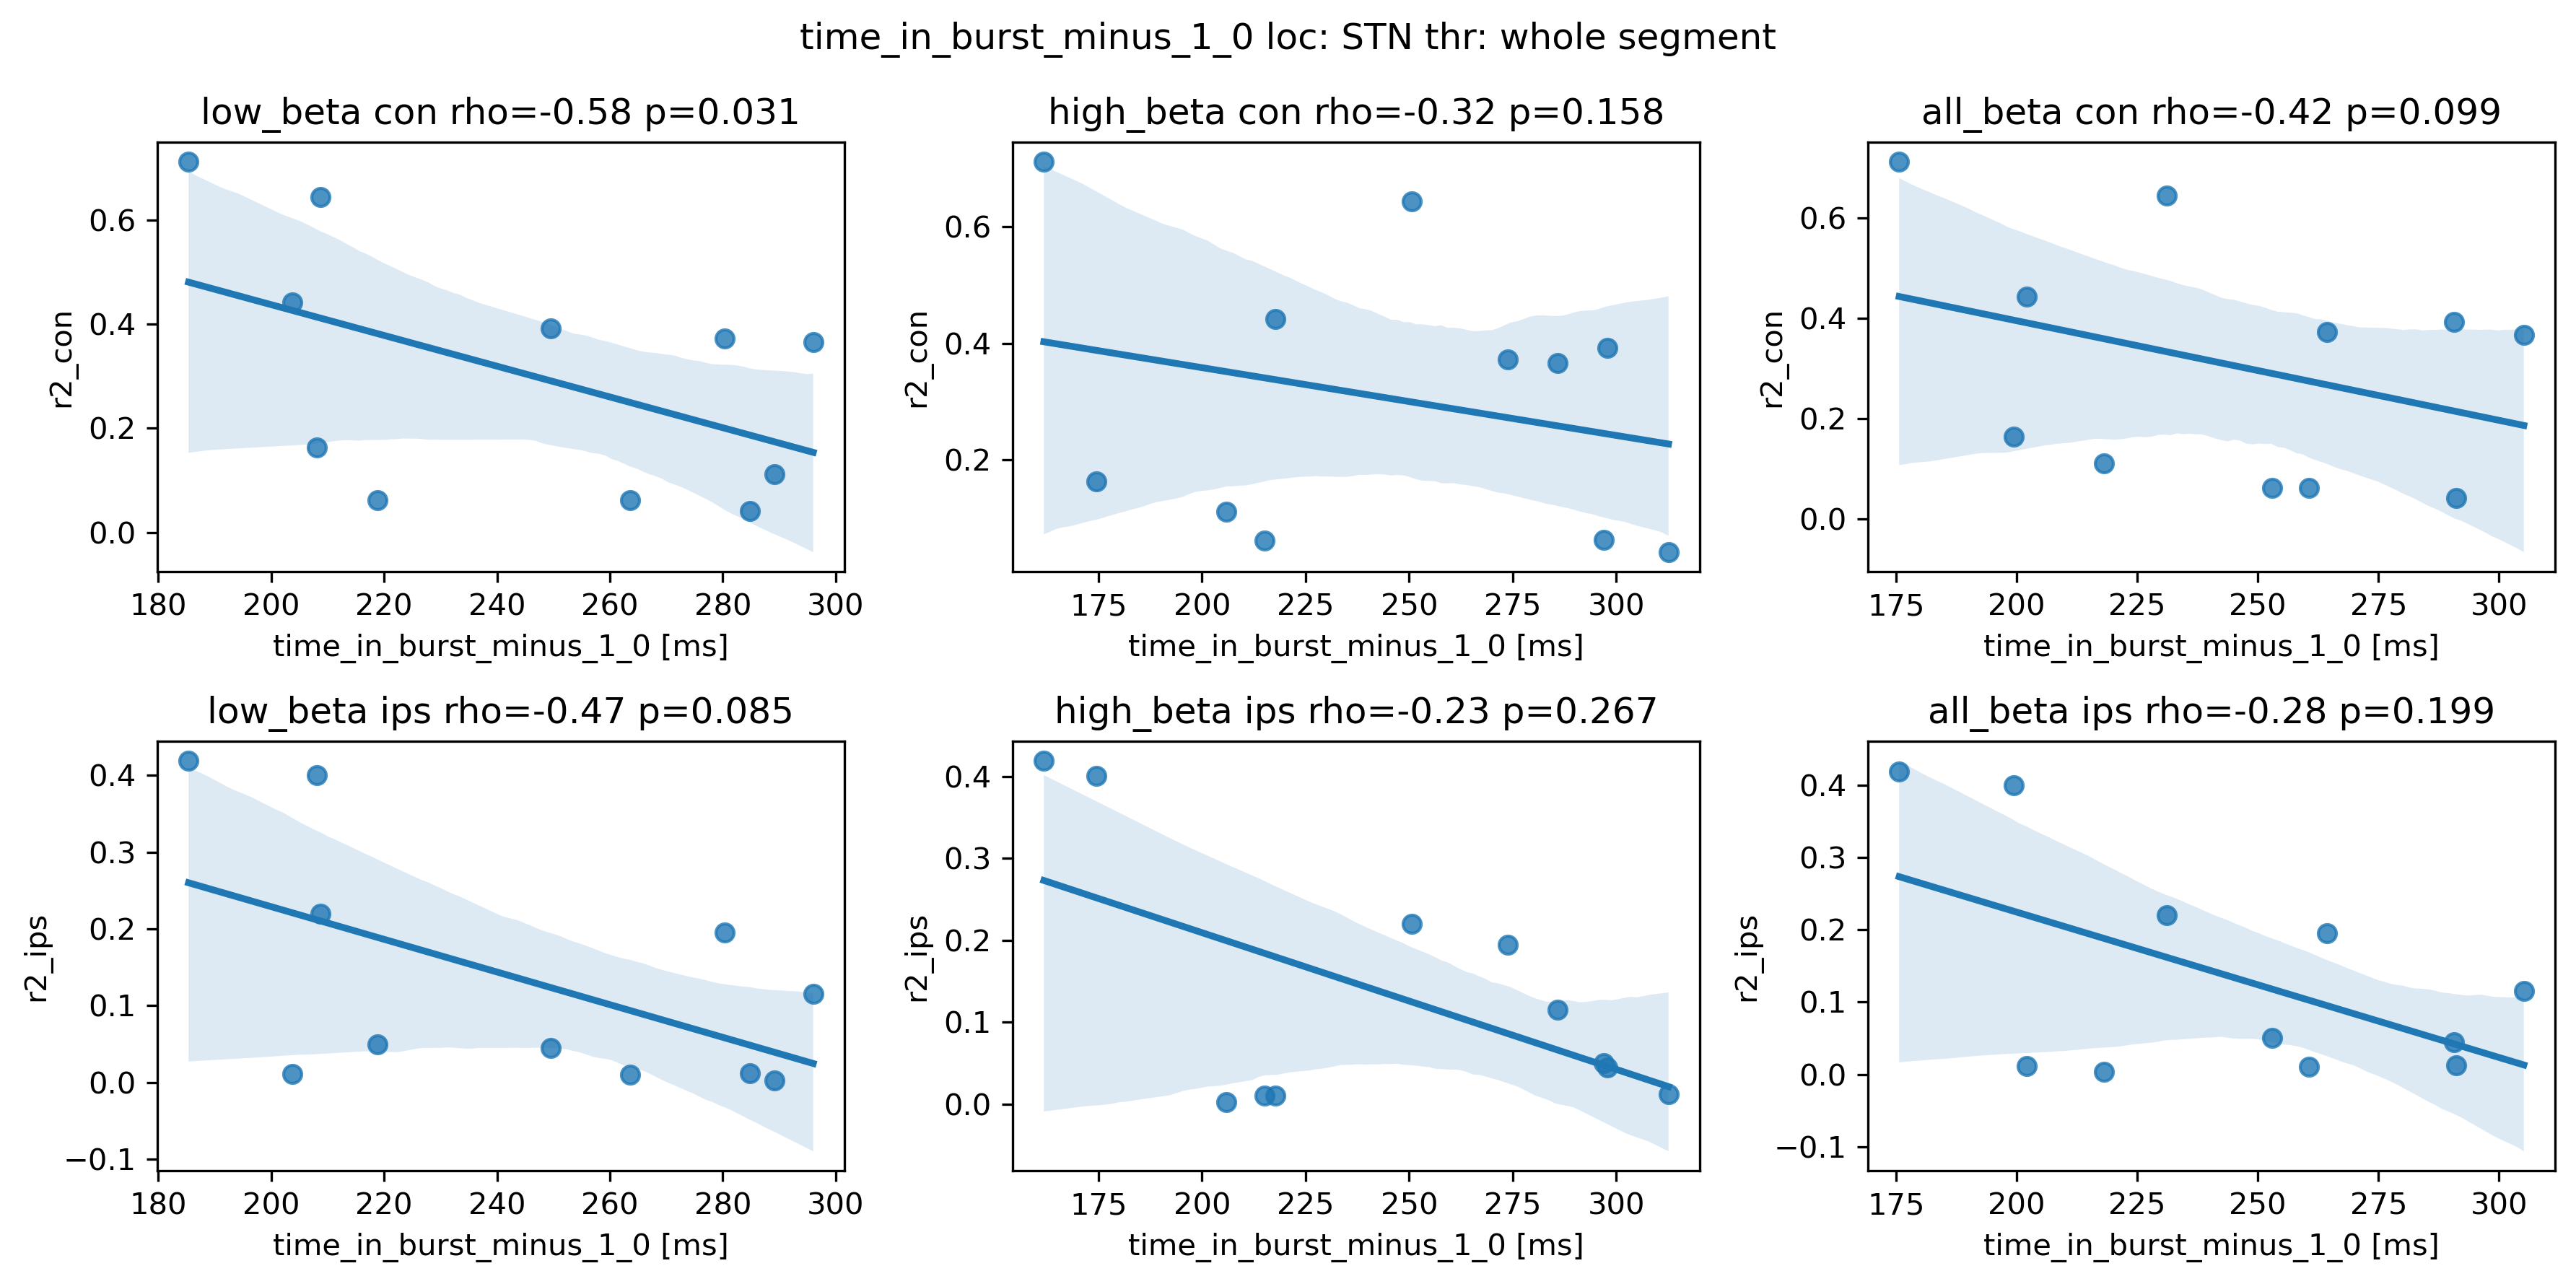

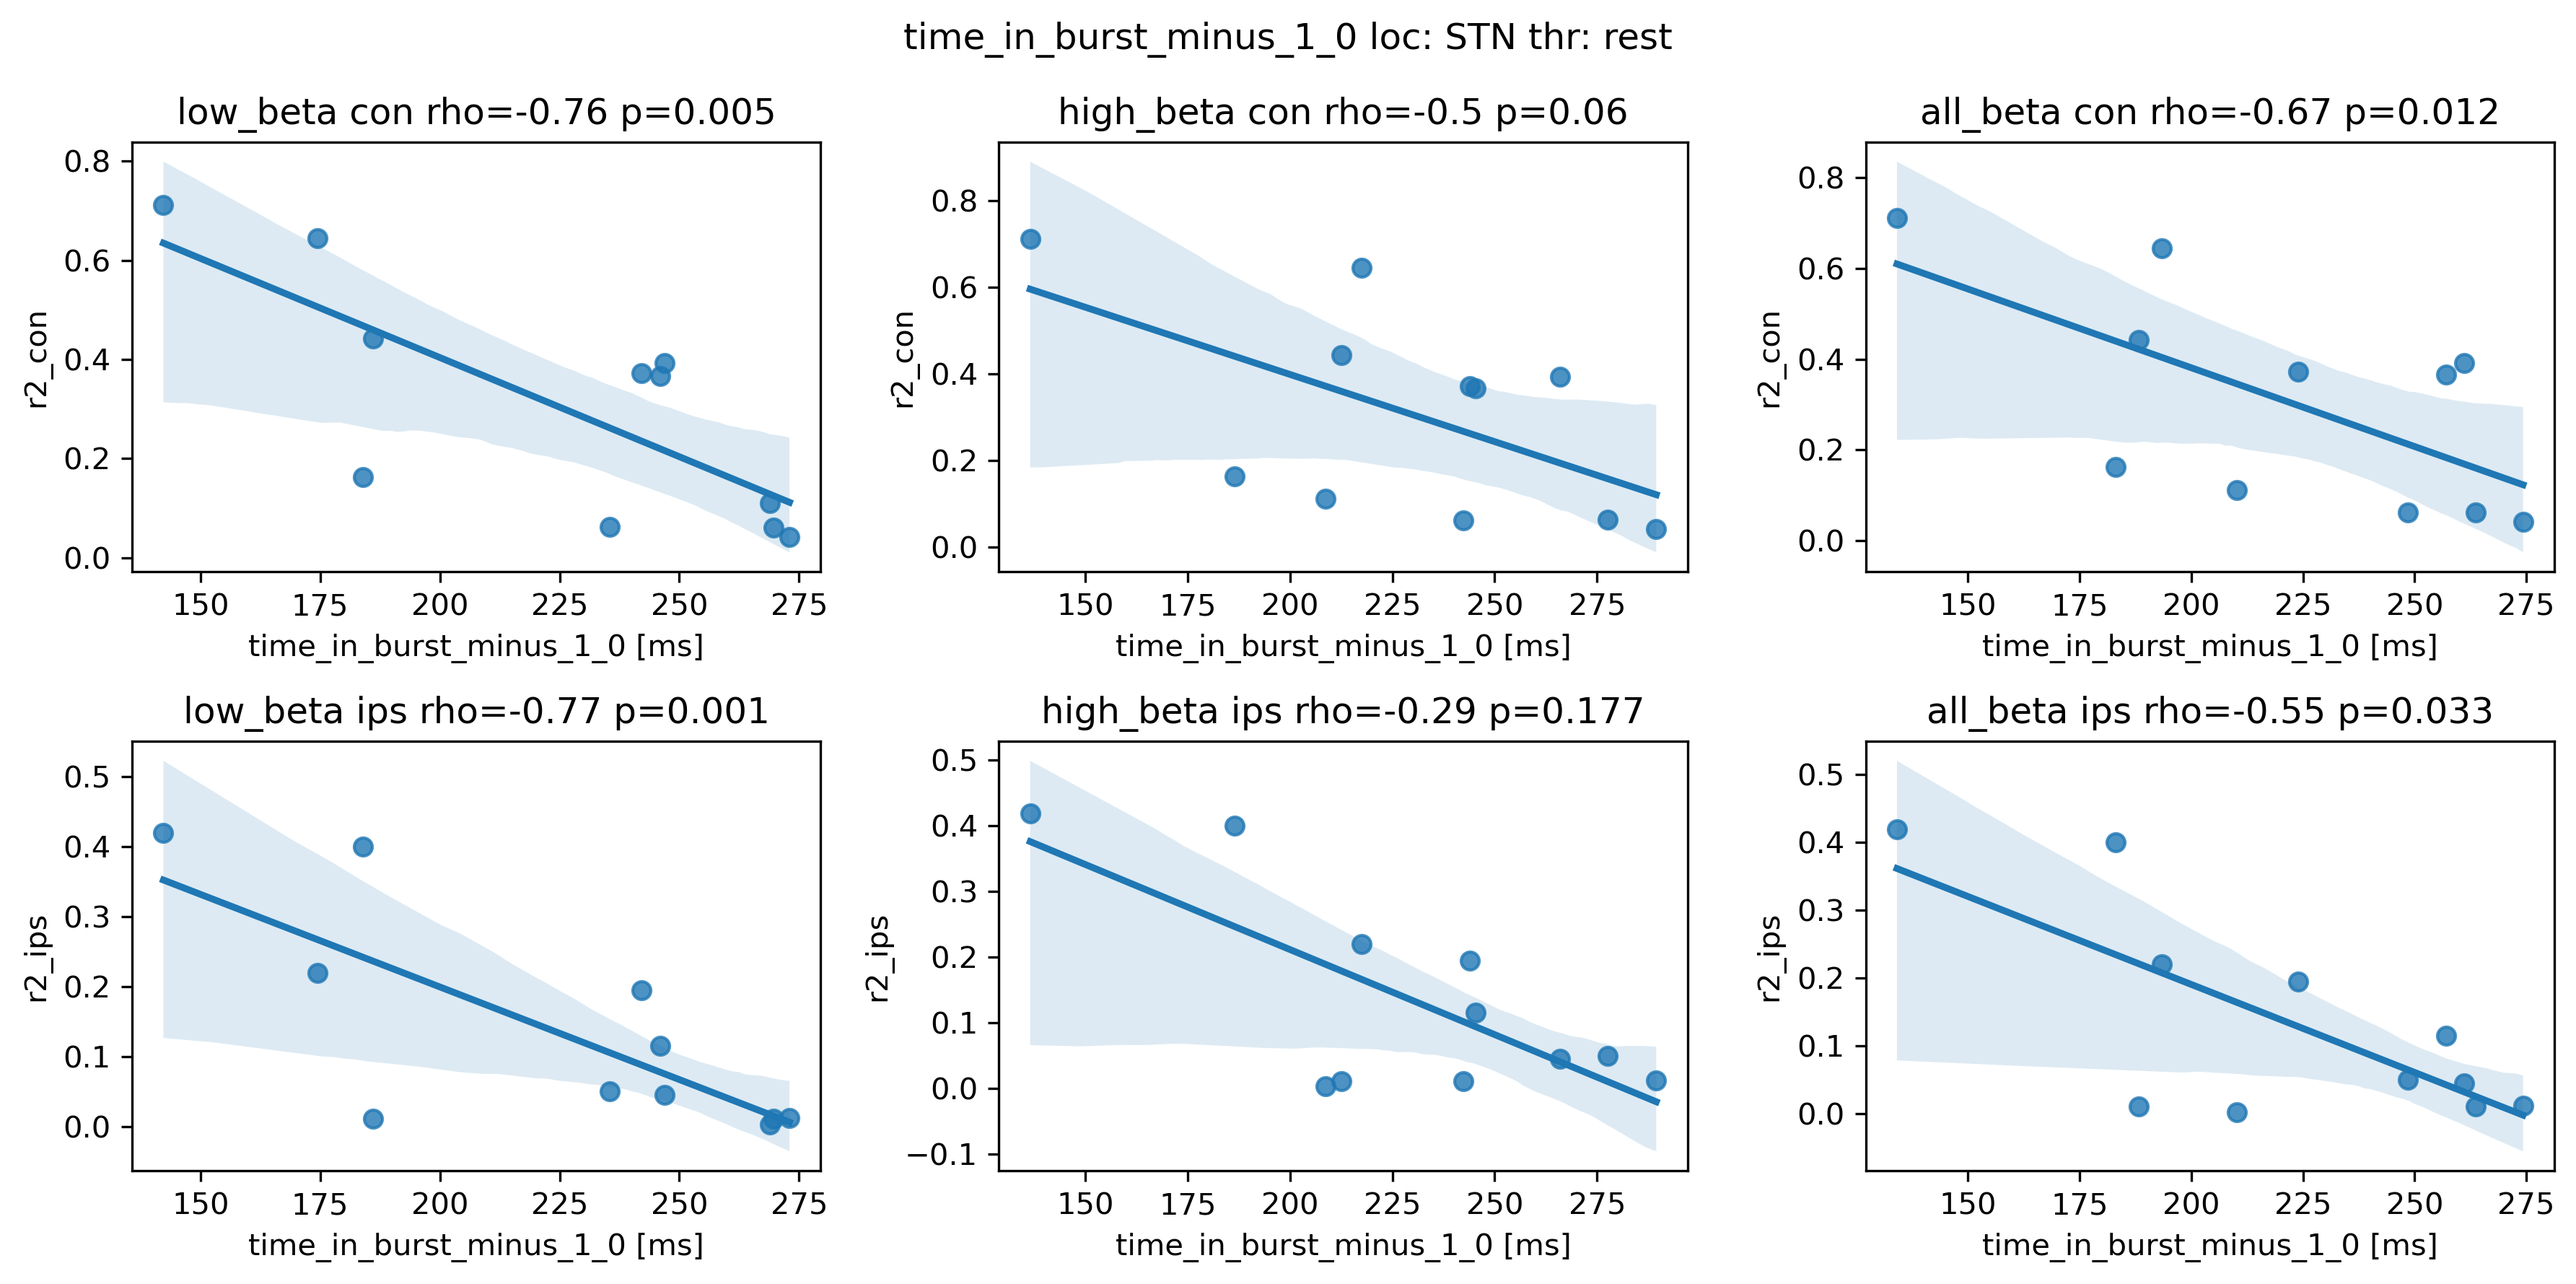

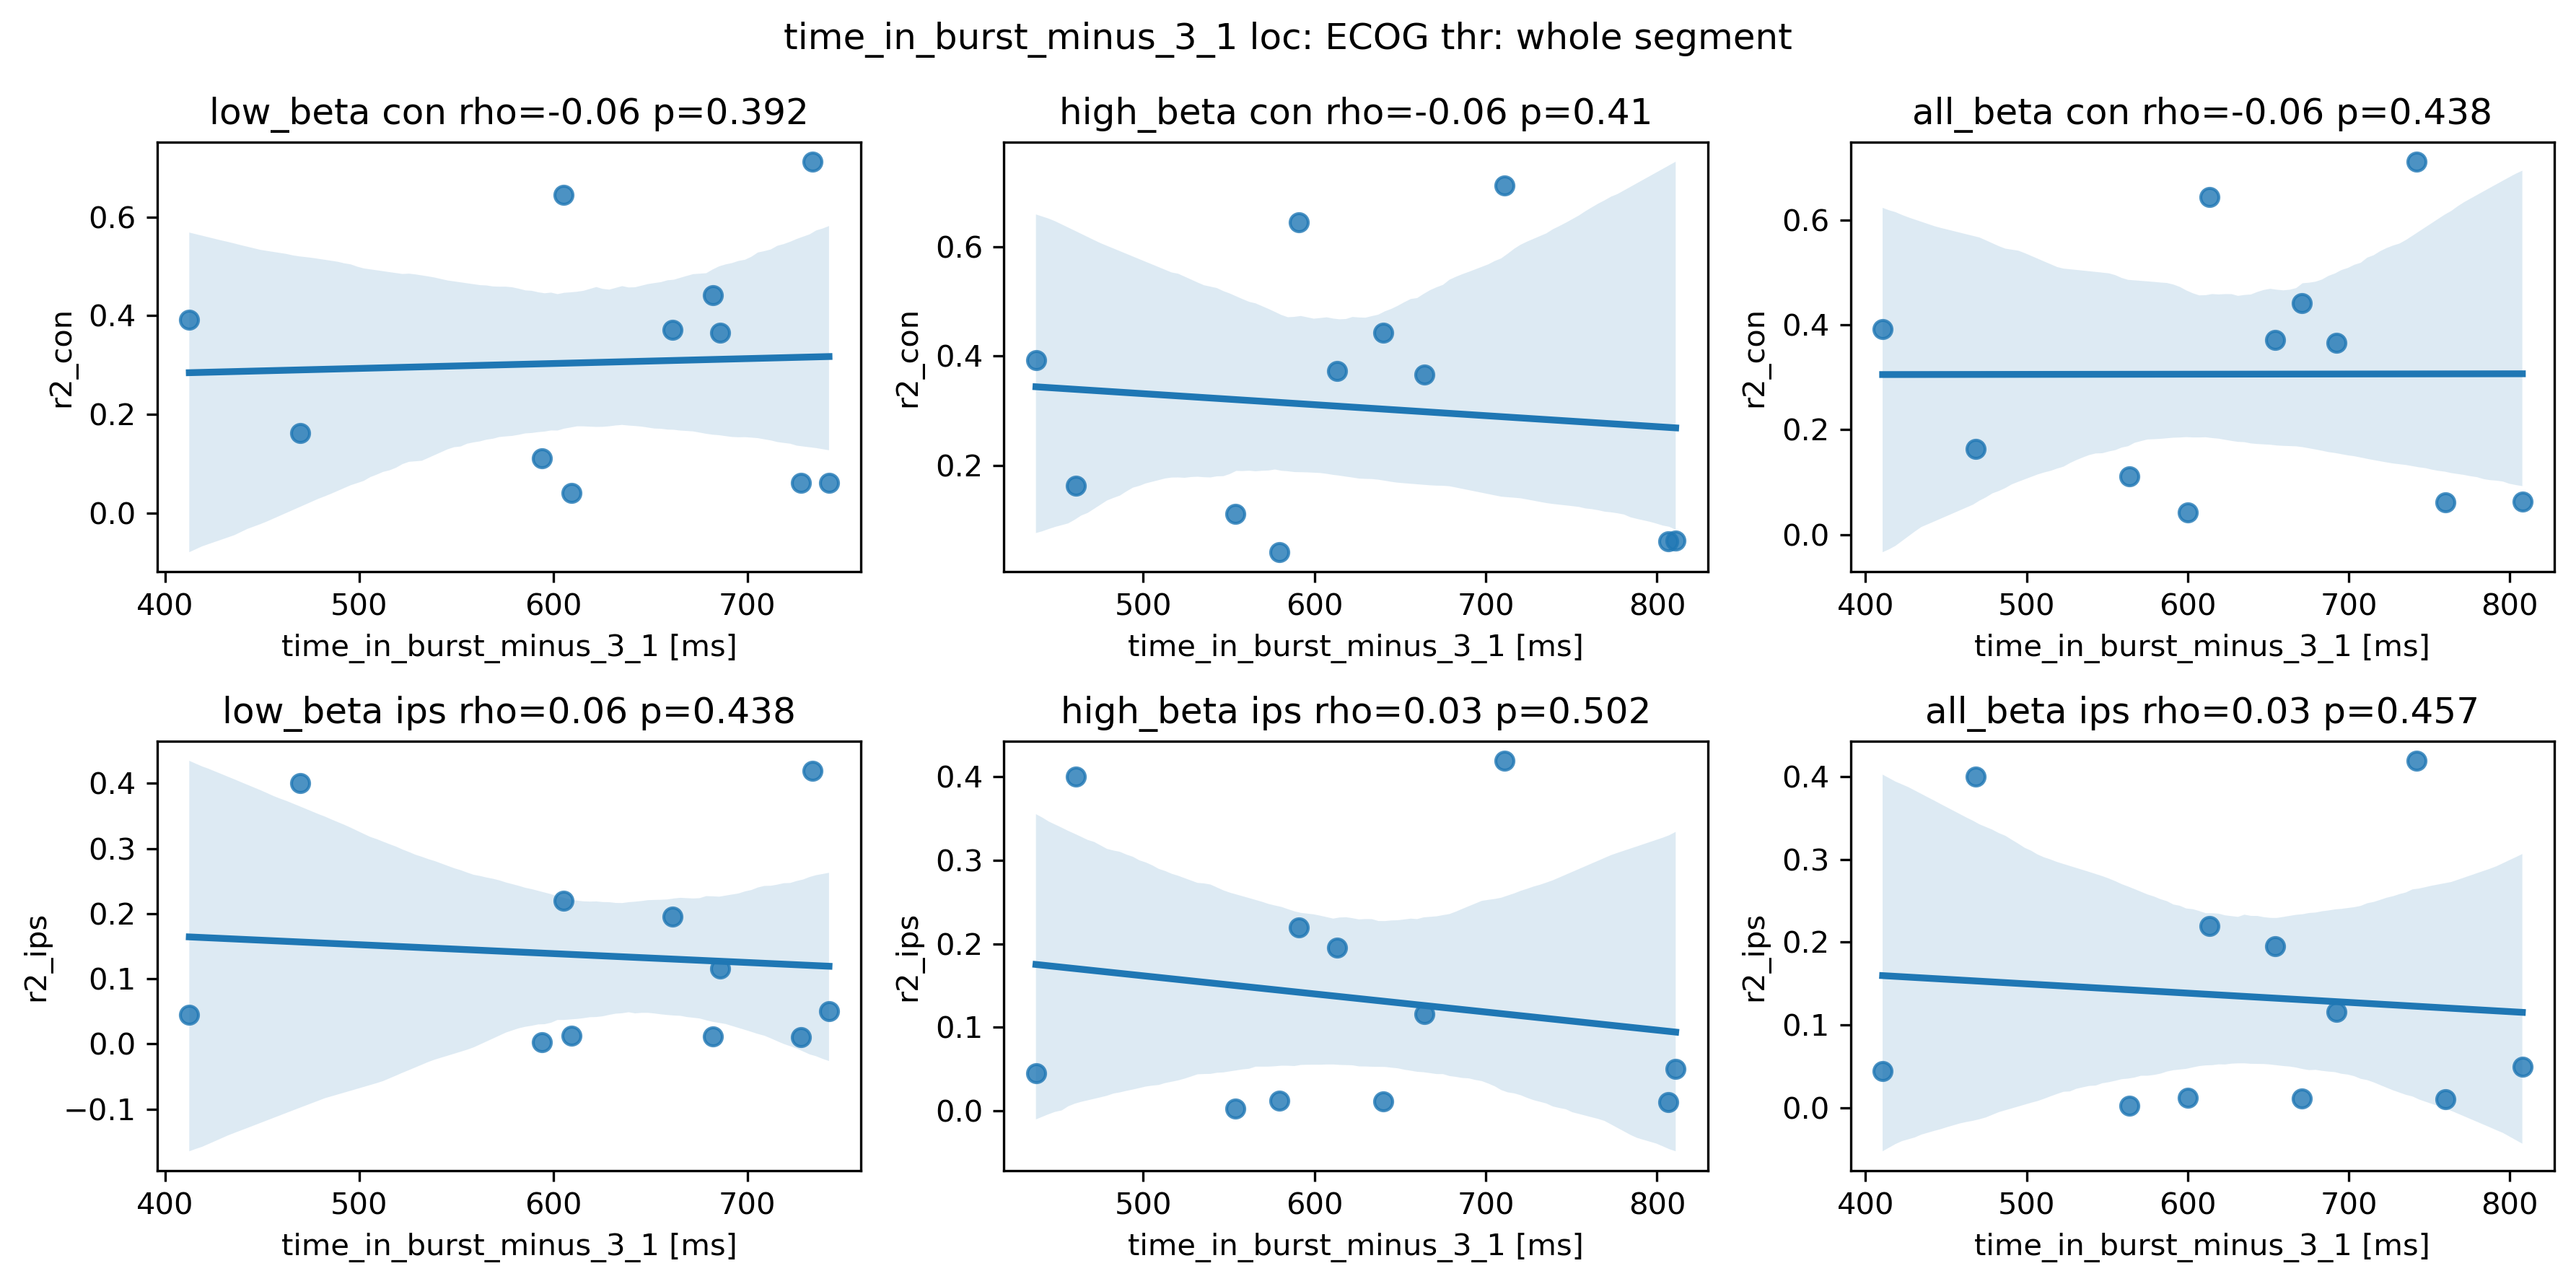

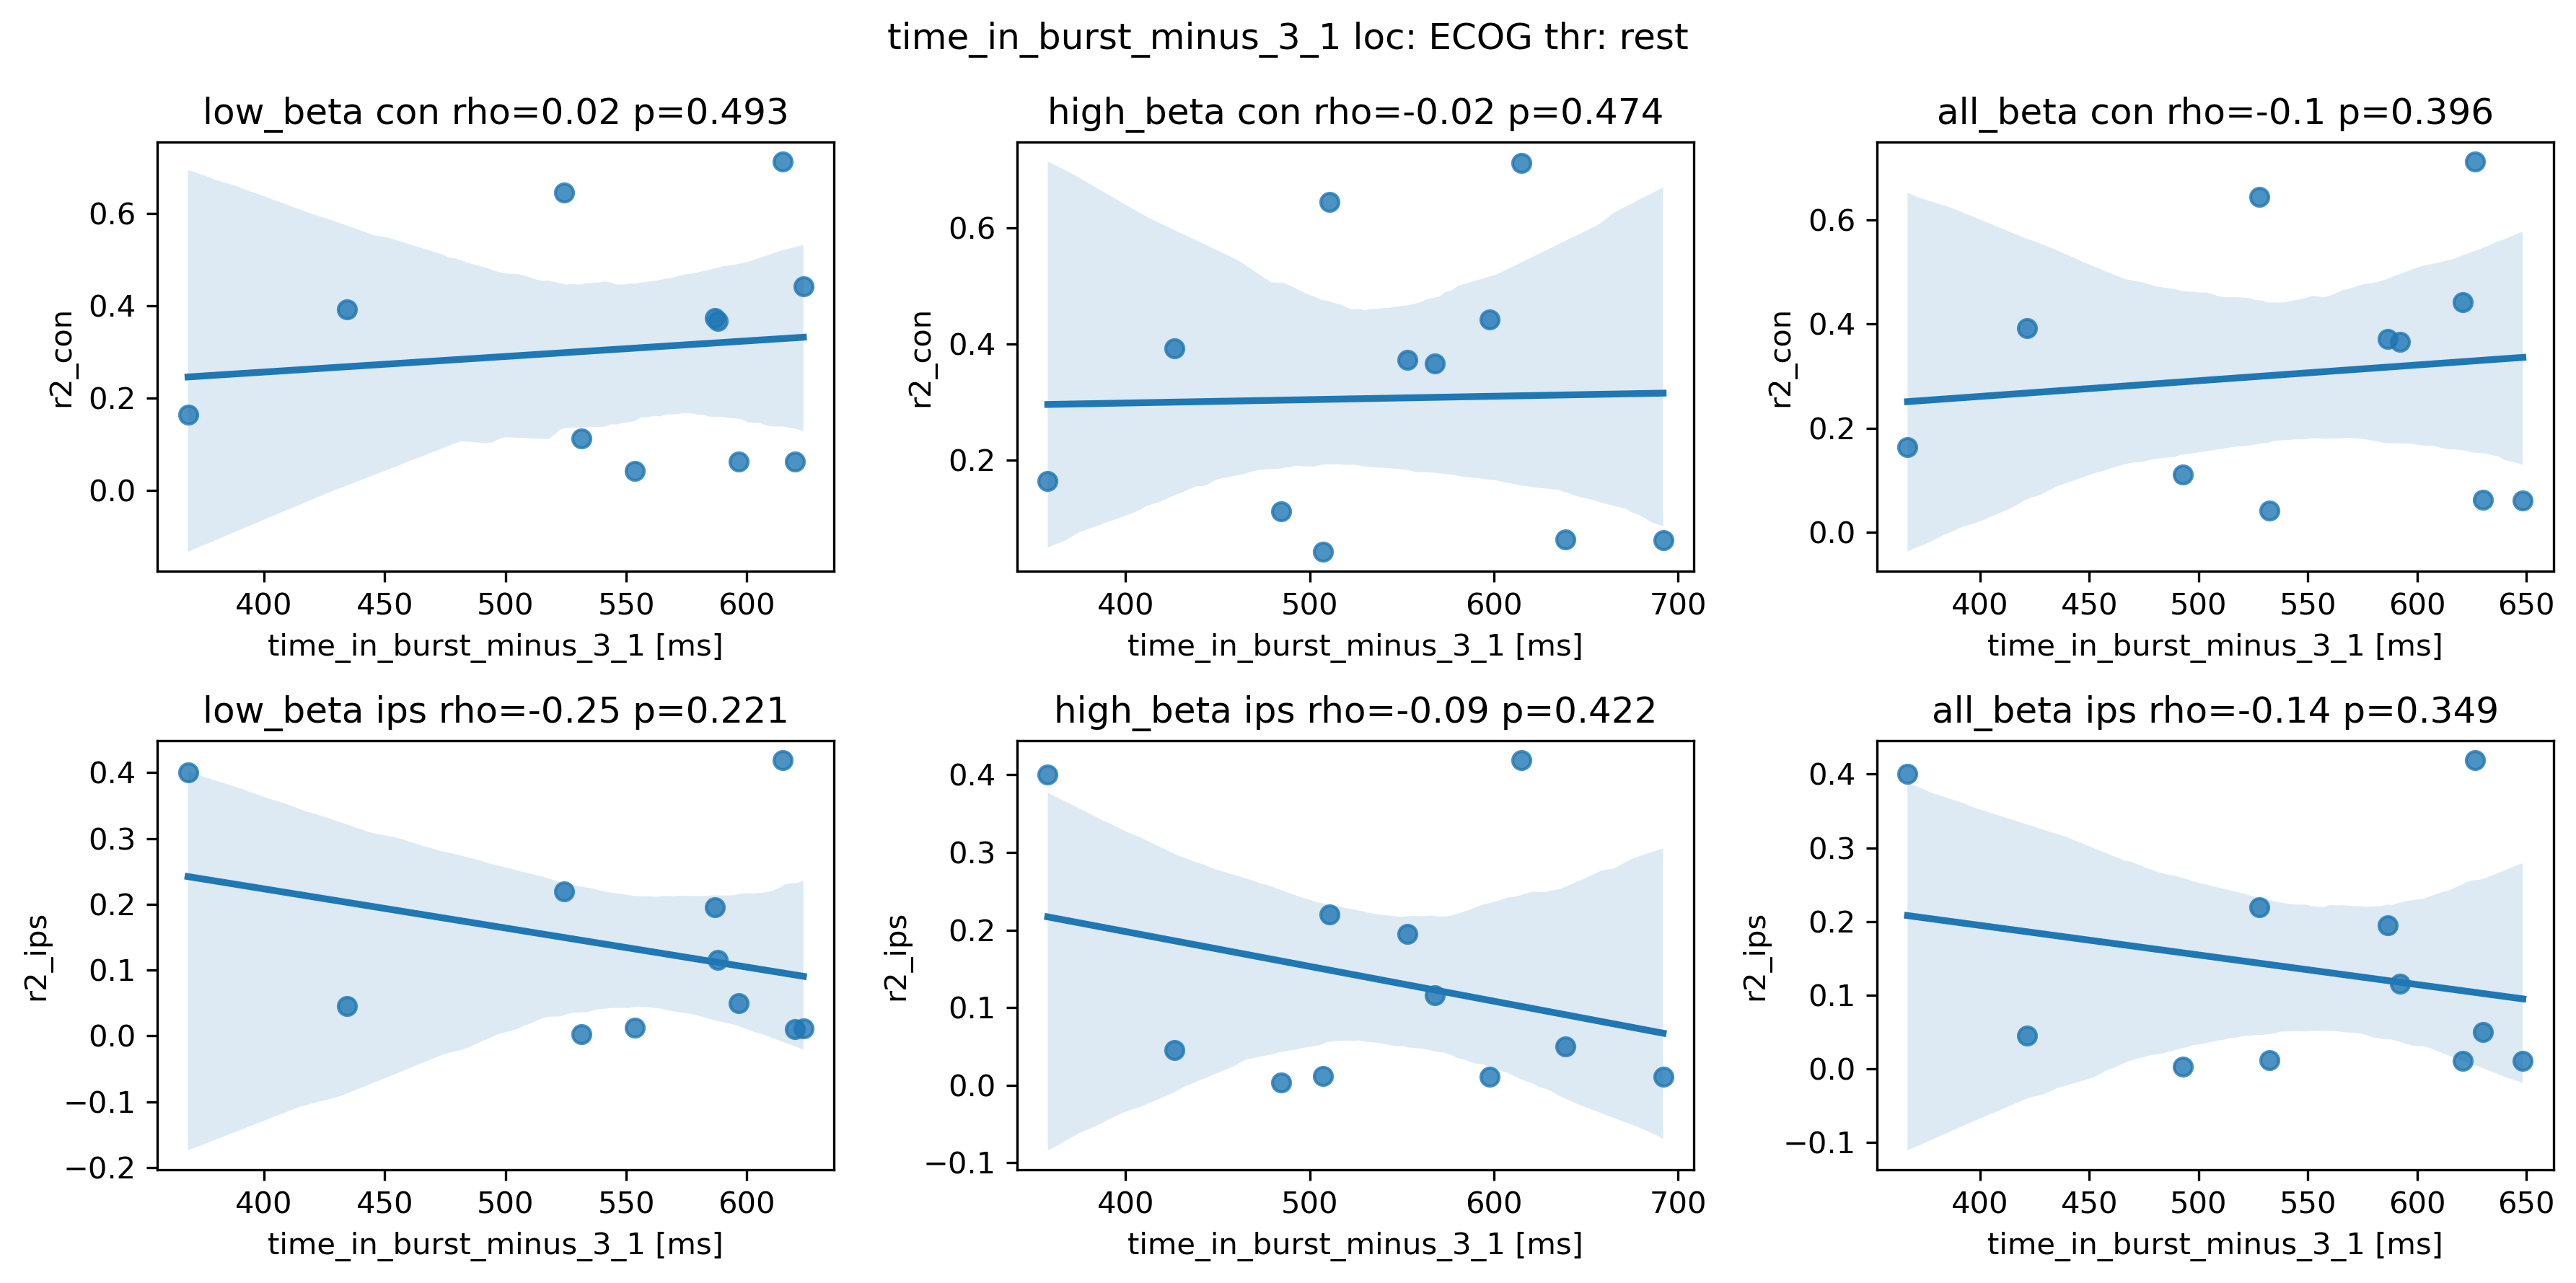

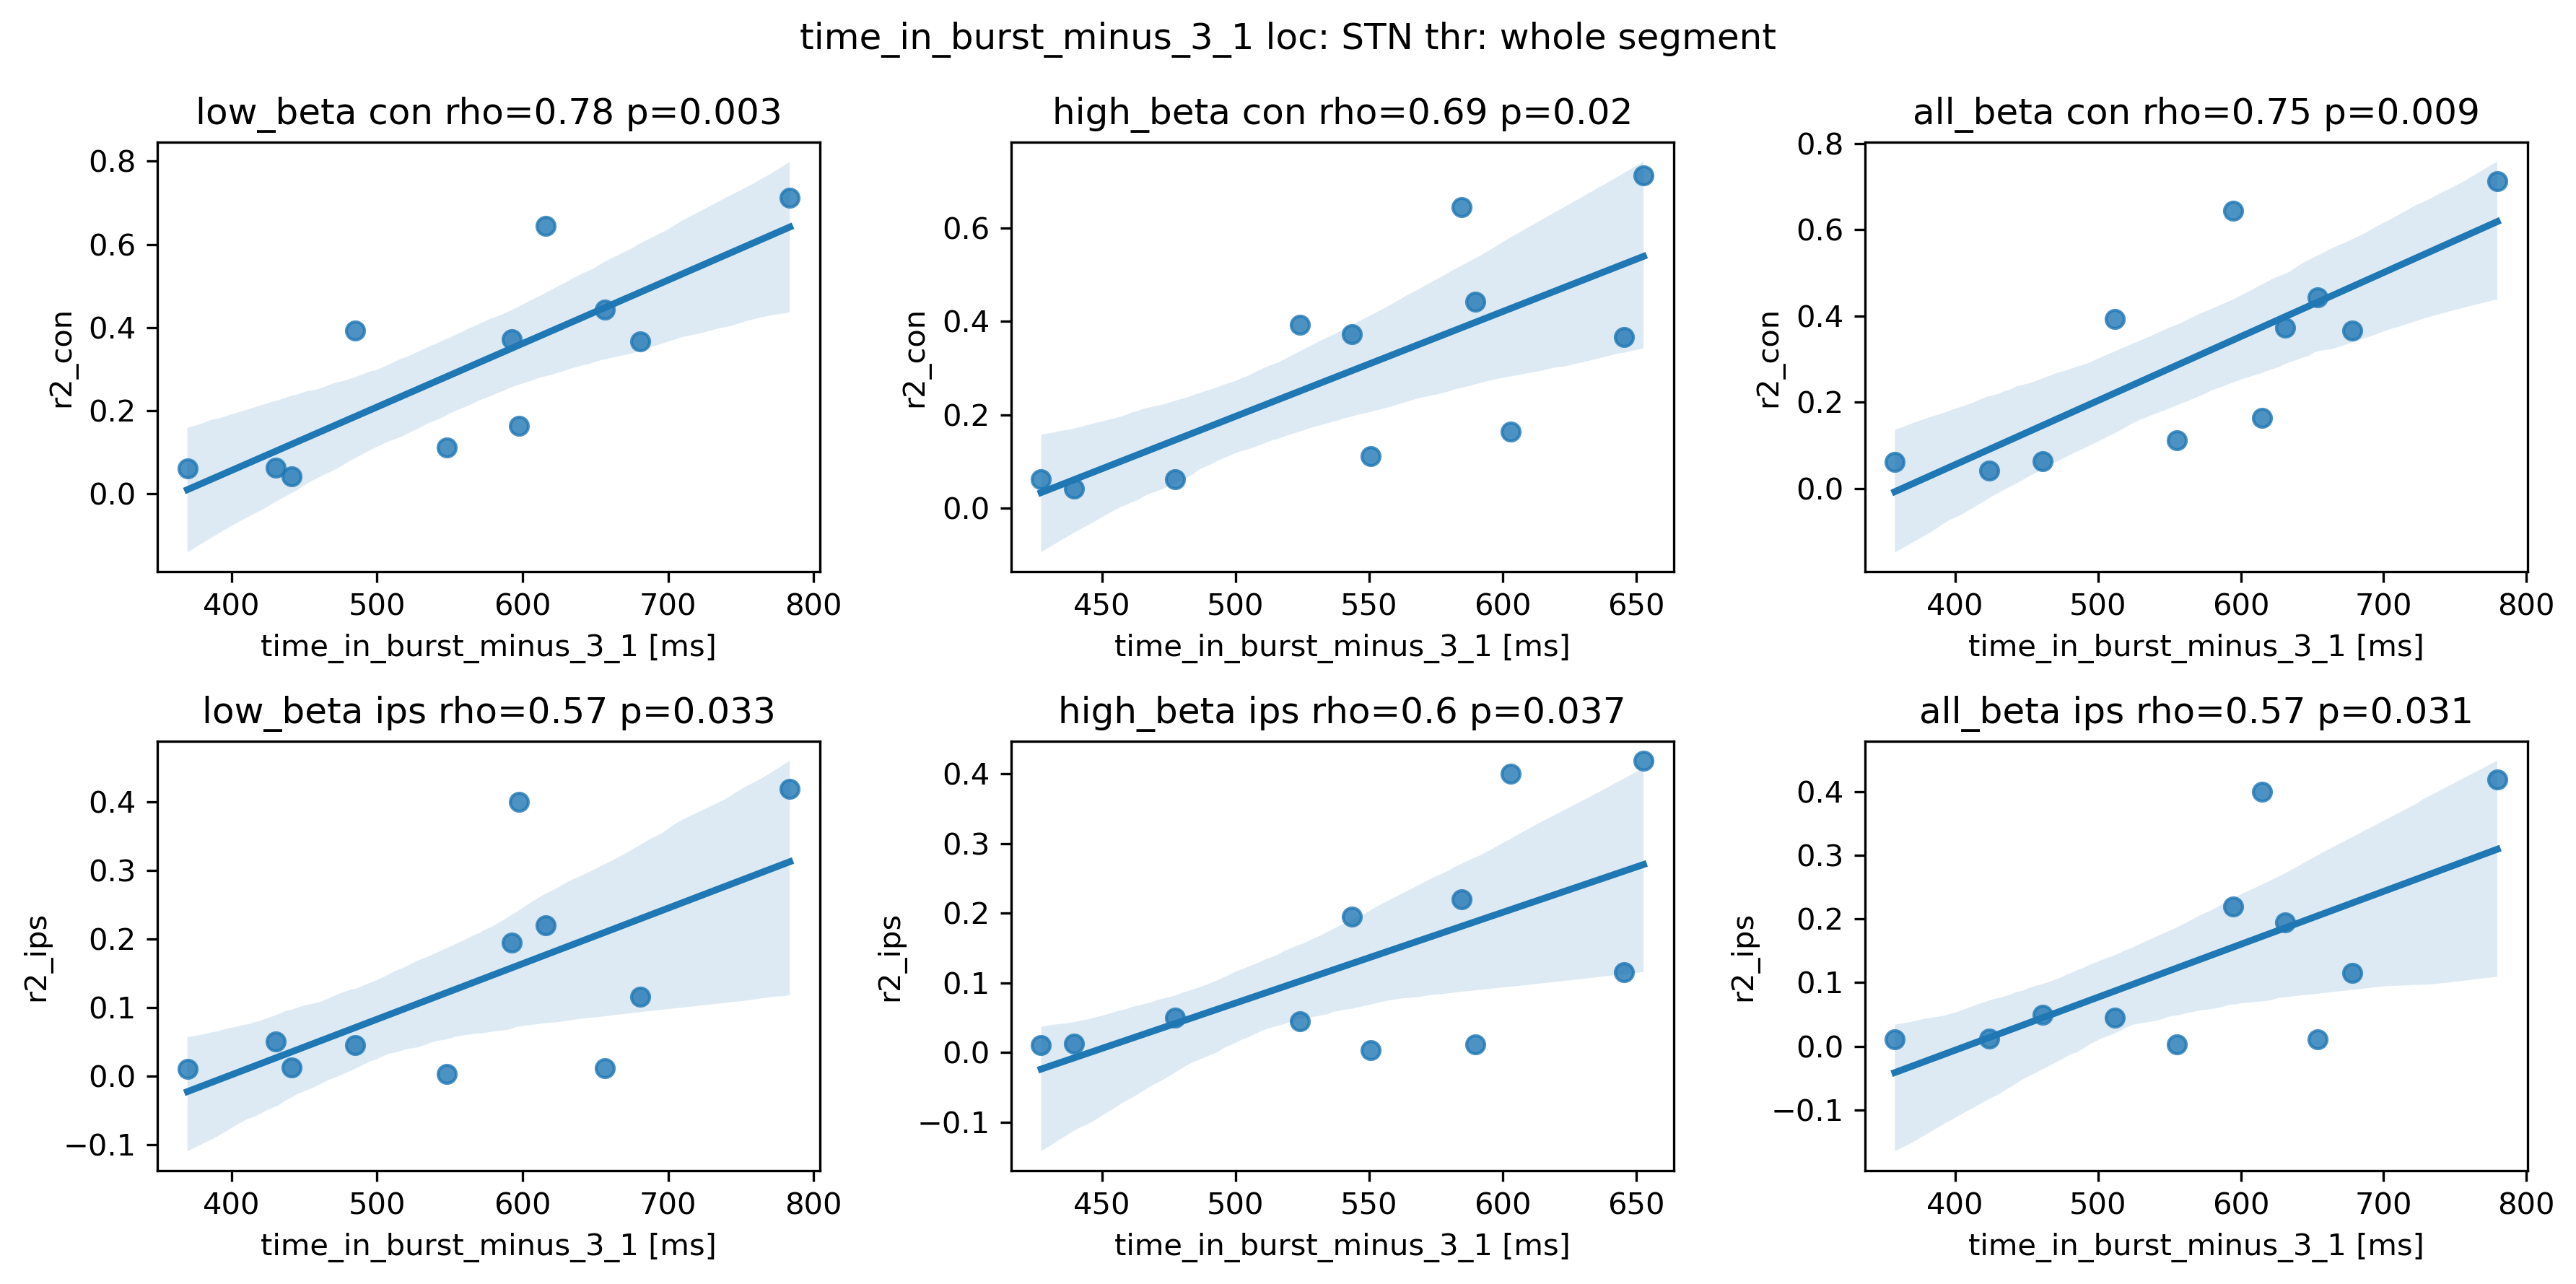

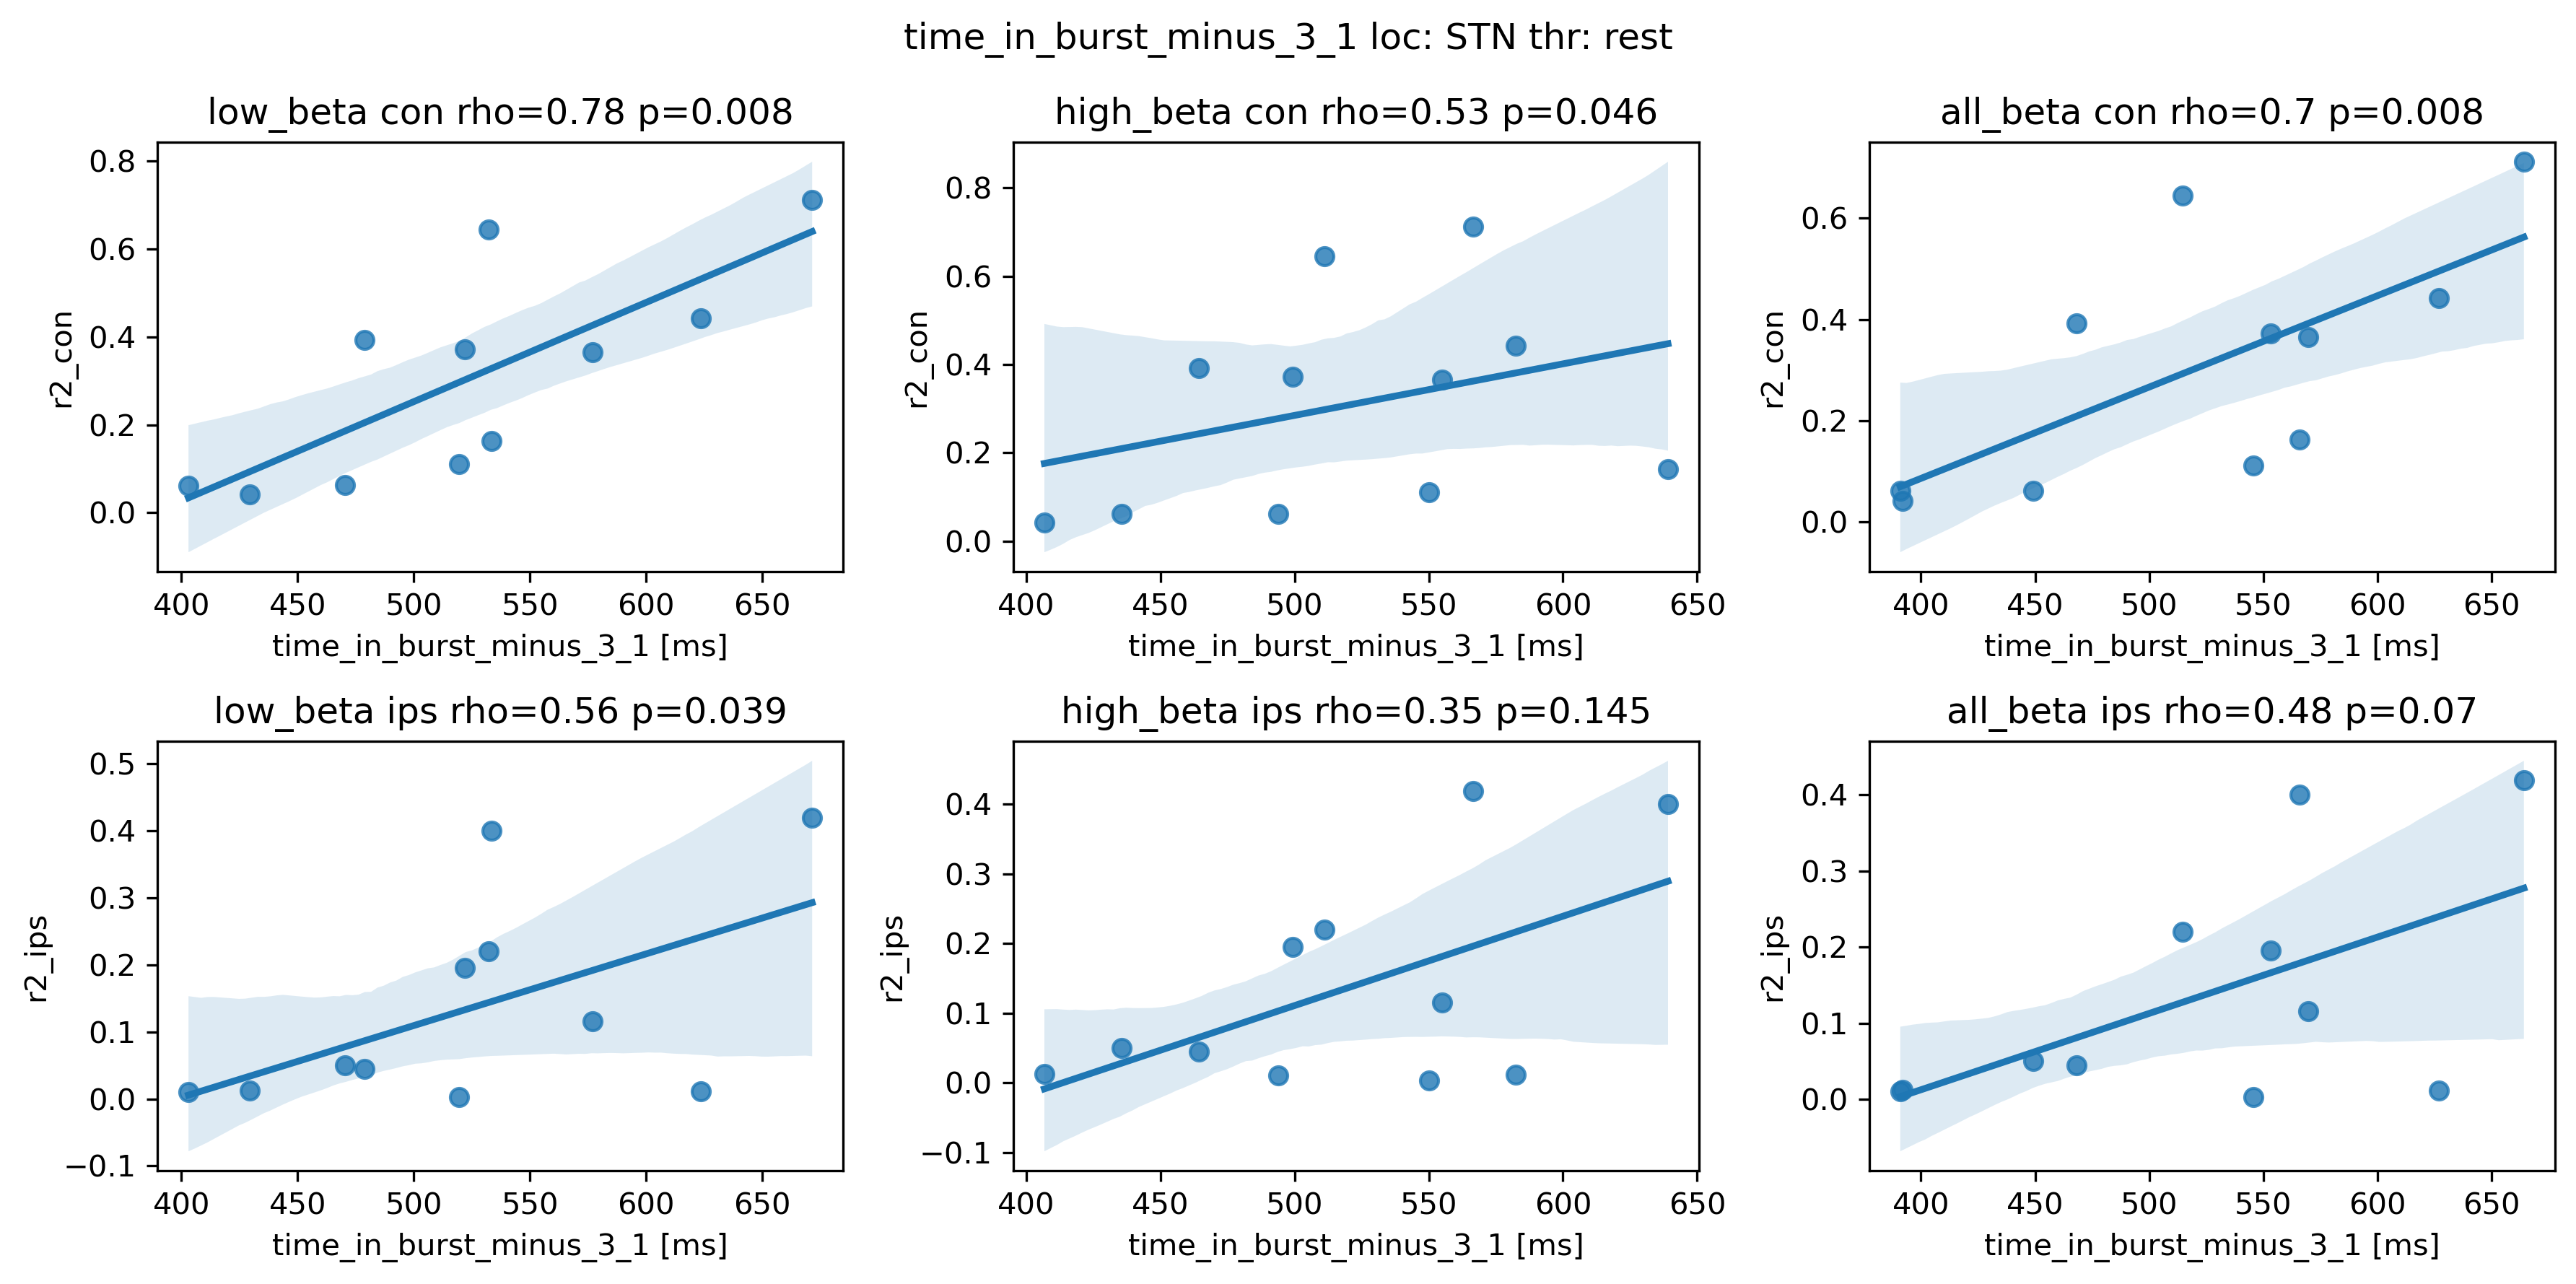

In [54]:
for x_ in ["time_in_burst_0_1", "time_in_burst_minus_1_0", "time_in_burst_minus_3_1"]:
    for loc in ["ECOG", "STN"]:
        for thr  in ["whole segment", "rest"]:
            plot_beta_con_ips_corr(x_, loc, thr)

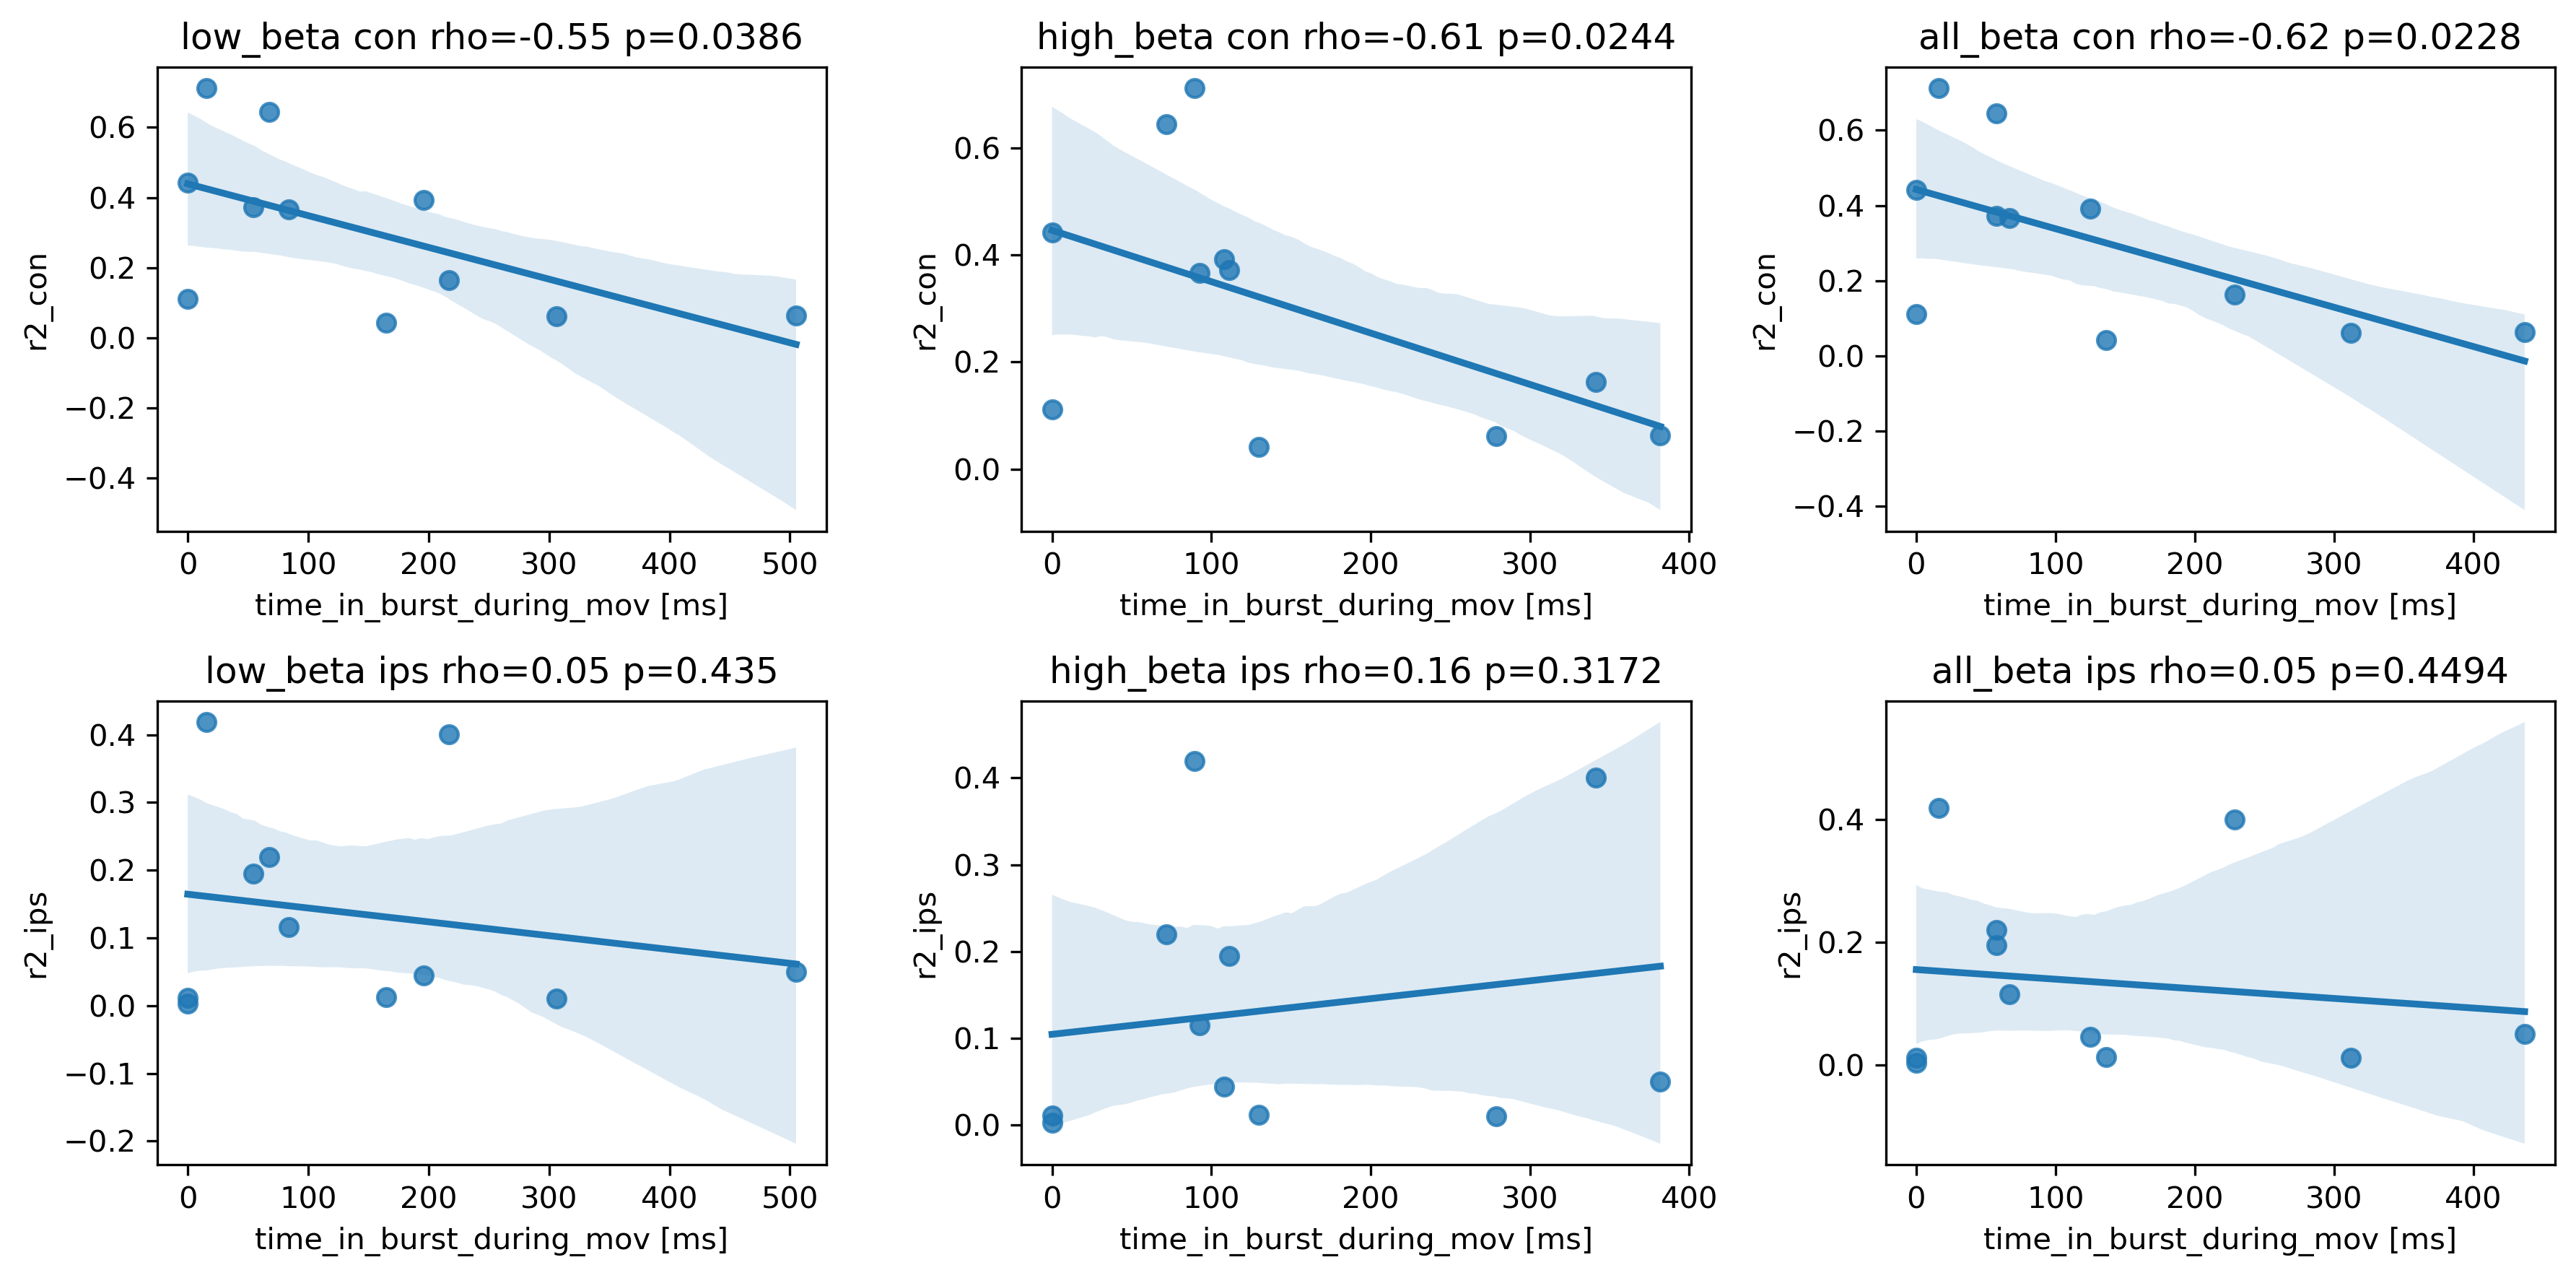

In [20]:
plt.figure(figsize=(12,6), dpi=300)
idx = 1
for lat in ["con", "ips"]:
    for beta in beta_names:
        #rho, p = stats.spearmanr(
        #    df_merged.query('beta==@beta')["r2_"+lat],
        #    df_merged.query('beta==@beta')["burst_duration_mean"],
        #)
        rho, p = icn_stats.permutationTestSpearmansRho(
            df_merged.query('beta==@beta')["r2_"+lat],
            df_merged.query('beta==@beta')["time_in_burst_during_mov"],
            False,
            "R^2"
        )
        plt.subplot(2,3,idx)
        idx+=1
        sns.regplot(x="time_in_burst_during_mov", y="r2_"+lat, data=df_merged.query('beta==@beta'))
        plt.title(f"{beta} {lat} rho={np.round(rho,2)} p={np.round(p,4)}")
        plt.xlabel("time_in_burst_during_mov [ms]")
plt.tight_layout()